# Time Series Model for Ontario Gasoline Demand Using Python
### David Lowe
### October 16, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. https://machinelearningmastery.com/

SUMMARY: The purpose of this project is to construct a time series prediction model and document the end-to-end steps using a template. The Ontario Gasoline Demand dataset is a time series situation where we are trying to forecast future outcomes based on past data points.

INTRODUCTION: The problem is to forecast the gasoline demand for Ontario. The dataset describes a time-series of gasoline demand (in millions of gallons) between 1960 to 1975, and there are 192 monthly observations. We used the first 80% of the observations for training and testing various models while holding back the remaining observations for validating the final model.

ANALYSIS: The baseline prediction (or persistence) for the dataset resulted in an RMSE of 18836. After performing a grid search for the most optimal ARIMA parameters, the final ARIMA non-seasonal order was (2, 1, 0) with the seasonal order being (1, 2, 2, 12). Furthermore, the chosen model processed the validation data with an RMSE of 9794, which was better than the baseline model as expected.

CONCLUSION: For this dataset, the chosen ARIMA model achieved a satisfactory result and should be considered for further modeling.

Dataset Used: Ontario Gasoline Demand

Dataset ML Model: Time series forecast with numerical attributes

Dataset Reference: Rob Hyndman and Yangzhuoran Yang (2018). tsdl: Time Series Data Library. v0.1.0. https://pkg.yangzhuoranyang./tsdl/.

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end
* Explore data cleaning and transformation options
* Explore various algorithms for baselining the model performance
* Explore tuning techniques for improving the model performance

A time series predictive modeling project genrally can be broken down into about five major tasks:

1. Define Problem and Acquire Data
2. Inspect and Explore Data
3. Clean and Pre-Process Data
4. Fit and Evaluate Models
5. Finalize Model

## Section 1. Define Problem and Acquire Data

### 1.a) Load Libraries

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import smtplib
import pmdarima as pm
from datetime import datetime
from email.message import EmailMessage
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### 1.b) Set up the controlling parameters and functions

In [3]:
# Create the random seed number for reproducible results
seedNum = 888

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = False

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = True

In [4]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Time Series Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [5]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Acquire and Load the Data

Since the dataset is not current, this means that we cannot easily collect updated data to validate the model. Therefore, we will withhold a portion of the data towards the end from analysis and model selection. This very segment of data will be used to validate the final model.

In [6]:
startTimeScript = datetime.now()

In [7]:
# load the dataset and the necessary data structure
time_series = pd.read_csv('gasoline-tsdl004.csv', index_col='idx', parse_dates=True)

# Sample code for subsetting the time-series data
# original_series = pd.read_csv('minimum-daily-temperatures.csv', index_col='Date', parse_dates=True)
# time_series = original_series['1986':'1990']

In [8]:
target_col = time_series.columns[0]
lower_bound = 'lower ' + target_col
upper_bound = 'upper ' + target_col
print('The target column of the time series is:', target_col)
print('The forecast boundary columns are:', lower_bound, '&', upper_bound)

The target column of the time series is: values
The forecast boundary columns are: lower values & upper values


In [9]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 1960-01-01 to 1975-12-01
Data columns (total 1 columns):
values    192 non-null int64
dtypes: int64(1)
memory usage: 3.0 KB


In [10]:
time_series.head(10)

,values
idx,
1960-01-01,87695
1960-02-01,86890
1960-03-01,96442
1960-04-01,98133
1960-05-01,113615
1960-06-01,123924
1960-07-01,128924
1960-08-01,134775
1960-09-01,117357


In [11]:
time_series.tail(10)

,values
idx,
1975-03-01,195997
1975-04-01,208684
1975-05-01,244113
1975-06-01,243108
1975-07-01,255918
1975-08-01,244642
1975-09-01,237579
1975-10-01,237579
1975-11-01,217775


In [12]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2. Inspect and Explore Data

In [13]:
if (notifyStatus): email_notify("Data Inspection and Exploration has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Summary Statistics of the Time Series Data

Summary statistics provide a quick look at the limits of observed values. It can help to get a quick idea of what we are working with.

In [14]:
# Summary statistics of time series
print(time_series.describe())

              values
count     192.000000
mean   162063.682292
std     41661.872770
min     86890.000000
25%    128425.500000
50%    157459.000000
75%    193555.750000
max    255918.000000


### 2.b) Line Plot of the Time Series Data

A line plot of a time series can provide a lot of insight into the problem. Some observations from the plot can include:

* Whether the trend appears to be level around the mean
* Whether there appear to be any obvious outliers

The ARIMA(p,d,q) model requires three parameters and assumes that we are working with a stationary time series.

The ADF results should show that the test statistic value is smaller than the critical value at 5% if the time series is stationary. This suggests that we can reject the null hypothesis (i.e. a low probability that the result is a statistical fluke).

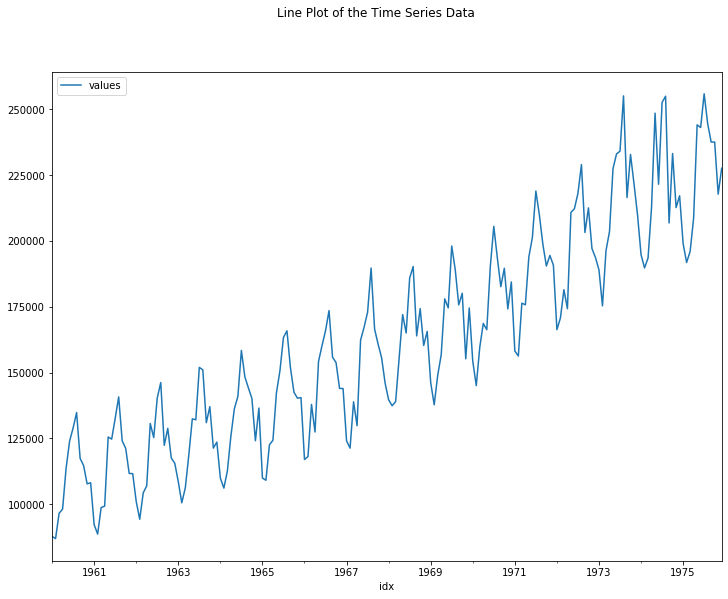

In [15]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Time Series Data')
time_series.plot(ax=ax)
plt.show()

### 2.c) Histogram and Density Plots of the Time Series Data

Reviewing plots of the density of observations can provide further insight into the structure of the data. Some observations from the plots can include:

* Whether the distribution is Gaussian
* Whether the distribution has a long tail and may suggest the need for data transformation

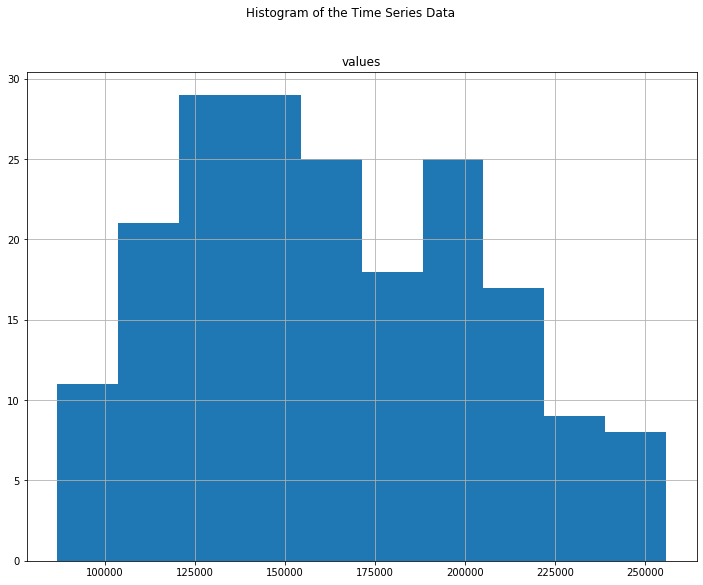

In [16]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Histogram of the Time Series Data')
time_series.hist(ax=ax)
plt.show()

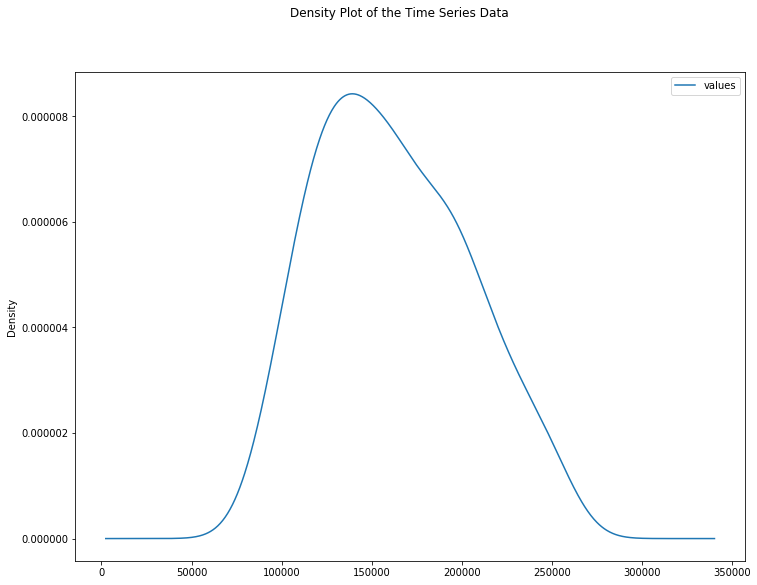

In [17]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Density Plot of the Time Series Data')
time_series.plot(kind='kde', ax=ax)
plt.show()

### 2.d) Box and Whisker Plots of the Time Series Data

We can group or aggregate the data and get a better idea of the spread of observations. Some observations from reviewing the plot can include:

* Whether the median values for each grouping shows any significant trend
* Whether the spread, or middle 50% of the data, shows any significant variability
* Whether there are outliers in some grouping

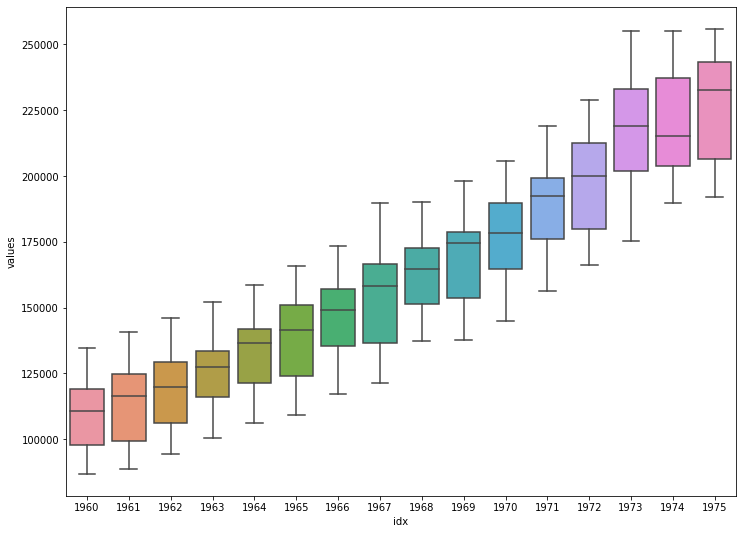

In [18]:
# boxplots of time series
fig, ax = plt.subplots(figsize=(12,9))
squeezed = time_series.squeeze()
sns.boxplot(squeezed.index.year, squeezed, ax=ax)
plt.show()

In [19]:
if (notifyStatus): email_notify("Data Inspection and Exploration completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3. Data Transformation and Stationarity Tests

In [20]:
if (notifyStatus): email_notify("Data Cleaning and Pre-Processing has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### Section 3.a) Data Transformation

In [21]:
# Not applicable for this iteration of the project

### Section 3.b) Test for Stationarity

In [22]:
# Check if stationary
result = adfuller(time_series[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.584705
p-value: 0.987232
Critical Test Statistics Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


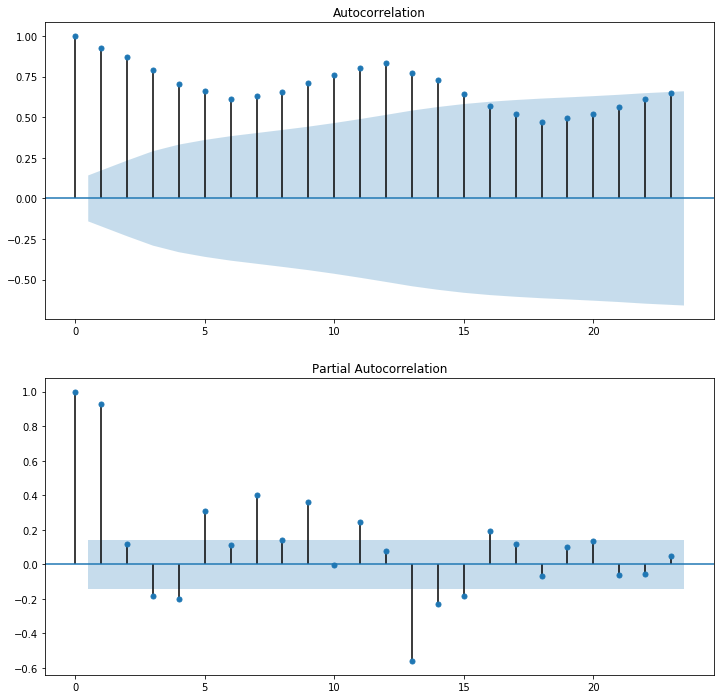

In [23]:
# ACF and PACF plots of the time series data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(time_series, ax=ax1)
plot_pacf(time_series, ax=ax2)
plt.show()

### 3.c) Test for Stationarity of Non-Seasonal Time Series Data

Occasionally a time series may look non-stationary on the first look. We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

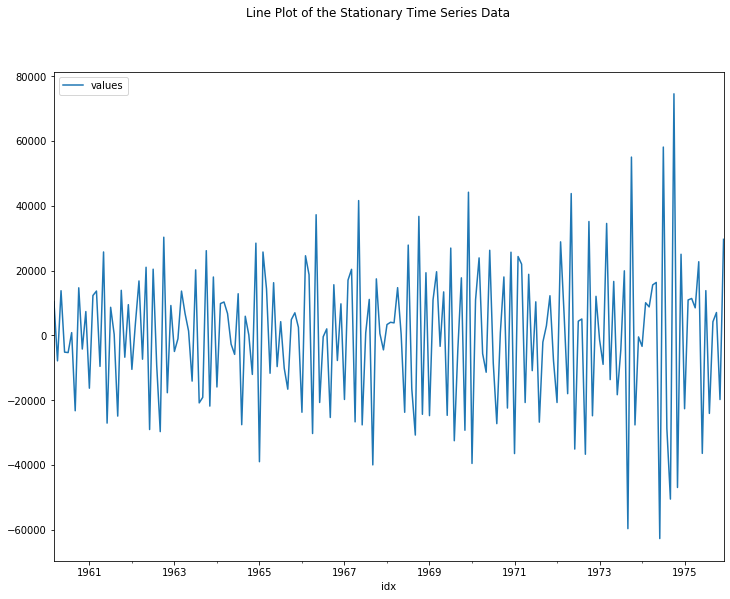

In [24]:
# Create a differenced series
stationary_ns = time_series.diff().diff().dropna()

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Time Series Data')
stationary_ns.plot(ax=ax)
plt.show()

In [25]:
# Check for stationarity
result = adfuller(stationary_ns[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.830631
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


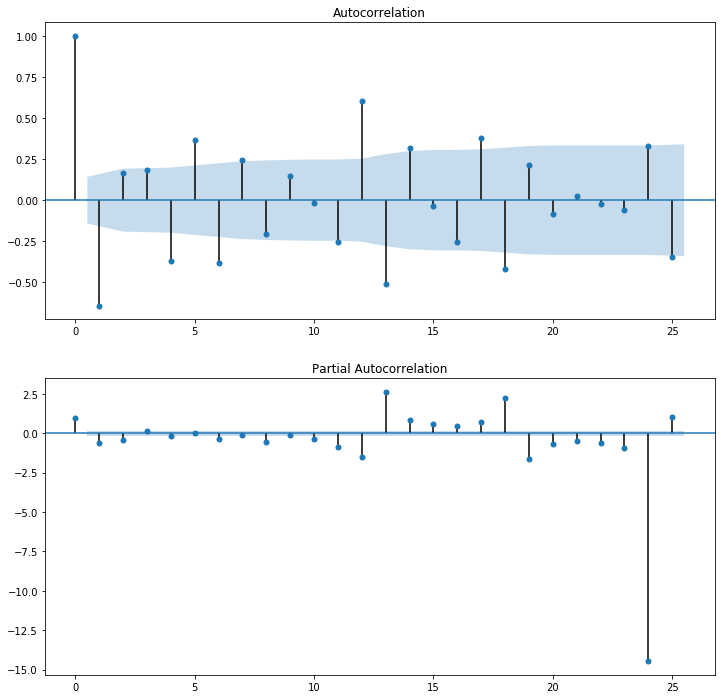

In [26]:
# ACF and PACF plots of the stationary time series
lags = 25
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(stationary_ns, lags=lags, ax=ax1)
plot_pacf(stationary_ns, lags=lags, ax=ax2)
plt.show()

### 3.d) Seasonal Decomposition for Seasonal Time Series Data

In [27]:
# Set the initial seasonal frequency parameter
seasonal_freq = 12

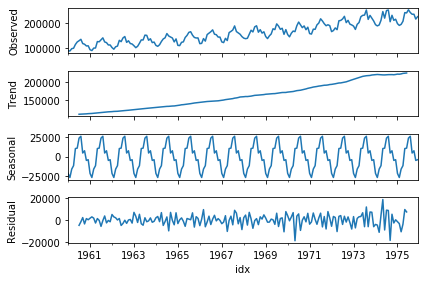

In [28]:
# Perform seasonal decomposition to observe the seasonal frequency
decomp_results = seasonal_decompose(time_series, freq=seasonal_freq)
decomp_results.plot()
plt.show()

In [29]:
# Detrending the time series
N = seasonal_freq
detrend = time_series - time_series.rolling(N).mean()
detrend = detrend.dropna()

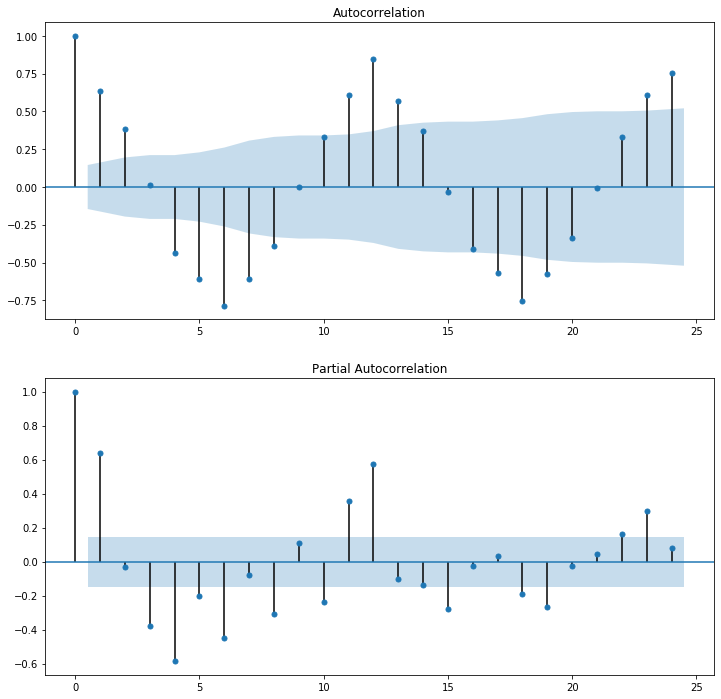

In [30]:
# ACF and PACF plots of the time series data
lag = seasonal_freq * 2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(detrend, lags=lag, ax=ax1)
plot_pacf(detrend, lags=lag, ax=ax2)
plt.show()

### 3.e) Test for Stationarity of Seasonal Time Series Data

Occasionally a time series may look non-stationary on the first look. We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

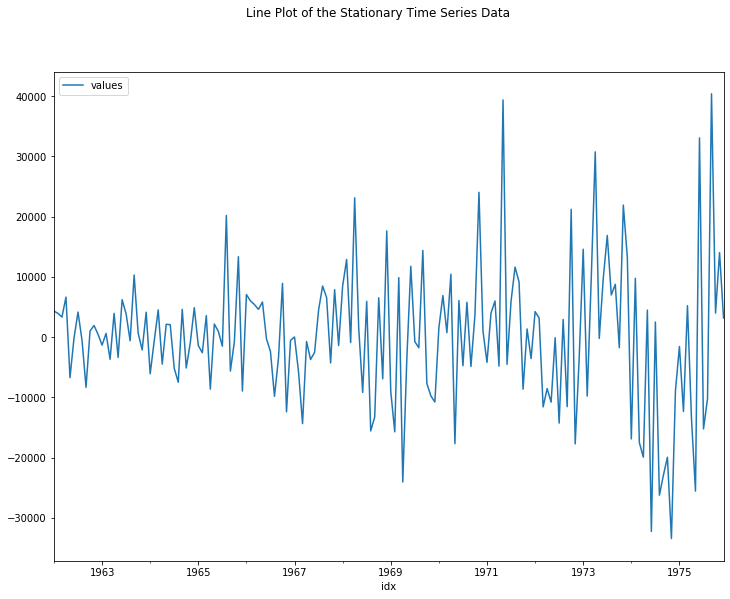

In [31]:
# Create a differenced series
stationary_ss = time_series.diff(seasonal_freq).diff(seasonal_freq).dropna()

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Time Series Data')
stationary_ss.plot(ax=ax)
plt.show()

In [32]:
# Check for stationarity
result = adfuller(stationary_ss[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.721213
p-value: 0.003824
Critical Test Statistics Values:
	1%: -3.474
	5%: -2.881
	10%: -2.577


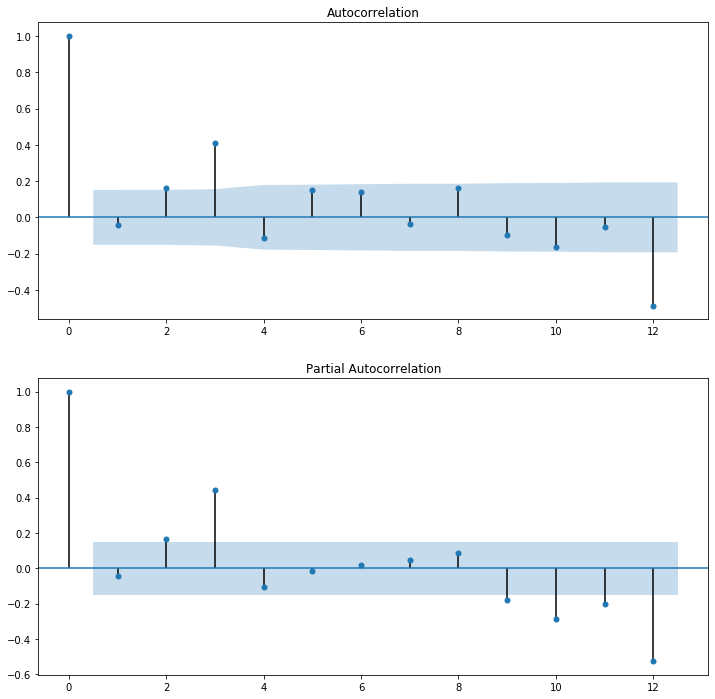

In [33]:
# ACF and PACF plots of the stationary time series
lags = seasonal_freq
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(stationary_ss, lags=lags, ax=ax1)
plot_pacf(stationary_ss, lags=lags, ax=ax2)
plt.show()

In [34]:
if (notifyStatus): email_notify("Data Cleaning and Pre-Processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 4. Fit and Evaluate Models

In this section, we will develop Autoregressive Integrated Moving Average or ARIMA models for the problem. We will first establish a persistent model. Next we will use a grid search approach to look for an optimal ARIMA model. This will be followed by a third step of investigating the residual errors of the chosen model.

* Establish the Persistent Model
* Automatically Configure the ARIMA
* Review Residual Errors

In [35]:
if (notifyStatus): email_notify("Model Fitting and Evaluation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Establish the Persistent Model

The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared.

The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

#### 4.a.iii) Establish the Persistent Model as Baseline

In [36]:
# Prepare and evaluate a persistence model
X = time_series.values
X = X.astype('float32')
train_pct = 0.80
train_size = int(len(X) * train_pct)
test_size = len(X) - train_size
train_ts, test_ts = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train_ts]
predictions = list()
for i in range(len(test_ts)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test_ts[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# Calculate performance
rmse = math.sqrt(mean_squared_error(test_ts, predictions))
print('RMSE for the persistent model is: %.3f' % rmse)

>Predicted=203200.000, Expected=212557
>Predicted=212557.000, Expected=197095
>Predicted=197095.000, Expected=193693
>Predicted=193693.000, Expected=188992
>Predicted=188992.000, Expected=175347
>Predicted=175347.000, Expected=196265
>Predicted=196265.000, Expected=203526
>Predicted=203526.000, Expected=227443
>Predicted=227443.000, Expected=233038
>Predicted=233038.000, Expected=234119
>Predicted=234119.000, Expected=255133
>Predicted=255133.000, Expected=216478
>Predicted=216478.000, Expected=232868
>Predicted=232868.000, Expected=221616
>Predicted=221616.000, Expected=209893
>Predicted=209893.000, Expected=194784
>Predicted=194784.000, Expected=189756
>Predicted=189756.000, Expected=193522
>Predicted=193522.000, Expected=212870
>Predicted=212870.000, Expected=248565
>Predicted=248565.000, Expected=221532
>Predicted=221532.000, Expected=252642
>Predicted=252642.000, Expected=255007
>Predicted=255007.000, Expected=206826
>Predicted=206826.000, Expected=233231
>Predicted=233231.000, Ex

### 4.b) Grid Search of ARIMA Hyperparameters

We want to find a model that can do better than the persistence model on this dataset. To confirm this analysis, we can grid search a suite of ARIMA hyperparameters.

In this section, we will search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance. We will use a grid search to explore all combinations in a subset of integer values.

In [37]:
if (notifyStatus): email_notify("ARIMA Hyperparameters Search has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [38]:
# Testing the time series data for suggestions on the differencing term
print('The suggested non-seasonal differencing term is:', pm.arima.ndiffs(time_series))
if (seasonal_freq != 0): print('The suggested seasonal differencing term is:', pm.arima.nsdiffs(time_series, m = seasonal_freq))

The suggested non-seasonal differencing term is: 1
The suggested seasonal differencing term is: 0


In [39]:
# Set the P, D, and Q order parameters for non-seasonal ARIMA modeling
start_p = 0
start_d = 1
start_q = 0
max_p = 5
max_d = 3
max_q = 5

In [40]:
# Set the P, D, and Q order parameters for seasonal ARIMA modeling
start_P = 0
start_D = 1
start_Q = 0
max_P = 5
max_D = 3
max_Q = 5

In [41]:
print('The initial non-seasonal parameters are: p =', start_p, '| d =', start_d, '| q =', start_q)
print('The maximum non-seasonal parameters are: max_p =', max_p, '| max_d =', max_d, '| max_q =', max_q)
print('The initial seasonal parameters are: P =', start_P, '| D =', start_D, '| Q =', start_Q, '| m =', seasonal_freq)
print('The maximum seasonal parameters are: max_P =', max_P, '| max_D =', max_D, '| max_Q =', max_Q)

The initial non-seasonal parameters are: p = 0 | d = 1 | q = 0
The maximum non-seasonal parameters are: max_p = 5 | max_d = 3 | max_q = 5
The initial seasonal parameters are: P = 0 | D = 1 | Q = 0 | m = 12
The maximum seasonal parameters are: max_P = 5 | max_D = 3 | max_Q = 5


In [42]:
# Do an automated stepwise search of ARIMA parameters
if (seasonal_freq == 0): auto_results = pm.auto_arima(time_series, start_p = start_p, max_p = max_p, d = start_d, max_d = max_d, start_q = start_q, max_q = max_q, 
                                                seasonal = False, trace = True, stepwise = True, n_jobs = n_jobs)
else:
    auto_results = pm.auto_arima(time_series, start_p = start_p, max_p = max_p, d = start_d, max_d = max_d, start_q = start_q, max_q = max_q, 
                            seasonal = True, m = seasonal_freq, D = start_D, max_D = max_D, start_P = start_P, max_P = max_P,
                            start_Q = start_Q, max_Q = max_Q, trace = True, stepwise = True, n_jobs = n_jobs)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3839.545, BIC=3845.920, Fit time=0.046 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3789.281, BIC=3802.031, Fit time=0.525 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3776.188, BIC=3788.938, Fit time=0.807 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3766.497, BIC=3782.434, Fit time=0.812 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=3784.111, BIC=3796.860, Fit time=0.424 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3763.716, BIC=3782.840, Fit time=2.253 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 3, 12); AIC=3754.430, BIC=3779.929, Fit time=8.409 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 3, 12); AIC=3753.999, BIC=3782.686, Fit time=10.452 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 3, 12); AIC=3757.505, BIC=3783.004, Fit time=8.914 seconds
Fit ARIMA: order=(1, 1, 2) 

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 1, 3, 12); AIC=3733.175, BIC=3768.236, Fit time=19.539 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 3, 12); AIC=3746.894, BIC=3778.768, Fit time=9.581 seconds


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(3, 1, 3, 12); AIC=3745.152, BIC=3783.401, Fit time=22.229 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 1, 2, 12); AIC=3742.706, BIC=3774.580, Fit time=11.801 seconds


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 1, 4, 12); AIC=3735.242, BIC=3773.491, Fit time=29.101 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=3744.952, BIC=3773.639, Fit time=5.753 seconds


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 1, 3, 12); AIC=3734.827, BIC=3773.075, Fit time=20.472 seconds


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 3, 12); AIC=3736.161, BIC=3768.035, Fit time=17.967 seconds


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(2, 1, 3, 12); AIC=3730.350, BIC=3768.598, Fit time=24.089 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 1, 3, 12); AIC=3732.669, BIC=3767.730, Fit time=18.009 seconds


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(2, 1, 2, 12); AIC=3732.841, BIC=3767.902, Fit time=15.108 seconds


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 1, 2, 12); AIC=3736.600, BIC=3768.473, Fit time=12.077 seconds


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 1, 3, 12); AIC=3740.206, BIC=3775.268, Fit time=20.746 seconds
Total fit time: 278.107 seconds


In [43]:
print(auto_results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  192
Model:             SARIMAX(2, 1, 3)x(2, 1, 3, 12)   Log Likelihood               -1853.175
Date:                            Mon, 07 Oct 2019   AIC                           3730.350
Time:                                    19:51:16   BIC                           3768.598
Sample:                                         0   HQIC                          3745.859
                                            - 192                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     38.4530    623.592      0.062      0.951   -1183.766    1260.672
ar.L1         -1.1512      0.010   

In [44]:
# Set up the function to handle the ARIMA calculation
def Calculate_ARIMA(ns_order, ss_order):
    startTimeModel = datetime.now()
    aic_score, bic_score = float("inf"), float("inf")
    if (verbose): print('Trying to fit the model with parameters:', ns_order, ss_order)
    try:
        if (ss_order[3] == 0): model = SARIMAX(time_series, order=ns_order)
        else: model = SARIMAX(time_series, order=ns_order, seasonal_order=ss_order)
        grid_results = model.fit()
        aic_score = grid_results.aic
        bic_score = grid_results.bic
        print('Fit ARIMA: order=%s seasonal_order=%s; AIC=%.3f, BIC=%.3f, Fit time=%s' % 
              (ns_order, ss_order, aic_score, bic_score, (datetime.now() - startTimeModel)))
        return(aic_score, bic_score)
    except:
        return(float("inf"), float("inf"))

In [45]:
# Do a manual grid search of ARIMA parameters
best_score, best_ns_cfg, best_ss_cfg = float("inf"), None, None
for p in range(start_p, max_p):
    for d in range(start_d, max_d):
        for q in range(start_q, max_q):
            for P in range(start_P, max_P):
                for D in range(start_D, max_D):
                    for Q in range(start_Q, max_Q):
                        ns_order = (p, d, q)
                        ss_order = (P, D, Q, seasonal_freq)
                        aic_score, bic_score = Calculate_ARIMA(ns_order, ss_order)
                        if (aic_score < best_score): best_ns_cfg, best_ss_cfg, best_score =ns_order, ss_order, aic_score
print('Best ARIMA model via manual search: order=%s seasonal_order=%s; AIC=%f' % (best_ns_cfg, best_ss_cfg, best_score))

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3837.998, BIC=3841.185, Fit time=0:00:00.048670
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=3822.912, BIC=3829.286, Fit time=0:00:00.729348


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 2, 12); AIC=3797.461, BIC=3807.023, Fit time=0:00:02.216513


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 3, 12); AIC=3841.352, BIC=3854.102, Fit time=0:00:03.953287


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 4, 12); AIC=3847.427, BIC=3863.364, Fit time=0:00:03.679018
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 2, 0, 12); AIC=3724.952, BIC=3728.070, Fit time=0:00:00.086082


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 2, 1, 12); AIC=3615.248, BIC=3621.484, Fit time=0:00:01.401608


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 2, 2, 12); AIC=3600.895, BIC=3610.249, Fit time=0:00:03.545910


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 2, 3, 12); AIC=3586.693, BIC=3599.165, Fit time=0:00:11.614664


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 2, 4, 12); AIC=3586.032, BIC=3601.621, Fit time=0:00:19.129110


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3833.676, BIC=3840.051, Fit time=0:00:00.253212


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=3810.115, BIC=3819.677, Fit time=0:00:00.531241


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=3817.265, BIC=3830.014, Fit time=0:00:01.565497


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 3, 12); AIC=3837.223, BIC=3853.160, Fit time=0:00:02.208973


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 4, 12); AIC=3845.481, BIC=3864.605, Fit time=0:00:03.943058


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 2, 0, 12); AIC=3692.384, BIC=3698.620, Fit time=0:00:00.499915


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 2, 1, 12); AIC=3636.582, BIC=3645.936, Fit time=0:00:00.967379


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 2, 2, 12); AIC=3588.446, BIC=3600.918, Fit time=0:00:08.656922


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 2, 3, 12); AIC=3670.524, BIC=3686.114, Fit time=0:00:06.755631


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 2, 4, 12); AIC=3707.953, BIC=3726.661, Fit time=0:00:08.983056


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=3826.140, BIC=3835.702, Fit time=0:00:00.666598


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=3802.564, BIC=3815.314, Fit time=0:00:01.345646


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 2, 12); AIC=3808.545, BIC=3824.482, Fit time=0:00:02.717924


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 3, 12); AIC=3825.888, BIC=3845.012, Fit time=0:00:06.188134


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 4, 12); AIC=3823.006, BIC=3845.318, Fit time=0:00:13.826924


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 2, 0, 12); AIC=3672.631, BIC=3681.985, Fit time=0:00:00.966843


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 2, 1, 12); AIC=3631.085, BIC=3643.557, Fit time=0:00:01.837742


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 2, 2, 12); AIC=3638.805, BIC=3654.395, Fit time=0:00:05.911295


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 2, 3, 12); AIC=3657.164, BIC=3675.872, Fit time=0:00:15.754164


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 2, 4, 12); AIC=3695.275, BIC=3717.101, Fit time=0:00:16.935844


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(3, 1, 0, 12); AIC=3812.785, BIC=3825.534, Fit time=0:00:01.497132


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(3, 1, 1, 12); AIC=3793.413, BIC=3809.350, Fit time=0:00:02.663346


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(3, 1, 2, 12); AIC=3799.330, BIC=3818.455, Fit time=0:00:05.205402


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(3, 1, 3, 12); AIC=3819.009, BIC=3841.321, Fit time=0:00:04.162029


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(3, 1, 4, 12); AIC=3825.323, BIC=3850.822, Fit time=0:00:17.502377


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(3, 2, 0, 12); AIC=3661.443, BIC=3673.915, Fit time=0:00:02.099641


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(3, 2, 1, 12); AIC=3622.993, BIC=3638.583, Fit time=0:00:03.948020


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(3, 2, 2, 12); AIC=3632.929, BIC=3651.637, Fit time=0:00:11.077505


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(3, 2, 3, 12); AIC=3654.834, BIC=3676.660, Fit time=0:00:15.692041


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(3, 2, 4, 12); AIC=3686.627, BIC=3711.571, Fit time=0:00:22.924044


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(4, 1, 0, 12); AIC=3793.452, BIC=3809.389, Fit time=0:00:03.029147


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(4, 1, 1, 12); AIC=3785.080, BIC=3804.205, Fit time=0:00:06.061597


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(4, 1, 2, 12); AIC=3783.940, BIC=3806.252, Fit time=0:00:09.212714


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(4, 1, 3, 12); AIC=3793.960, BIC=3819.459, Fit time=0:00:14.475323


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(4, 1, 4, 12); AIC=3795.410, BIC=3824.096, Fit time=0:00:21.658740


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(4, 2, 0, 12); AIC=3637.601, BIC=3653.191, Fit time=0:00:05.708316


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(4, 2, 1, 12); AIC=3598.705, BIC=3617.413, Fit time=0:00:08.093257


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(4, 2, 2, 12); AIC=3604.317, BIC=3626.143, Fit time=0:00:12.315343


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(4, 2, 3, 12); AIC=3625.357, BIC=3650.301, Fit time=0:00:18.662594


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(4, 2, 4, 12); AIC=3620.349, BIC=3648.411, Fit time=0:00:23.369674
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3792.137, BIC=3798.512, Fit time=0:00:00.113604


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3771.863, BIC=3781.425, Fit time=0:00:00.576304


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3756.517, BIC=3769.266, Fit time=0:00:01.286037


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 3, 12); AIC=3831.086, BIC=3847.023, Fit time=0:00:07.913122


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 4, 12); AIC=3758.897, BIC=3778.022, Fit time=0:00:05.104930


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 2, 0, 12); AIC=3621.621, BIC=3627.857, Fit time=0:00:00.350524


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=3500.492, BIC=3509.846, Fit time=0:00:05.084965


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 2, 2, 12); AIC=3557.011, BIC=3569.483, Fit time=0:00:04.610635


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 2, 3, 12); AIC=3556.317, BIC=3571.907, Fit time=0:00:09.865693


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 2, 4, 12); AIC=3557.153, BIC=3575.861, Fit time=0:00:19.641455


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=3780.957, BIC=3790.519, Fit time=0:00:00.476292


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3757.842, BIC=3770.591, Fit time=0:00:00.811764


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3757.525, BIC=3773.462, Fit time=0:00:02.271970


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 3, 12); AIC=3758.991, BIC=3778.115, Fit time=0:00:05.797698


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 4, 12); AIC=3761.000, BIC=3783.312, Fit time=0:00:09.230767


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 2, 0, 12); AIC=3611.159, BIC=3620.513, Fit time=0:00:01.714770


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 2, 1, 12); AIC=3502.397, BIC=3514.869, Fit time=0:00:07.245810


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 2, 2, 12); AIC=3558.708, BIC=3574.298, Fit time=0:00:13.048768


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 2, 3, 12); AIC=3557.075, BIC=3575.783, Fit time=0:00:19.120374


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 2, 4, 12); AIC=3559.039, BIC=3580.865, Fit time=0:00:36.300315


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=3773.288, BIC=3786.037, Fit time=0:00:00.931585


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 12); AIC=3756.288, BIC=3772.225, Fit time=0:00:01.633258


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=3753.271, BIC=3772.395, Fit time=0:00:04.320914


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 3, 12); AIC=3749.784, BIC=3772.096, Fit time=0:00:07.077790


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 4, 12); AIC=3750.782, BIC=3776.281, Fit time=0:00:20.250884


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 2, 0, 12); AIC=3583.817, BIC=3596.289, Fit time=0:00:04.568552


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 2, 1, 12); AIC=3557.231, BIC=3572.821, Fit time=0:00:09.686137


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 2, 2, 12); AIC=3560.251, BIC=3578.959, Fit time=0:00:11.806769


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 2, 3, 12); AIC=3562.275, BIC=3584.101, Fit time=0:00:27.768039


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 2, 4, 12); AIC=3560.603, BIC=3585.547, Fit time=0:00:34.443418


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(3, 1, 0, 12); AIC=3765.859, BIC=3781.796, Fit time=0:00:01.465774


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(3, 1, 1, 12); AIC=3754.777, BIC=3773.901, Fit time=0:00:03.217074


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(3, 1, 2, 12); AIC=3752.355, BIC=3774.667, Fit time=0:00:06.536659


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(3, 1, 3, 12); AIC=3756.722, BIC=3782.222, Fit time=0:00:06.110685


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(3, 1, 4, 12); AIC=3752.568, BIC=3781.255, Fit time=0:00:28.628379


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(3, 2, 0, 12); AIC=3575.434, BIC=3591.024, Fit time=0:00:07.862742


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(3, 2, 1, 12); AIC=3558.254, BIC=3576.962, Fit time=0:00:16.972790


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(3, 2, 2, 12); AIC=3560.980, BIC=3582.806, Fit time=0:00:21.511360


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(3, 2, 3, 12); AIC=3569.869, BIC=3594.813, Fit time=0:00:25.842517


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(3, 2, 4, 12); AIC=3564.321, BIC=3592.383, Fit time=0:00:37.032233


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(4, 1, 0, 12); AIC=3753.802, BIC=3772.926, Fit time=0:00:03.734369


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(4, 1, 1, 12); AIC=3752.002, BIC=3774.314, Fit time=0:00:07.520941


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(4, 1, 2, 12); AIC=3750.696, BIC=3776.195, Fit time=0:00:12.552169


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(4, 1, 3, 12); AIC=3752.557, BIC=3781.244, Fit time=0:00:18.396307


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(4, 1, 4, 12); AIC=3754.486, BIC=3786.359, Fit time=0:00:27.724507


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(4, 2, 0, 12); AIC=3567.774, BIC=3586.482, Fit time=0:00:15.556016


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(4, 2, 1, 12); AIC=3558.214, BIC=3580.040, Fit time=0:00:32.118791


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(4, 2, 2, 12); AIC=3559.597, BIC=3584.540, Fit time=0:00:31.441567


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(4, 2, 3, 12); AIC=3571.494, BIC=3599.556, Fit time=0:00:39.869996


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(4, 2, 4, 12); AIC=3594.106, BIC=3625.286, Fit time=0:00:47.767385
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 0, 12); AIC=3788.947, BIC=3798.509, Fit time=0:00:00.170316


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=3767.512, BIC=3780.262, Fit time=0:00:00.769394


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 2, 12); AIC=3754.657, BIC=3770.593, Fit time=0:00:01.447786


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 3, 12); AIC=3831.255, BIC=3850.379, Fit time=0:00:10.113072


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 4, 12); AIC=3757.431, BIC=3779.742, Fit time=0:00:05.042825


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 2, 0, 12); AIC=3651.655, BIC=3661.009, Fit time=0:00:00.422839


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 2, 1, 12); AIC=3490.228, BIC=3502.700, Fit time=0:00:04.826628
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 2, 2, 12); AIC=3550.258, BIC=3565.848, Fit time=0:00:02.678073


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 2, 3, 12); AIC=3550.347, BIC=3569.055, Fit time=0:00:05.358640


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 2, 4, 12); AIC=3551.737, BIC=3573.563, Fit time=0:00:09.252972


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 12); AIC=3776.206, BIC=3788.955, Fit time=0:00:00.532714


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 1, 12); AIC=3755.883, BIC=3771.820, Fit time=0:00:00.985953


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=3755.838, BIC=3774.962, Fit time=0:00:02.271650


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 3, 12); AIC=3757.470, BIC=3779.781, Fit time=0:00:05.079329


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 4, 12); AIC=3759.443, BIC=3784.942, Fit time=0:00:08.994003


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 2, 0, 12); AIC=3601.259, BIC=3613.731, Fit time=0:00:01.355550


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 2, 1, 12); AIC=3491.212, BIC=3506.802, Fit time=0:00:05.064295


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 2, 2, 12); AIC=3552.739, BIC=3571.447, Fit time=0:00:03.548577


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 2, 3, 12); AIC=3551.658, BIC=3573.484, Fit time=0:00:13.097854


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 2, 4, 12); AIC=3553.605, BIC=3578.549, Fit time=0:00:27.557354


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(2, 1, 0, 12); AIC=3768.773, BIC=3784.710, Fit time=0:00:01.318608


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(2, 1, 1, 12); AIC=3754.848, BIC=3773.972, Fit time=0:00:02.251031


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(2, 1, 2, 12); AIC=3752.354, BIC=3774.666, Fit time=0:00:05.306116


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(2, 1, 3, 12); AIC=3749.284, BIC=3774.784, Fit time=0:00:10.214032


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(2, 1, 4, 12); AIC=3750.201, BIC=3778.888, Fit time=0:00:20.748403


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(2, 2, 0, 12); AIC=3575.229, BIC=3590.819, Fit time=0:00:02.348037


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(2, 2, 1, 12); AIC=3550.976, BIC=3569.684, Fit time=0:00:03.541720


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(2, 2, 2, 12); AIC=3551.598, BIC=3573.424, Fit time=0:00:08.907247


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(2, 2, 3, 12); AIC=3553.826, BIC=3578.770, Fit time=0:00:22.730523


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(2, 2, 4, 12); AIC=3555.351, BIC=3583.413, Fit time=0:00:33.094036


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(3, 1, 0, 12); AIC=3763.263, BIC=3782.388, Fit time=0:00:02.305787


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(3, 1, 1, 12); AIC=3754.012, BIC=3776.324, Fit time=0:00:03.856032


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(3, 1, 2, 12); AIC=3751.821, BIC=3777.320, Fit time=0:00:07.580345


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(3, 1, 3, 12); AIC=3755.903, BIC=3784.590, Fit time=0:00:11.805709


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(3, 1, 4, 12); AIC=3751.939, BIC=3783.813, Fit time=0:00:24.030603


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(3, 2, 0, 12); AIC=3566.511, BIC=3585.219, Fit time=0:00:04.248635


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(3, 2, 1, 12); AIC=3552.413, BIC=3574.239, Fit time=0:00:07.603976


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(3, 2, 2, 12); AIC=3554.846, BIC=3579.790, Fit time=0:00:06.910203


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(3, 2, 3, 12); AIC=3555.297, BIC=3583.359, Fit time=0:00:21.503236


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(3, 2, 4, 12); AIC=3555.375, BIC=3586.555, Fit time=0:00:39.006131


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(4, 1, 0, 12); AIC=3752.418, BIC=3774.730, Fit time=0:00:04.891913


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(4, 1, 1, 12); AIC=3751.246, BIC=3776.745, Fit time=0:00:07.355602


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(4, 1, 2, 12); AIC=3749.971, BIC=3778.657, Fit time=0:00:14.044608


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(4, 1, 3, 12); AIC=3751.888, BIC=3783.762, Fit time=0:00:16.243346


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(4, 1, 4, 12); AIC=3753.826, BIC=3788.887, Fit time=0:00:28.521224


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(4, 2, 0, 12); AIC=3560.498, BIC=3582.324, Fit time=0:00:07.716176


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(4, 2, 1, 12); AIC=3553.147, BIC=3578.091, Fit time=0:00:13.935752


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(4, 2, 2, 12); AIC=3554.741, BIC=3582.803, Fit time=0:00:20.805898


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(4, 2, 3, 12); AIC=3555.871, BIC=3587.051, Fit time=0:00:37.443593


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(4, 2, 4, 12); AIC=3558.742, BIC=3593.040, Fit time=0:00:42.768184


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(0, 1, 0, 12); AIC=3788.622, BIC=3801.371, Fit time=0:00:00.359301


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(0, 1, 1, 12); AIC=3769.476, BIC=3785.413, Fit time=0:00:01.161428


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(0, 1, 2, 12); AIC=3754.731, BIC=3773.855, Fit time=0:00:02.207203


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(0, 1, 3, 12); AIC=3829.513, BIC=3851.824, Fit time=0:00:14.712776


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(0, 1, 4, 12); AIC=3756.988, BIC=3782.487, Fit time=0:00:06.764560


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(0, 2, 0, 12); AIC=3612.734, BIC=3625.206, Fit time=0:00:01.979196


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(0, 2, 1, 12); AIC=3541.849, BIC=3557.439, Fit time=0:00:02.055137


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(0, 2, 2, 12); AIC=3543.282, BIC=3561.990, Fit time=0:00:04.147018


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(0, 2, 3, 12); AIC=3543.181, BIC=3565.007, Fit time=0:00:07.836073


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(0, 2, 4, 12); AIC=3544.768, BIC=3569.712, Fit time=0:00:14.732855


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(1, 1, 0, 12); AIC=3777.311, BIC=3793.248, Fit time=0:00:00.832144


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(1, 1, 1, 12); AIC=3755.936, BIC=3775.061, Fit time=0:00:01.548879


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(1, 1, 2, 12); AIC=3755.642, BIC=3777.954, Fit time=0:00:03.586822


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(1, 1, 3, 12); AIC=3757.058, BIC=3782.557, Fit time=0:00:06.955995


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(1, 1, 4, 12); AIC=3759.050, BIC=3787.737, Fit time=0:00:13.659745


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(1, 2, 0, 12); AIC=3600.110, BIC=3615.700, Fit time=0:00:01.634415


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(1, 2, 1, 12); AIC=3543.415, BIC=3562.123, Fit time=0:00:03.185615


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(1, 2, 2, 12); AIC=3545.360, BIC=3567.186, Fit time=0:00:14.032401


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(1, 2, 3, 12); AIC=3544.628, BIC=3569.572, Fit time=0:00:17.984882


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(1, 2, 4, 12); AIC=3547.052, BIC=3575.114, Fit time=0:00:25.506311


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(2, 1, 0, 12); AIC=3770.357, BIC=3789.481, Fit time=0:00:01.677650


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(2, 1, 1, 12); AIC=3754.419, BIC=3776.731, Fit time=0:00:02.813131


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(2, 1, 2, 12); AIC=3750.598, BIC=3776.097, Fit time=0:00:06.721124


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(2, 1, 3, 12); AIC=3746.666, BIC=3775.353, Fit time=0:00:12.954211


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(2, 1, 4, 12); AIC=3747.431, BIC=3779.305, Fit time=0:00:27.200408


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(2, 2, 0, 12); AIC=3569.259, BIC=3587.967, Fit time=0:00:03.291977


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(2, 2, 1, 12); AIC=3543.842, BIC=3565.668, Fit time=0:00:04.593674


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(2, 2, 2, 12); AIC=3544.599, BIC=3569.543, Fit time=0:00:10.665556


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(2, 2, 3, 12); AIC=3548.837, BIC=3576.899, Fit time=0:00:13.819638


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(2, 2, 4, 12); AIC=3548.438, BIC=3579.617, Fit time=0:00:43.903999


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(3, 1, 0, 12); AIC=3763.464, BIC=3785.776, Fit time=0:00:03.409520


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(3, 1, 1, 12); AIC=3752.631, BIC=3778.130, Fit time=0:00:05.061188


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(3, 1, 2, 12); AIC=3749.570, BIC=3778.257, Fit time=0:00:09.884933


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(3, 1, 3, 12); AIC=3754.033, BIC=3785.907, Fit time=0:00:12.725697


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(3, 1, 4, 12); AIC=3749.280, BIC=3784.341, Fit time=0:00:31.429934


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(3, 2, 0, 12); AIC=3560.310, BIC=3582.136, Fit time=0:00:07.638415


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(3, 2, 1, 12); AIC=3545.453, BIC=3570.397, Fit time=0:00:09.334579


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(3, 2, 2, 12); AIC=3547.783, BIC=3575.845, Fit time=0:00:09.911515


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(3, 2, 3, 12); AIC=3548.400, BIC=3579.580, Fit time=0:00:29.345692


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(3, 2, 4, 12); AIC=3547.916, BIC=3582.214, Fit time=0:00:46.655143


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(4, 1, 0, 12); AIC=3751.494, BIC=3776.993, Fit time=0:00:06.604353


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(4, 1, 1, 12); AIC=3749.542, BIC=3778.229, Fit time=0:00:09.412000


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(4, 1, 2, 12); AIC=3747.656, BIC=3779.530, Fit time=0:00:17.804476


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(4, 1, 3, 12); AIC=3749.352, BIC=3784.413, Fit time=0:00:31.394731


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(4, 1, 4, 12); AIC=3751.262, BIC=3789.511, Fit time=0:00:35.570772


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(4, 2, 0, 12); AIC=3553.566, BIC=3578.510, Fit time=0:00:13.427084


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(4, 2, 1, 12); AIC=3546.139, BIC=3574.201, Fit time=0:00:17.823828


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(4, 2, 2, 12); AIC=3547.817, BIC=3578.996, Fit time=0:00:23.776336


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(4, 2, 3, 12); AIC=3549.157, BIC=3583.455, Fit time=0:00:41.573466


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 3) seasonal_order=(4, 2, 4, 12); AIC=3550.519, BIC=3587.934, Fit time=0:00:55.674041


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(0, 1, 0, 12); AIC=3784.979, BIC=3800.915, Fit time=0:00:00.586280


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(0, 1, 1, 12); AIC=3754.756, BIC=3773.880, Fit time=0:00:01.344461


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(0, 1, 2, 12); AIC=3742.638, BIC=3764.950, Fit time=0:00:03.357674


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(0, 1, 3, 12); AIC=3817.898, BIC=3843.397, Fit time=0:00:14.800329


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(0, 1, 4, 12); AIC=3745.506, BIC=3774.192, Fit time=0:00:10.283523


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(0, 2, 0, 12); AIC=3589.346, BIC=3604.936, Fit time=0:00:04.776175
Fit ARIMA: order=(0, 1, 4) seasonal_order=(0, 2, 1, 12); AIC=3532.949, BIC=3551.657, Fit time=0:00:03.108008


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(0, 2, 2, 12); AIC=3534.617, BIC=3556.443, Fit time=0:00:05.189101


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(0, 2, 3, 12); AIC=3534.558, BIC=3559.502, Fit time=0:00:09.783657


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(0, 2, 4, 12); AIC=3536.006, BIC=3564.068, Fit time=0:00:17.727086


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(1, 1, 0, 12); AIC=3766.084, BIC=3785.208, Fit time=0:00:01.172390


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(1, 1, 1, 12); AIC=3743.252, BIC=3765.564, Fit time=0:00:01.893928


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(1, 1, 2, 12); AIC=3743.854, BIC=3769.353, Fit time=0:00:05.071734


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(1, 1, 3, 12); AIC=3745.521, BIC=3774.208, Fit time=0:00:07.931500


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(1, 1, 4, 12); AIC=3747.432, BIC=3779.305, Fit time=0:00:15.269304


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(1, 2, 0, 12); AIC=3580.191, BIC=3598.899, Fit time=0:00:03.532082


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(1, 2, 1, 12); AIC=3534.716, BIC=3556.542, Fit time=0:00:02.899848


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(1, 2, 2, 12); AIC=3536.896, BIC=3561.840, Fit time=0:00:05.604592


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(1, 2, 3, 12); AIC=3535.831, BIC=3563.893, Fit time=0:00:16.917205


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(1, 2, 4, 12); AIC=3538.331, BIC=3569.511, Fit time=0:00:26.221061


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(2, 1, 0, 12); AIC=3757.733, BIC=3780.045, Fit time=0:00:02.044011


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(2, 1, 1, 12); AIC=3743.183, BIC=3768.683, Fit time=0:00:03.279708


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(2, 1, 2, 12); AIC=3740.070, BIC=3768.757, Fit time=0:00:09.074505


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(2, 1, 3, 12); AIC=3734.631, BIC=3766.504, Fit time=0:00:18.643037


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(2, 1, 4, 12); AIC=3735.238, BIC=3770.300, Fit time=0:00:38.083663


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(2, 2, 0, 12); AIC=3557.472, BIC=3579.298, Fit time=0:00:03.562167


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(2, 2, 1, 12); AIC=3470.750, BIC=3495.694, Fit time=0:00:13.544758


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(2, 2, 2, 12); AIC=3535.788, BIC=3563.850, Fit time=0:00:13.758387


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(2, 2, 3, 12); AIC=3538.052, BIC=3569.231, Fit time=0:00:29.037954


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(2, 2, 4, 12); AIC=3539.827, BIC=3574.125, Fit time=0:00:40.432802


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(3, 1, 0, 12); AIC=3752.375, BIC=3777.874, Fit time=0:00:04.482857


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(3, 1, 1, 12); AIC=3742.399, BIC=3771.085, Fit time=0:00:06.183458


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(3, 1, 2, 12); AIC=3738.604, BIC=3770.478, Fit time=0:00:12.777324


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(3, 1, 3, 12); AIC=3743.689, BIC=3778.750, Fit time=0:00:21.038596


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(3, 1, 4, 12); AIC=3737.649, BIC=3775.897, Fit time=0:00:36.212327


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(3, 2, 0, 12); AIC=3550.645, BIC=3575.589, Fit time=0:00:06.275845


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(3, 2, 1, 12); AIC=3536.857, BIC=3564.919, Fit time=0:00:09.417609


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(3, 2, 2, 12); AIC=3539.195, BIC=3570.375, Fit time=0:00:21.402055


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(3, 2, 3, 12); AIC=3539.786, BIC=3574.084, Fit time=0:00:22.674018


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(3, 2, 4, 12); AIC=3539.603, BIC=3577.019, Fit time=0:00:53.379219


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(4, 1, 0, 12); AIC=3740.752, BIC=3769.438, Fit time=0:00:07.368607


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(4, 1, 1, 12); AIC=3738.848, BIC=3770.722, Fit time=0:00:11.606064


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(4, 1, 2, 12); AIC=3735.588, BIC=3770.649, Fit time=0:00:21.470420


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(4, 1, 3, 12); AIC=3736.915, BIC=3775.164, Fit time=0:00:32.127488


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(4, 1, 4, 12); AIC=3739.094, BIC=3780.530, Fit time=0:00:39.448547


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(4, 2, 0, 12); AIC=3544.711, BIC=3572.773, Fit time=0:00:12.921774


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(4, 2, 1, 12); AIC=3537.378, BIC=3568.558, Fit time=0:00:17.569712


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(4, 2, 2, 12); AIC=3538.949, BIC=3573.247, Fit time=0:00:27.176359


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(4, 2, 3, 12); AIC=3540.356, BIC=3577.772, Fit time=0:00:44.526190


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 4) seasonal_order=(4, 2, 4, 12); AIC=3542.096, BIC=3582.630, Fit time=0:00:56.448445
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=4024.047, BIC=4027.228, Fit time=0:00:00.046904


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 1, 12); AIC=4004.902, BIC=4011.265, Fit time=0:00:00.316856


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 2, 12); AIC=4004.065, BIC=4013.610, Fit time=0:00:00.826809


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 3, 12); AIC=4028.826, BIC=4041.553, Fit time=0:00:01.906585


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 4, 12); AIC=3993.060, BIC=4008.969, Fit time=0:00:04.435792
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 2, 0, 12); AIC=3896.787, BIC=3899.899, Fit time=0:00:00.095071


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 2, 1, 12); AIC=3829.307, BIC=3835.531, Fit time=0:00:00.760874


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 2, 2, 12); AIC=3853.829, BIC=3863.165, Fit time=0:00:01.399472


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 2, 3, 12); AIC=3885.088, BIC=3897.536, Fit time=0:00:02.703342


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 2, 4, 12); AIC=3849.289, BIC=3864.849, Fit time=0:00:05.629123


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=4018.837, BIC=4025.200, Fit time=0:00:00.242413


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 1, 1, 12); AIC=3992.662, BIC=4002.207, Fit time=0:00:00.710598


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 1, 2, 12); AIC=4001.111, BIC=4013.838, Fit time=0:00:01.754056


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 1, 3, 12); AIC=4020.406, BIC=4036.315, Fit time=0:00:04.029702


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 1, 4, 12); AIC=3991.254, BIC=4010.345, Fit time=0:00:10.372944


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 2, 0, 12); AIC=3859.842, BIC=3866.066, Fit time=0:00:00.539079


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 2, 1, 12); AIC=3810.280, BIC=3819.616, Fit time=0:00:01.810897


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 2, 2, 12); AIC=3821.781, BIC=3834.229, Fit time=0:00:05.020037


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 2, 3, 12); AIC=3844.722, BIC=3860.282, Fit time=0:00:09.118507


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 2, 4, 12); AIC=3846.956, BIC=3865.628, Fit time=0:00:09.521852


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(2, 1, 0, 12); AIC=4010.829, BIC=4020.375, Fit time=0:00:00.708011


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(2, 1, 1, 12); AIC=3983.107, BIC=3995.834, Fit time=0:00:01.619534


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(2, 1, 2, 12); AIC=3989.550, BIC=4005.459, Fit time=0:00:03.403907


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(2, 1, 3, 12); AIC=4007.206, BIC=4026.297, Fit time=0:00:05.098718


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(2, 1, 4, 12); AIC=3967.940, BIC=3990.212, Fit time=0:00:17.681477


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(2, 2, 0, 12); AIC=3843.413, BIC=3852.749, Fit time=0:00:00.908770


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(2, 2, 1, 12); AIC=3803.861, BIC=3816.309, Fit time=0:00:02.050062


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(2, 2, 2, 12); AIC=3812.258, BIC=3827.818, Fit time=0:00:05.852768


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(2, 2, 3, 12); AIC=3831.234, BIC=3849.906, Fit time=0:00:20.900766


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(2, 2, 4, 12); AIC=3841.091, BIC=3862.875, Fit time=0:00:11.758284


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(3, 1, 0, 12); AIC=3993.174, BIC=4005.901, Fit time=0:00:01.438367


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(3, 1, 1, 12); AIC=3968.680, BIC=3984.589, Fit time=0:00:03.045082


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(3, 1, 2, 12); AIC=3975.470, BIC=3994.561, Fit time=0:00:05.599633


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(3, 1, 3, 12); AIC=3997.024, BIC=4019.297, Fit time=0:00:05.356858


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(3, 1, 4, 12); AIC=3968.545, BIC=3994.000, Fit time=0:00:23.312910


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(3, 2, 0, 12); AIC=3831.743, BIC=3844.191, Fit time=0:00:02.168457


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(3, 2, 1, 12); AIC=3792.490, BIC=3808.050, Fit time=0:00:04.428097


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(3, 2, 2, 12); AIC=3803.464, BIC=3822.136, Fit time=0:00:09.328108


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(3, 2, 3, 12); AIC=3823.003, BIC=3844.787, Fit time=0:00:27.649564


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(3, 2, 4, 12); AIC=3798.449, BIC=3823.345, Fit time=0:00:33.240675


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(4, 1, 0, 12); AIC=3967.771, BIC=3983.680, Fit time=0:00:03.894101


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(4, 1, 1, 12); AIC=3955.329, BIC=3974.419, Fit time=0:00:05.509680


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(4, 1, 2, 12); AIC=3955.261, BIC=3977.534, Fit time=0:00:08.581545


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(4, 1, 3, 12); AIC=3968.633, BIC=3994.087, Fit time=0:00:13.851705


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(4, 1, 4, 12); AIC=3956.677, BIC=3985.313, Fit time=0:00:21.217357


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(4, 2, 0, 12); AIC=3806.127, BIC=3821.687, Fit time=0:00:05.935425


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(4, 2, 1, 12); AIC=3765.146, BIC=3783.818, Fit time=0:00:07.373785


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(4, 2, 2, 12); AIC=3771.377, BIC=3793.161, Fit time=0:00:11.726245


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(4, 2, 3, 12); AIC=3794.363, BIC=3819.259, Fit time=0:00:18.744542


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 0) seasonal_order=(4, 2, 4, 12); AIC=3768.953, BIC=3796.961, Fit time=0:00:18.194443


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=3823.764, BIC=3830.128, Fit time=0:00:00.298852


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=3810.250, BIC=3819.795, Fit time=0:00:01.379130


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 2, 12); AIC=3786.227, BIC=3798.954, Fit time=0:00:03.370313


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 3, 12); AIC=3819.847, BIC=3835.756, Fit time=0:00:03.671745


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 4, 12); AIC=3820.798, BIC=3839.889, Fit time=0:00:06.528721


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 2, 0, 12); AIC=3706.722, BIC=3712.946, Fit time=0:00:00.753692


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 2, 1, 12); AIC=3602.104, BIC=3611.440, Fit time=0:00:03.271442


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 2, 2, 12); AIC=3591.966, BIC=3604.414, Fit time=0:00:05.230824


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 2, 3, 12); AIC=3575.900, BIC=3591.460, Fit time=0:00:14.493796


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 2, 4, 12); AIC=3680.374, BIC=3699.046, Fit time=0:00:09.054819


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 1, 0, 12); AIC=3819.782, BIC=3829.327, Fit time=0:00:01.455617


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 1, 1, 12); AIC=3820.366, BIC=3833.093, Fit time=0:00:01.020188


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 1, 2, 12); AIC=3820.087, BIC=3835.996, Fit time=0:00:03.031269


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 1, 3, 12); AIC=3821.453, BIC=3840.544, Fit time=0:00:06.592799


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 1, 4, 12); AIC=3796.402, BIC=3818.674, Fit time=0:00:19.140961


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 2, 0, 12); AIC=3675.872, BIC=3685.208, Fit time=0:00:02.805174


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 2, 1, 12); AIC=3681.397, BIC=3693.845, Fit time=0:00:02.728439


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 2, 2, 12); AIC=3611.735, BIC=3627.295, Fit time=0:00:14.637955


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 2, 3, 12); AIC=3680.452, BIC=3699.124, Fit time=0:00:10.510230


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 2, 4, 12); AIC=3682.140, BIC=3703.924, Fit time=0:00:10.580836


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(2, 1, 0, 12); AIC=3830.480, BIC=3843.207, Fit time=0:00:02.041759


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(2, 1, 1, 12); AIC=3818.460, BIC=3834.369, Fit time=0:00:02.532676


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(2, 1, 2, 12); AIC=3816.138, BIC=3835.229, Fit time=0:00:05.266151


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(2, 1, 3, 12); AIC=3771.897, BIC=3794.169, Fit time=0:00:13.741084


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(2, 1, 4, 12); AIC=3817.471, BIC=3842.926, Fit time=0:00:18.335682


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(2, 2, 0, 12); AIC=3656.344, BIC=3668.792, Fit time=0:00:05.698616


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(2, 2, 1, 12); AIC=3594.961, BIC=3610.521, Fit time=0:00:09.943066


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(2, 2, 2, 12); AIC=3604.971, BIC=3623.643, Fit time=0:00:12.376511


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(2, 2, 3, 12); AIC=3676.014, BIC=3697.798, Fit time=0:00:17.747099


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(2, 2, 4, 12); AIC=3684.139, BIC=3709.035, Fit time=0:00:17.984805


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(3, 1, 0, 12); AIC=3824.702, BIC=3840.611, Fit time=0:00:03.797753


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(3, 1, 1, 12); AIC=3817.475, BIC=3836.566, Fit time=0:00:04.194800


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(3, 1, 2, 12); AIC=3816.611, BIC=3838.884, Fit time=0:00:08.713120


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(3, 1, 3, 12); AIC=3819.701, BIC=3845.155, Fit time=0:00:09.809642


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(3, 1, 4, 12); AIC=3819.318, BIC=3847.954, Fit time=0:00:22.679036


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(3, 2, 0, 12); AIC=3692.846, BIC=3708.406, Fit time=0:00:05.541709


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(3, 2, 1, 12); AIC=3681.924, BIC=3700.595, Fit time=0:00:05.517056


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(3, 2, 2, 12); AIC=3681.017, BIC=3702.801, Fit time=0:00:15.046405


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(3, 2, 3, 12); AIC=3683.608, BIC=3708.504, Fit time=0:00:14.210515


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(3, 2, 4, 12); AIC=3683.962, BIC=3711.970, Fit time=0:00:33.525385


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(4, 1, 0, 12); AIC=3816.932, BIC=3836.023, Fit time=0:00:07.449585


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(4, 1, 1, 12); AIC=3816.505, BIC=3838.777, Fit time=0:00:11.260339


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(4, 1, 2, 12); AIC=3817.095, BIC=3842.549, Fit time=0:00:14.231359


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(4, 1, 3, 12); AIC=3819.042, BIC=3847.678, Fit time=0:00:18.418421


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(4, 1, 4, 12); AIC=3821.019, BIC=3852.837, Fit time=0:00:24.395239


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(4, 2, 0, 12); AIC=3687.458, BIC=3706.129, Fit time=0:00:09.012316


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(4, 2, 1, 12); AIC=3681.141, BIC=3702.925, Fit time=0:00:10.723748


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(4, 2, 2, 12); AIC=3681.574, BIC=3706.470, Fit time=0:00:15.141059


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(4, 2, 3, 12); AIC=3683.095, BIC=3711.102, Fit time=0:00:23.346102


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 1) seasonal_order=(4, 2, 4, 12); AIC=3685.084, BIC=3716.204, Fit time=0:00:28.776976


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 1, 0, 12); AIC=3769.252, BIC=3778.797, Fit time=0:00:00.733035


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 1, 1, 12); AIC=3773.667, BIC=3786.394, Fit time=0:00:01.295211


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 1, 2, 12); AIC=3768.030, BIC=3783.939, Fit time=0:00:02.759677


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 1, 3, 12); AIC=3769.465, BIC=3788.556, Fit time=0:00:05.349708


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 1, 4, 12); AIC=3771.373, BIC=3793.645, Fit time=0:00:09.900721


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 2, 0, 12); AIC=3664.490, BIC=3673.826, Fit time=0:00:00.826000


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 2, 1, 12); AIC=3523.735, BIC=3536.183, Fit time=0:00:07.173359


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 2, 2, 12); AIC=3514.168, BIC=3529.728, Fit time=0:00:10.514228


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 2, 3, 12); AIC=3619.226, BIC=3637.898, Fit time=0:00:08.776747


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 2, 4, 12); AIC=3620.943, BIC=3642.727, Fit time=0:00:18.746819


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(1, 1, 0, 12); AIC=3777.248, BIC=3789.975, Fit time=0:00:01.115272


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(1, 1, 1, 12); AIC=3768.758, BIC=3784.667, Fit time=0:00:01.758679


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(1, 1, 2, 12); AIC=3743.957, BIC=3763.048, Fit time=0:00:09.055834


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(1, 1, 3, 12); AIC=3771.764, BIC=3794.037, Fit time=0:00:11.130780


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(1, 1, 4, 12); AIC=3773.465, BIC=3798.919, Fit time=0:00:14.309754


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(1, 2, 0, 12); AIC=3652.211, BIC=3664.658, Fit time=0:00:01.148471


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(1, 2, 1, 12); AIC=3517.711, BIC=3533.271, Fit time=0:00:08.585936


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(1, 2, 2, 12); AIC=3619.043, BIC=3637.715, Fit time=0:00:10.801770


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(1, 2, 3, 12); AIC=3621.004, BIC=3642.788, Fit time=0:00:17.063228


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(1, 2, 4, 12); AIC=3622.933, BIC=3647.829, Fit time=0:00:33.641300


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(2, 1, 0, 12); AIC=3774.771, BIC=3790.680, Fit time=0:00:02.767579


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(2, 1, 1, 12); AIC=3769.131, BIC=3788.222, Fit time=0:00:03.477131


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(2, 1, 2, 12); AIC=3769.025, BIC=3791.297, Fit time=0:00:06.949626


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(2, 1, 3, 12); AIC=3769.259, BIC=3794.713, Fit time=0:00:11.689217


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(2, 1, 4, 12); AIC=3770.948, BIC=3799.584, Fit time=0:00:27.130261


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(2, 2, 0, 12); AIC=3642.077, BIC=3657.637, Fit time=0:00:04.023290


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(2, 2, 1, 12); AIC=3620.177, BIC=3638.849, Fit time=0:00:05.114081


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(2, 2, 2, 12); AIC=3620.972, BIC=3642.756, Fit time=0:00:13.997303


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(2, 2, 3, 12); AIC=3622.774, BIC=3647.670, Fit time=0:00:23.606391


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(2, 2, 4, 12); AIC=3625.002, BIC=3653.010, Fit time=0:00:24.635783


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(3, 1, 0, 12); AIC=3772.501, BIC=3791.591, Fit time=0:00:04.616052


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(3, 1, 1, 12); AIC=3769.770, BIC=3792.043, Fit time=0:00:06.555222


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(3, 1, 2, 12); AIC=3769.986, BIC=3795.440, Fit time=0:00:15.361941


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(3, 1, 3, 12); AIC=3772.808, BIC=3801.444, Fit time=0:00:14.271382


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(3, 1, 4, 12); AIC=3772.828, BIC=3804.646, Fit time=0:00:29.107412


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(3, 2, 0, 12); AIC=3638.010, BIC=3656.681, Fit time=0:00:06.792552


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(3, 2, 1, 12); AIC=3621.660, BIC=3643.444, Fit time=0:00:09.573622


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(3, 2, 2, 12); AIC=3622.711, BIC=3647.606, Fit time=0:00:22.848617


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(3, 2, 3, 12); AIC=3624.988, BIC=3652.996, Fit time=0:00:14.831196


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(3, 2, 4, 12); AIC=3626.375, BIC=3657.494, Fit time=0:00:41.962290


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(4, 1, 0, 12); AIC=3768.927, BIC=3791.199, Fit time=0:00:10.199027


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(4, 1, 1, 12); AIC=3769.918, BIC=3795.372, Fit time=0:00:11.856869


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(4, 1, 2, 12); AIC=3770.732, BIC=3799.368, Fit time=0:00:15.839033


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(4, 1, 3, 12); AIC=3772.710, BIC=3804.528, Fit time=0:00:24.741471


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(4, 1, 4, 12); AIC=3786.427, BIC=3821.427, Fit time=0:00:38.608273


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(4, 2, 0, 12); AIC=3625.463, BIC=3647.247, Fit time=0:00:18.069425


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(4, 2, 1, 12); AIC=3622.711, BIC=3647.607, Fit time=0:00:19.491843


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(4, 2, 2, 12); AIC=3624.077, BIC=3652.085, Fit time=0:00:23.366062


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(4, 2, 3, 12); AIC=3625.630, BIC=3656.750, Fit time=0:00:37.567418


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 2) seasonal_order=(4, 2, 4, 12); AIC=3627.627, BIC=3661.859, Fit time=0:00:46.220449


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(0, 1, 0, 12); AIC=3768.901, BIC=3781.628, Fit time=0:00:00.587138


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(0, 1, 1, 12); AIC=3764.312, BIC=3780.221, Fit time=0:00:01.624207


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(0, 1, 2, 12); AIC=3761.044, BIC=3780.135, Fit time=0:00:03.214865


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(0, 1, 3, 12); AIC=3762.551, BIC=3784.824, Fit time=0:00:05.598493


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(0, 1, 4, 12); AIC=3764.550, BIC=3790.004, Fit time=0:00:09.808761


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(0, 2, 0, 12); AIC=3646.220, BIC=3658.668, Fit time=0:00:01.167707


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(0, 2, 1, 12); AIC=3505.555, BIC=3521.115, Fit time=0:00:08.346189


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(0, 2, 2, 12); AIC=3609.831, BIC=3628.503, Fit time=0:00:04.545365


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(0, 2, 3, 12); AIC=3610.806, BIC=3632.590, Fit time=0:00:08.999061


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(0, 2, 4, 12); AIC=3612.620, BIC=3637.516, Fit time=0:00:15.991295


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(1, 1, 0, 12); AIC=3766.310, BIC=3782.219, Fit time=0:00:01.362903


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(1, 1, 1, 12); AIC=3761.468, BIC=3780.559, Fit time=0:00:02.276698


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(1, 1, 2, 12); AIC=3762.664, BIC=3784.936, Fit time=0:00:05.208582


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(1, 1, 3, 12); AIC=3764.549, BIC=3790.004, Fit time=0:00:11.266364


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(1, 1, 4, 12); AIC=3766.498, BIC=3795.134, Fit time=0:00:16.045068


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(1, 2, 0, 12); AIC=3629.958, BIC=3645.518, Fit time=0:00:02.440929


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(1, 2, 1, 12); AIC=3504.595, BIC=3523.267, Fit time=0:00:10.273169


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(1, 2, 2, 12); AIC=3601.184, BIC=3622.968, Fit time=0:00:17.809048


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(1, 2, 3, 12); AIC=3612.630, BIC=3637.526, Fit time=0:00:15.960585


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(1, 2, 4, 12); AIC=3614.608, BIC=3642.616, Fit time=0:00:18.585246


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(2, 1, 0, 12); AIC=3764.939, BIC=3784.030, Fit time=0:00:02.916679


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(2, 1, 1, 12); AIC=3762.390, BIC=3784.662, Fit time=0:00:04.533497


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(2, 1, 2, 12); AIC=3762.969, BIC=3788.423, Fit time=0:00:10.302727


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(2, 1, 3, 12); AIC=3763.841, BIC=3792.477, Fit time=0:00:13.602910


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(2, 1, 4, 12); AIC=3765.447, BIC=3797.265, Fit time=0:00:28.753645


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(2, 2, 0, 12); AIC=3620.343, BIC=3639.015, Fit time=0:00:03.898450


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(2, 2, 1, 12); AIC=3611.378, BIC=3633.162, Fit time=0:00:05.679618


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(2, 2, 2, 12); AIC=3602.958, BIC=3627.853, Fit time=0:00:19.421834


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(2, 2, 3, 12); AIC=3614.146, BIC=3642.154, Fit time=0:00:29.035763


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(2, 2, 4, 12); AIC=3616.558, BIC=3647.678, Fit time=0:00:21.897920


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(3, 1, 0, 12); AIC=3764.586, BIC=3786.858, Fit time=0:00:05.539072


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(3, 1, 1, 12); AIC=3763.660, BIC=3789.114, Fit time=0:00:07.234939


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(3, 1, 2, 12); AIC=3764.363, BIC=3792.999, Fit time=0:00:13.222229


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(3, 1, 3, 12); AIC=3766.845, BIC=3798.663, Fit time=0:00:21.800908


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(3, 1, 4, 12); AIC=3767.307, BIC=3802.306, Fit time=0:00:33.166233


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(3, 2, 0, 12); AIC=3617.512, BIC=3639.296, Fit time=0:00:07.764996


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(3, 2, 1, 12); AIC=3613.064, BIC=3637.960, Fit time=0:00:09.146753


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(3, 2, 2, 12); AIC=3615.192, BIC=3643.200, Fit time=0:00:18.648425


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(3, 2, 3, 12); AIC=3616.536, BIC=3647.656, Fit time=0:00:29.184537


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(3, 2, 4, 12); AIC=3618.155, BIC=3652.387, Fit time=0:00:47.991318


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(4, 1, 0, 12); AIC=3762.649, BIC=3788.103, Fit time=0:00:09.726843


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(4, 1, 1, 12); AIC=3764.126, BIC=3792.762, Fit time=0:00:14.254663


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(4, 1, 2, 12); AIC=3765.181, BIC=3796.999, Fit time=0:00:19.493815


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(4, 1, 3, 12); AIC=3767.178, BIC=3802.177, Fit time=0:00:30.149522


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(4, 1, 4, 12); AIC=3769.176, BIC=3807.357, Fit time=0:00:38.025785


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(4, 2, 0, 12); AIC=3615.903, BIC=3640.798, Fit time=0:00:14.159210


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(4, 2, 1, 12); AIC=3614.442, BIC=3642.450, Fit time=0:00:16.866325


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(4, 2, 2, 12); AIC=3616.061, BIC=3647.181, Fit time=0:00:24.166066


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(4, 2, 3, 12); AIC=3617.715, BIC=3651.946, Fit time=0:00:39.594270


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 3) seasonal_order=(4, 2, 4, 12); AIC=3620.027, BIC=3657.370, Fit time=0:00:37.607860


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(0, 1, 0, 12); AIC=3764.329, BIC=3780.238, Fit time=0:00:00.883779


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(0, 1, 1, 12); AIC=3758.314, BIC=3777.404, Fit time=0:00:02.570675


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(0, 1, 2, 12); AIC=3754.235, BIC=3776.508, Fit time=0:00:04.352012


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(0, 1, 3, 12); AIC=3755.766, BIC=3781.221, Fit time=0:00:07.735047


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(0, 1, 4, 12); AIC=3757.763, BIC=3786.399, Fit time=0:00:13.865989


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(0, 2, 0, 12); AIC=3653.823, BIC=3669.382, Fit time=0:00:04.552684
Fit ARIMA: order=(0, 2, 4) seasonal_order=(0, 2, 1, 12); AIC=3611.182, BIC=3629.854, Fit time=0:00:04.397102


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(0, 2, 2, 12); AIC=3611.258, BIC=3633.041, Fit time=0:00:06.540788


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(0, 2, 3, 12); AIC=3612.546, BIC=3637.442, Fit time=0:00:12.774449


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(0, 2, 4, 12); AIC=3614.467, BIC=3642.475, Fit time=0:00:19.413294


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(1, 1, 0, 12); AIC=3760.846, BIC=3779.936, Fit time=0:00:01.752593


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(1, 1, 1, 12); AIC=3754.797, BIC=3777.069, Fit time=0:00:02.381482


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(1, 1, 2, 12); AIC=3755.862, BIC=3781.317, Fit time=0:00:06.107610


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(1, 1, 3, 12); AIC=3758.027, BIC=3786.663, Fit time=0:00:15.930532


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(1, 1, 4, 12); AIC=3759.696, BIC=3791.514, Fit time=0:00:24.190133


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(1, 2, 0, 12); AIC=3632.124, BIC=3650.796, Fit time=0:00:05.254227


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(1, 2, 1, 12); AIC=3611.920, BIC=3633.704, Fit time=0:00:08.726561


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(1, 2, 2, 12); AIC=3612.492, BIC=3637.388, Fit time=0:00:13.290242


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(1, 2, 3, 12); AIC=3614.453, BIC=3642.460, Fit time=0:00:22.403419


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(1, 2, 4, 12); AIC=3616.481, BIC=3647.601, Fit time=0:00:28.455912


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(2, 1, 0, 12); AIC=3758.745, BIC=3781.018, Fit time=0:00:03.644468


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(2, 1, 1, 12); AIC=3755.561, BIC=3781.016, Fit time=0:00:04.796898


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(2, 1, 3, 12); AIC=3756.765, BIC=3788.583, Fit time=0:00:14.711814


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(2, 1, 4, 12); AIC=3758.290, BIC=3793.290, Fit time=0:00:32.438104


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(2, 2, 0, 12); AIC=3622.023, BIC=3643.807, Fit time=0:00:05.874704


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(2, 2, 1, 12); AIC=3613.037, BIC=3637.933, Fit time=0:00:06.184459


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(2, 2, 2, 12); AIC=3607.039, BIC=3635.047, Fit time=0:00:20.363108


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(2, 2, 3, 12); AIC=3616.493, BIC=3647.613, Fit time=0:00:19.037894


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(2, 2, 4, 12); AIC=3618.434, BIC=3652.666, Fit time=0:00:49.341680


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(3, 1, 0, 12); AIC=3758.245, BIC=3783.699, Fit time=0:00:06.094219


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(3, 1, 1, 12); AIC=3756.802, BIC=3785.438, Fit time=0:00:08.142549


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(3, 1, 2, 12); AIC=3757.368, BIC=3789.186, Fit time=0:00:16.922043


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(3, 1, 3, 12); AIC=3759.885, BIC=3794.884, Fit time=0:00:22.672387


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(3, 1, 4, 12); AIC=3760.115, BIC=3798.296, Fit time=0:00:35.861256


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(3, 2, 0, 12); AIC=3619.363, BIC=3644.258, Fit time=0:00:08.986648


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(3, 2, 1, 12); AIC=3614.858, BIC=3642.866, Fit time=0:00:11.742078


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(3, 2, 2, 12); AIC=3616.944, BIC=3648.064, Fit time=0:00:21.950138


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(3, 2, 3, 12); AIC=3618.433, BIC=3652.665, Fit time=0:00:37.771850


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(3, 2, 4, 12); AIC=3620.253, BIC=3657.596, Fit time=0:00:50.052326


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(4, 1, 0, 12); AIC=3755.625, BIC=3784.261, Fit time=0:00:12.897121


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(4, 1, 1, 12); AIC=3756.982, BIC=3788.800, Fit time=0:00:14.994880


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(4, 1, 2, 12); AIC=3757.970, BIC=3792.970, Fit time=0:00:21.008032


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(4, 1, 3, 12); AIC=3759.967, BIC=3798.148, Fit time=0:00:26.567606


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(4, 1, 4, 12); AIC=3761.967, BIC=3803.330, Fit time=0:00:39.043246


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(4, 2, 0, 12); AIC=3617.610, BIC=3645.618, Fit time=0:00:18.434293


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(4, 2, 1, 12); AIC=3616.303, BIC=3647.422, Fit time=0:00:21.083750


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(4, 2, 2, 12); AIC=3618.045, BIC=3652.277, Fit time=0:00:29.934092


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(4, 2, 3, 12); AIC=3619.803, BIC=3657.147, Fit time=0:00:43.852145


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 2, 4) seasonal_order=(4, 2, 4, 12); AIC=3621.825, BIC=3662.280, Fit time=0:01:00.482405
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3795.934, BIC=3802.308, Fit time=0:00:00.153036


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=3778.445, BIC=3788.007, Fit time=0:00:00.546027


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 2, 12); AIC=3760.935, BIC=3773.685, Fit time=0:00:01.145165


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 3, 12); AIC=3833.119, BIC=3849.056, Fit time=0:00:07.109819


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 4, 12); AIC=3763.545, BIC=3782.669, Fit time=0:00:04.149358


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 2, 0, 12); AIC=3668.290, BIC=3674.526, Fit time=0:00:00.319603


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 2, 1, 12); AIC=3546.288, BIC=3555.642, Fit time=0:00:02.718257


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 2, 2, 12); AIC=3579.679, BIC=3592.151, Fit time=0:00:01.951880


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 2, 3, 12); AIC=3575.887, BIC=3591.476, Fit time=0:00:04.125669


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 2, 4, 12); AIC=3530.498, BIC=3549.206, Fit time=0:00:25.840128


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3787.206, BIC=3796.768, Fit time=0:00:00.464269


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=3763.041, BIC=3775.790, Fit time=0:00:00.802908


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=3762.095, BIC=3778.032, Fit time=0:00:01.975765


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 3, 12); AIC=3763.661, BIC=3782.785, Fit time=0:00:04.603811


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 4, 12); AIC=3765.679, BIC=3787.991, Fit time=0:00:04.986219


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 2, 0, 12); AIC=3633.372, BIC=3642.726, Fit time=0:00:00.812629


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 2, 1, 12); AIC=3580.881, BIC=3593.353, Fit time=0:00:01.297759


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 2, 2, 12); AIC=3531.482, BIC=3547.072, Fit time=0:00:10.984436


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 2, 3, 12); AIC=3577.368, BIC=3596.076, Fit time=0:00:10.233671


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 2, 4, 12); AIC=3579.319, BIC=3601.145, Fit time=0:00:15.180154


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=3778.727, BIC=3791.476, Fit time=0:00:01.052347


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=3760.614, BIC=3776.551, Fit time=0:00:01.923032


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 2, 12); AIC=3757.624, BIC=3776.748, Fit time=0:00:03.525934


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 3, 12); AIC=3755.264, BIC=3777.576, Fit time=0:00:08.088043


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 4, 12); AIC=3756.243, BIC=3781.742, Fit time=0:00:18.939529


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 2, 0, 12); AIC=3610.978, BIC=3623.450, Fit time=0:00:01.474676


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 2, 1, 12); AIC=3540.792, BIC=3556.382, Fit time=0:00:09.281034


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 2, 2, 12); AIC=3530.251, BIC=3548.959, Fit time=0:00:11.458061


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 2, 3, 12); AIC=3579.569, BIC=3601.394, Fit time=0:00:24.567140


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 2, 4, 12); AIC=3581.171, BIC=3606.115, Fit time=0:00:26.452935


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 1, 0, 12); AIC=3771.179, BIC=3787.116, Fit time=0:00:01.994810


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 1, 1, 12); AIC=3759.313, BIC=3778.438, Fit time=0:00:04.761622


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 1, 2, 12); AIC=3757.483, BIC=3779.795, Fit time=0:00:06.731603


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 1, 3, 12); AIC=3761.176, BIC=3786.675, Fit time=0:00:11.255053


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 1, 4, 12); AIC=3757.933, BIC=3786.619, Fit time=0:00:19.696889


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 2, 0, 12); AIC=3602.747, BIC=3618.337, Fit time=0:00:03.019528


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 2, 1, 12); AIC=3579.909, BIC=3598.617, Fit time=0:00:04.397863


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 2, 2, 12); AIC=3578.043, BIC=3599.869, Fit time=0:00:15.658604


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 2, 3, 12); AIC=3580.717, BIC=3605.661, Fit time=0:00:19.753170


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 2, 4, 12); AIC=3582.117, BIC=3610.179, Fit time=0:00:23.506548


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(4, 1, 0, 12); AIC=3758.165, BIC=3777.289, Fit time=0:00:03.630546


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(4, 1, 1, 12); AIC=3756.389, BIC=3778.701, Fit time=0:00:06.875450


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(4, 1, 2, 12); AIC=3755.854, BIC=3781.353, Fit time=0:00:13.074035


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(4, 1, 3, 12); AIC=3757.741, BIC=3786.427, Fit time=0:00:16.353043


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(4, 1, 4, 12); AIC=3759.721, BIC=3791.595, Fit time=0:00:25.739957


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(4, 2, 0, 12); AIC=3591.809, BIC=3610.517, Fit time=0:00:06.246021


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(4, 2, 1, 12); AIC=3577.667, BIC=3599.492, Fit time=0:00:10.470453


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(4, 2, 2, 12); AIC=3577.954, BIC=3602.898, Fit time=0:00:12.724934


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(4, 2, 3, 12); AIC=3579.256, BIC=3607.318, Fit time=0:00:21.789593


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 0) seasonal_order=(4, 2, 4, 12); AIC=3581.253, BIC=3612.433, Fit time=0:00:32.809328


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3797.279, BIC=3806.841, Fit time=0:00:00.306817


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3773.910, BIC=3786.659, Fit time=0:00:00.813387


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3757.847, BIC=3773.784, Fit time=0:00:01.914258


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 3, 12); AIC=3832.396, BIC=3851.520, Fit time=0:00:10.606978


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 4, 12); AIC=3760.228, BIC=3782.540, Fit time=0:00:06.290843


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 0, 12); AIC=3656.887, BIC=3666.241, Fit time=0:00:00.481642


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=3491.397, BIC=3503.869, Fit time=0:00:05.350451


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 2, 12); AIC=3542.747, BIC=3558.337, Fit time=0:00:03.216286


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 3, 12); AIC=3542.484, BIC=3561.192, Fit time=0:00:05.919281


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 4, 12); AIC=3543.737, BIC=3565.563, Fit time=0:00:11.425841


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=3783.876, BIC=3796.625, Fit time=0:00:00.672520


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3759.247, BIC=3775.184, Fit time=0:00:01.191457


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3758.790, BIC=3777.914, Fit time=0:00:03.292980


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 3, 12); AIC=3760.282, BIC=3782.594, Fit time=0:00:07.685559


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 4, 12); AIC=3762.263, BIC=3787.762, Fit time=0:00:11.794063


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 0, 12); AIC=3601.781, BIC=3614.253, Fit time=0:00:01.158583


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 1, 12); AIC=3542.808, BIC=3558.398, Fit time=0:00:01.866596


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 2, 12); AIC=3544.187, BIC=3562.895, Fit time=0:00:12.016470


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 3, 12); AIC=3543.604, BIC=3565.430, Fit time=0:00:19.683597


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 4, 12); AIC=3545.552, BIC=3570.496, Fit time=0:00:30.366984


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=3775.178, BIC=3791.115, Fit time=0:00:01.829022


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 1, 12); AIC=3757.542, BIC=3776.666, Fit time=0:00:02.532816


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=3754.266, BIC=3776.578, Fit time=0:00:05.432489


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 3, 12); AIC=3750.286, BIC=3775.785, Fit time=0:00:10.816455


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 4, 12); AIC=3751.032, BIC=3779.719, Fit time=0:00:26.862919


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 2, 0, 12); AIC=3571.967, BIC=3587.557, Fit time=0:00:02.255324


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 2, 1, 12); AIC=3543.209, BIC=3561.917, Fit time=0:00:03.650569


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 2, 2, 12); AIC=3543.533, BIC=3565.359, Fit time=0:00:11.008606


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 2, 3, 12); AIC=3545.382, BIC=3570.326, Fit time=0:00:26.287436


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 2, 4, 12); AIC=3547.209, BIC=3575.271, Fit time=0:00:37.097745


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(3, 1, 0, 12); AIC=3767.759, BIC=3786.883, Fit time=0:00:03.197838


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(3, 1, 1, 12); AIC=3755.993, BIC=3778.305, Fit time=0:00:04.498553


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(3, 1, 2, 12); AIC=3753.133, BIC=3778.632, Fit time=0:00:09.078141


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(3, 1, 3, 12); AIC=3757.708, BIC=3786.394, Fit time=0:00:15.782000


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(3, 1, 4, 12); AIC=3752.827, BIC=3784.701, Fit time=0:00:29.340362


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(3, 2, 0, 12); AIC=3562.001, BIC=3580.709, Fit time=0:00:04.935103


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(3, 2, 1, 12); AIC=3544.557, BIC=3566.383, Fit time=0:00:08.101664


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(3, 2, 2, 12); AIC=3545.372, BIC=3570.316, Fit time=0:00:23.056395


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(3, 2, 3, 12); AIC=3547.137, BIC=3575.199, Fit time=0:00:27.573547


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(3, 2, 4, 12); AIC=3547.102, BIC=3578.282, Fit time=0:00:41.785018


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(4, 1, 0, 12); AIC=3754.668, BIC=3776.980, Fit time=0:00:07.386443


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(4, 1, 1, 12); AIC=3752.668, BIC=3778.167, Fit time=0:00:09.024430


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(4, 1, 2, 12); AIC=3750.969, BIC=3779.656, Fit time=0:00:17.792417


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(4, 1, 3, 12); AIC=3752.849, BIC=3784.723, Fit time=0:00:25.035615


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(4, 1, 4, 12); AIC=3754.776, BIC=3789.837, Fit time=0:00:31.576036


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(4, 2, 0, 12); AIC=3554.261, BIC=3576.087, Fit time=0:00:09.056320


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(4, 2, 1, 12); AIC=3544.975, BIC=3569.919, Fit time=0:00:13.930851


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(4, 2, 2, 12); AIC=3546.537, BIC=3574.599, Fit time=0:00:20.211661


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(4, 2, 3, 12); AIC=3547.557, BIC=3578.737, Fit time=0:00:41.473495


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(4, 2, 4, 12); AIC=3549.973, BIC=3584.271, Fit time=0:00:47.356534


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 0, 12); AIC=3793.588, BIC=3806.338, Fit time=0:00:00.363061


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=3771.411, BIC=3787.348, Fit time=0:00:01.152275


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 2, 12); AIC=3757.118, BIC=3776.242, Fit time=0:00:02.261750


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 3, 12); AIC=3832.854, BIC=3855.166, Fit time=0:00:12.568559


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 4, 12); AIC=3759.706, BIC=3785.205, Fit time=0:00:07.422129


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 2, 0, 12); AIC=3654.798, BIC=3667.270, Fit time=0:00:01.275402


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 2, 1, 12); AIC=3542.719, BIC=3558.309, Fit time=0:00:01.953666


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 2, 2, 12); AIC=3544.194, BIC=3562.901, Fit time=0:00:03.502973


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 2, 3, 12); AIC=3544.144, BIC=3565.970, Fit time=0:00:06.831909


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 2, 4, 12); AIC=3545.509, BIC=3570.453, Fit time=0:00:12.402531


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 12); AIC=3780.484, BIC=3796.420, Fit time=0:00:01.030143


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 1, 12); AIC=3758.437, BIC=3777.562, Fit time=0:00:01.448520


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=3758.176, BIC=3780.487, Fit time=0:00:03.515587


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 3, 12); AIC=3759.745, BIC=3785.244, Fit time=0:00:06.676161


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 4, 12); AIC=3761.714, BIC=3790.400, Fit time=0:00:14.907930


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 2, 0, 12); AIC=3600.127, BIC=3615.717, Fit time=0:00:01.865583


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 2, 1, 12); AIC=3544.288, BIC=3562.996, Fit time=0:00:02.554967


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 2, 2, 12); AIC=3500.360, BIC=3522.186, Fit time=0:00:14.544535


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 2, 3, 12); AIC=3545.408, BIC=3570.352, Fit time=0:00:18.475472


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 2, 4, 12); AIC=3547.363, BIC=3575.425, Fit time=0:00:32.774743


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 1, 0, 12); AIC=3772.525, BIC=3791.650, Fit time=0:00:02.340187


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 1, 1, 12); AIC=3757.063, BIC=3779.374, Fit time=0:00:03.377188


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 1, 2, 12); AIC=3754.021, BIC=3779.520, Fit time=0:00:06.018457


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 1, 3, 12); AIC=3750.482, BIC=3779.169, Fit time=0:00:12.856810


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 1, 4, 12); AIC=3751.231, BIC=3783.105, Fit time=0:00:27.575307


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 2, 0, 12); AIC=3571.472, BIC=3590.180, Fit time=0:00:03.159587


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 2, 1, 12); AIC=3544.815, BIC=3566.641, Fit time=0:00:05.247566


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 2, 2, 12); AIC=3545.353, BIC=3570.297, Fit time=0:00:09.660618


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 2, 3, 12); AIC=3549.908, BIC=3577.970, Fit time=0:00:12.116382


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 2, 4, 12); AIC=3549.110, BIC=3580.290, Fit time=0:00:35.712120


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(3, 1, 0, 12); AIC=3766.264, BIC=3788.576, Fit time=0:00:03.698765


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(3, 1, 1, 12); AIC=3755.864, BIC=3781.363, Fit time=0:00:05.597194


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(3, 1, 2, 12); AIC=3753.242, BIC=3781.928, Fit time=0:00:09.982596


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(3, 1, 3, 12); AIC=3757.503, BIC=3789.377, Fit time=0:00:13.982078


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(3, 1, 4, 12); AIC=3752.999, BIC=3788.061, Fit time=0:00:31.110132


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(3, 2, 0, 12); AIC=3561.919, BIC=3583.745, Fit time=0:00:06.293904


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(3, 2, 1, 12); AIC=3546.230, BIC=3571.174, Fit time=0:00:10.038529


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(3, 2, 2, 12); AIC=3547.199, BIC=3575.261, Fit time=0:00:24.668383


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(3, 2, 3, 12); AIC=3549.041, BIC=3580.221, Fit time=0:00:25.606580


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(3, 2, 4, 12); AIC=3549.175, BIC=3583.473, Fit time=0:00:41.681859


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(4, 1, 0, 12); AIC=3754.263, BIC=3779.762, Fit time=0:00:09.029715


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(4, 1, 1, 12); AIC=3752.693, BIC=3781.379, Fit time=0:00:10.731623


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(4, 1, 2, 12); AIC=3751.109, BIC=3782.983, Fit time=0:00:18.532220


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(4, 1, 3, 12); AIC=3753.008, BIC=3788.069, Fit time=0:00:23.782886


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(4, 1, 4, 12); AIC=3754.940, BIC=3793.189, Fit time=0:00:29.907946


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(4, 2, 0, 12); AIC=3555.171, BIC=3580.115, Fit time=0:00:11.015185


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(4, 2, 1, 12); AIC=3546.861, BIC=3574.923, Fit time=0:00:14.627473


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(4, 2, 2, 12); AIC=3548.447, BIC=3579.627, Fit time=0:00:24.295783


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(4, 2, 3, 12); AIC=3549.561, BIC=3583.858, Fit time=0:00:39.751373


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(4, 2, 4, 12); AIC=3552.763, BIC=3590.179, Fit time=0:00:42.638530


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 1, 0, 12); AIC=3781.307, BIC=3797.244, Fit time=0:00:00.754251


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 1, 1, 12); AIC=3760.885, BIC=3780.009, Fit time=0:00:01.643985


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 1, 2, 12); AIC=3746.492, BIC=3768.804, Fit time=0:00:02.908261


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 1, 3, 12); AIC=3822.198, BIC=3847.697, Fit time=0:00:14.337156


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 1, 4, 12); AIC=3748.980, BIC=3777.666, Fit time=0:00:11.174160


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 2, 0, 12); AIC=3635.821, BIC=3651.411, Fit time=0:00:03.669926


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 2, 1, 12); AIC=3482.110, BIC=3500.818, Fit time=0:00:07.708592


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 2, 2, 12); AIC=3494.520, BIC=3516.346, Fit time=0:00:13.724840


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 2, 3, 12); AIC=3530.504, BIC=3555.448, Fit time=0:00:11.233330


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 2, 4, 12); AIC=3531.768, BIC=3559.830, Fit time=0:00:22.652176


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 1, 0, 12); AIC=3769.445, BIC=3788.570, Fit time=0:00:01.282624


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 1, 1, 12); AIC=3747.641, BIC=3769.953, Fit time=0:00:01.886630


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 1, 2, 12); AIC=3747.447, BIC=3772.946, Fit time=0:00:04.368822


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 1, 3, 12); AIC=3749.000, BIC=3777.686, Fit time=0:00:09.562883


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 1, 4, 12); AIC=3750.944, BIC=3782.817, Fit time=0:00:14.891271


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 2, 0, 12); AIC=3585.362, BIC=3604.070, Fit time=0:00:03.763989


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 2, 1, 12); AIC=3530.554, BIC=3552.380, Fit time=0:00:04.356314


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 2, 2, 12); AIC=3532.919, BIC=3557.863, Fit time=0:00:07.706315


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 2, 3, 12); AIC=3531.799, BIC=3559.861, Fit time=0:00:28.884710


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 2, 4, 12); AIC=3533.950, BIC=3565.129, Fit time=0:00:42.622901


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 1, 0, 12); AIC=3761.332, BIC=3783.644, Fit time=0:00:02.550299


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 1, 1, 12); AIC=3746.417, BIC=3771.916, Fit time=0:00:03.662153


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 1, 2, 12); AIC=3742.708, BIC=3771.395, Fit time=0:00:09.041889


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 1, 3, 12); AIC=3737.927, BIC=3769.800, Fit time=0:00:18.144067


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 1, 4, 12); AIC=3738.561, BIC=3773.622, Fit time=0:00:33.308392


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 2, 0, 12); AIC=3557.714, BIC=3579.540, Fit time=0:00:06.566692


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 2, 1, 12); AIC=3531.144, BIC=3556.087, Fit time=0:00:07.595616


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 2, 2, 12); AIC=3531.603, BIC=3559.665, Fit time=0:00:14.440695


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 2, 3, 12); AIC=3536.208, BIC=3567.388, Fit time=0:00:20.769417


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 2, 4, 12); AIC=3535.394, BIC=3569.692, Fit time=0:00:45.138551


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(3, 1, 0, 12); AIC=3755.232, BIC=3780.732, Fit time=0:00:04.664332


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(3, 1, 1, 12); AIC=3745.232, BIC=3773.918, Fit time=0:00:06.254401


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(3, 1, 2, 12); AIC=3741.160, BIC=3773.034, Fit time=0:00:16.830795


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(3, 1, 3, 12); AIC=3746.243, BIC=3781.305, Fit time=0:00:21.273410


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(3, 1, 4, 12); AIC=3740.577, BIC=3778.826, Fit time=0:00:33.971884


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(3, 2, 0, 12); AIC=3548.088, BIC=3573.032, Fit time=0:00:11.980411


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(3, 2, 1, 12); AIC=3532.501, BIC=3560.563, Fit time=0:00:15.934512


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(3, 2, 2, 12); AIC=3533.432, BIC=3564.612, Fit time=0:00:28.276210


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(3, 2, 3, 12); AIC=3535.395, BIC=3569.693, Fit time=0:00:35.481522


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(3, 2, 4, 12); AIC=3535.518, BIC=3572.934, Fit time=0:00:50.290015


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(4, 1, 0, 12); AIC=3743.376, BIC=3772.063, Fit time=0:00:10.821359


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(4, 1, 1, 12); AIC=3741.725, BIC=3773.599, Fit time=0:00:12.458207


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(4, 1, 2, 12); AIC=3738.501, BIC=3773.563, Fit time=0:00:27.405604


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(4, 1, 3, 12); AIC=3740.175, BIC=3778.423, Fit time=0:00:33.932366


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(4, 1, 4, 12); AIC=3742.115, BIC=3783.551, Fit time=0:00:35.646896


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(4, 2, 0, 12); AIC=3541.481, BIC=3569.543, Fit time=0:00:23.159422


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(4, 2, 1, 12); AIC=3533.077, BIC=3564.257, Fit time=0:00:28.322789


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(4, 2, 2, 12); AIC=3534.599, BIC=3568.896, Fit time=0:00:34.222430


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(4, 2, 3, 12); AIC=3536.113, BIC=3573.529, Fit time=0:00:43.841915


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(4, 2, 4, 12); AIC=3538.473, BIC=3579.007, Fit time=0:00:55.985355


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 1, 0, 12); AIC=3785.594, BIC=3804.718, Fit time=0:00:00.721850


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 1, 1, 12); AIC=3755.427, BIC=3777.739, Fit time=0:00:01.985053


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 1, 2, 12); AIC=3743.087, BIC=3768.586, Fit time=0:00:03.568734


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 1, 3, 12); AIC=3821.198, BIC=3849.884, Fit time=0:00:18.534751


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 1, 4, 12); AIC=3746.036, BIC=3777.910, Fit time=0:00:09.766102


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 2, 0, 12); AIC=3587.937, BIC=3606.645, Fit time=0:00:02.410017


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 2, 1, 12); AIC=3524.377, BIC=3546.203, Fit time=0:00:03.964715


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 2, 2, 12); AIC=3525.635, BIC=3550.579, Fit time=0:00:06.513969


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 2, 3, 12); AIC=3525.700, BIC=3553.762, Fit time=0:00:10.989872


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 2, 4, 12); AIC=3527.317, BIC=3558.497, Fit time=0:00:19.852659


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(1, 1, 0, 12); AIC=3766.716, BIC=3789.028, Fit time=0:00:01.397785


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(1, 1, 1, 12); AIC=3743.833, BIC=3769.332, Fit time=0:00:02.249197


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(1, 1, 2, 12); AIC=3744.298, BIC=3772.984, Fit time=0:00:05.437073


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(1, 1, 3, 12); AIC=3746.036, BIC=3777.910, Fit time=0:00:10.790863


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(1, 1, 4, 12); AIC=3747.894, BIC=3782.956, Fit time=0:00:18.846445


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(1, 2, 0, 12); AIC=3575.500, BIC=3597.326, Fit time=0:00:05.352140


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(1, 2, 1, 12); AIC=3525.835, BIC=3550.779, Fit time=0:00:04.342311


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(1, 2, 2, 12); AIC=3528.246, BIC=3556.308, Fit time=0:00:19.485918


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(1, 2, 3, 12); AIC=3527.140, BIC=3558.320, Fit time=0:00:25.698383


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(1, 2, 4, 12); AIC=3529.573, BIC=3563.871, Fit time=0:00:22.487093


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(2, 1, 0, 12); AIC=3757.400, BIC=3782.899, Fit time=0:00:02.844172


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(2, 1, 1, 12); AIC=3743.656, BIC=3772.343, Fit time=0:00:04.444438


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(2, 1, 2, 12); AIC=3740.873, BIC=3772.746, Fit time=0:00:08.894878


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(2, 1, 3, 12); AIC=3735.003, BIC=3770.064, Fit time=0:00:22.407976


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(2, 1, 4, 12); AIC=3735.268, BIC=3773.517, Fit time=0:00:36.012624


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(2, 2, 0, 12); AIC=3549.923, BIC=3574.867, Fit time=0:00:09.707507


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(2, 2, 1, 12); AIC=3526.378, BIC=3554.440, Fit time=0:00:06.864101


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(2, 2, 2, 12); AIC=3527.105, BIC=3558.285, Fit time=0:00:20.623892


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(2, 2, 3, 12); AIC=3529.366, BIC=3563.664, Fit time=0:00:33.691722


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(2, 2, 4, 12); AIC=3531.108, BIC=3568.524, Fit time=0:00:51.950311


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(3, 1, 0, 12); AIC=3752.557, BIC=3781.243, Fit time=0:00:05.148853


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(3, 1, 1, 12); AIC=3743.281, BIC=3775.155, Fit time=0:00:07.508659


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(3, 1, 2, 12); AIC=3738.508, BIC=3773.569, Fit time=0:00:19.454142


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(3, 1, 3, 12); AIC=3744.631, BIC=3782.880, Fit time=0:00:12.706233


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(3, 1, 4, 12); AIC=3738.677, BIC=3780.113, Fit time=0:00:36.356768


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(3, 2, 0, 12); AIC=3542.080, BIC=3570.142, Fit time=0:00:18.795249


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(3, 2, 1, 12); AIC=3528.046, BIC=3559.226, Fit time=0:00:16.377869


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(3, 2, 2, 12); AIC=3530.304, BIC=3564.602, Fit time=0:00:28.251625


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(3, 2, 3, 12); AIC=3531.097, BIC=3568.513, Fit time=0:00:34.485261


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(3, 2, 4, 12); AIC=3530.633, BIC=3571.167, Fit time=0:00:56.439768


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(4, 1, 0, 12); AIC=3741.160, BIC=3773.034, Fit time=0:00:11.719729


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(4, 1, 1, 12); AIC=3739.644, BIC=3774.705, Fit time=0:00:13.765787


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(4, 1, 2, 12); AIC=3735.775, BIC=3774.024, Fit time=0:00:32.102639


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(4, 1, 3, 12); AIC=3737.170, BIC=3778.606, Fit time=0:00:36.967477


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(4, 1, 4, 12); AIC=3739.437, BIC=3784.061, Fit time=0:00:43.296086


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(4, 2, 0, 12); AIC=3535.911, BIC=3567.091, Fit time=0:00:27.871812


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(4, 2, 1, 12); AIC=3528.716, BIC=3563.014, Fit time=0:00:23.638360


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(4, 2, 2, 12); AIC=3530.356, BIC=3567.772, Fit time=0:00:38.860474


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(4, 2, 3, 12); AIC=3531.848, BIC=3572.382, Fit time=0:00:48.402270


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 4) seasonal_order=(4, 2, 4, 12); AIC=3533.357, BIC=3577.009, Fit time=0:01:02.382583
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=3940.999, BIC=3947.363, Fit time=0:00:00.135530


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 1, 12); AIC=3914.973, BIC=3924.518, Fit time=0:00:00.504877


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 2, 12); AIC=3897.692, BIC=3910.419, Fit time=0:00:01.189976


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 3, 12); AIC=3899.615, BIC=3915.524, Fit time=0:00:02.206499


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 4, 12); AIC=3899.264, BIC=3918.355, Fit time=0:00:06.853025


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 2, 0, 12); AIC=3803.442, BIC=3809.666, Fit time=0:00:00.303289


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 2, 1, 12); AIC=3723.913, BIC=3733.249, Fit time=0:00:01.052984


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 2, 2, 12); AIC=3720.758, BIC=3733.206, Fit time=0:00:02.099996


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 2, 3, 12); AIC=3715.519, BIC=3731.079, Fit time=0:00:03.663954


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 2, 4, 12); AIC=3717.436, BIC=3736.108, Fit time=0:00:07.397539


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=3933.411, BIC=3942.957, Fit time=0:00:00.462452


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 1, 12); AIC=3901.646, BIC=3914.374, Fit time=0:00:00.895580


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 2, 12); AIC=3899.654, BIC=3915.563, Fit time=0:00:02.163697


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 3, 12); AIC=3899.962, BIC=3919.053, Fit time=0:00:04.653967


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 4, 12); AIC=3902.047, BIC=3924.320, Fit time=0:00:13.357549


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 2, 0, 12); AIC=3771.448, BIC=3780.784, Fit time=0:00:00.823232


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 2, 1, 12); AIC=3723.929, BIC=3736.377, Fit time=0:00:02.422401


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 2, 2, 12); AIC=3727.799, BIC=3743.359, Fit time=0:00:02.290678


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 2, 3, 12); AIC=3717.470, BIC=3736.142, Fit time=0:00:09.402185


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 2, 4, 12); AIC=3719.055, BIC=3740.839, Fit time=0:00:11.441959


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(2, 1, 0, 12); AIC=3922.804, BIC=3935.531, Fit time=0:00:00.940563


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(2, 1, 1, 12); AIC=3896.597, BIC=3912.506, Fit time=0:00:02.468291


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(2, 1, 2, 12); AIC=3892.575, BIC=3911.666, Fit time=0:00:04.319103


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(2, 1, 3, 12); AIC=3890.610, BIC=3912.883, Fit time=0:00:06.622142


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(2, 1, 4, 12); AIC=3892.375, BIC=3917.829, Fit time=0:00:20.348342


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(2, 2, 0, 12); AIC=3753.591, BIC=3766.039, Fit time=0:00:01.758683


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(2, 2, 1, 12); AIC=3722.070, BIC=3737.630, Fit time=0:00:02.459753


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(2, 2, 2, 12); AIC=3716.351, BIC=3735.023, Fit time=0:00:06.844456


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(2, 2, 3, 12); AIC=3729.168, BIC=3750.952, Fit time=0:00:19.723539


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(2, 2, 4, 12); AIC=3720.979, BIC=3745.875, Fit time=0:00:16.865915


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(3, 1, 0, 12); AIC=3911.354, BIC=3927.263, Fit time=0:00:02.338454


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(3, 1, 1, 12); AIC=3894.411, BIC=3913.502, Fit time=0:00:04.007022


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(3, 1, 2, 12); AIC=3892.369, BIC=3914.641, Fit time=0:00:08.306010


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(3, 1, 3, 12); AIC=3896.009, BIC=3921.464, Fit time=0:00:10.449205


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(3, 1, 4, 12); AIC=3894.015, BIC=3922.651, Fit time=0:00:20.241754


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(3, 2, 0, 12); AIC=3746.132, BIC=3761.692, Fit time=0:00:03.076332


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(3, 2, 1, 12); AIC=3720.811, BIC=3739.483, Fit time=0:00:05.483192


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(3, 2, 2, 12); AIC=3716.820, BIC=3738.604, Fit time=0:00:15.394524


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(3, 2, 3, 12); AIC=3720.036, BIC=3744.932, Fit time=0:00:18.464191


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(3, 2, 4, 12); AIC=3719.290, BIC=3747.298, Fit time=0:00:21.334065


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(4, 1, 0, 12); AIC=3893.697, BIC=3912.788, Fit time=0:00:05.303931


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(4, 1, 1, 12); AIC=3890.777, BIC=3913.049, Fit time=0:00:07.499432


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(4, 1, 2, 12); AIC=3891.124, BIC=3916.578, Fit time=0:00:10.948889


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(4, 1, 3, 12); AIC=3892.997, BIC=3921.633, Fit time=0:00:14.977172


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(4, 1, 4, 12); AIC=3894.911, BIC=3926.729, Fit time=0:00:18.717562


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(4, 2, 0, 12); AIC=3732.683, BIC=3751.355, Fit time=0:00:07.733612


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(4, 2, 1, 12); AIC=3716.592, BIC=3738.376, Fit time=0:00:10.701999


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(4, 2, 2, 12); AIC=3715.891, BIC=3740.786, Fit time=0:00:15.693314


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(4, 2, 3, 12); AIC=3717.334, BIC=3745.342, Fit time=0:00:19.998127


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 0) seasonal_order=(4, 2, 4, 12); AIC=3719.303, BIC=3750.423, Fit time=0:00:45.478733


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=3769.264, BIC=3778.809, Fit time=0:00:00.646478


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=3759.989, BIC=3772.716, Fit time=0:00:02.192668


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 2, 12); AIC=3763.686, BIC=3779.595, Fit time=0:00:02.155287


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 3, 12); AIC=3765.008, BIC=3784.098, Fit time=0:00:03.763402


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 4, 12); AIC=3766.975, BIC=3789.247, Fit time=0:00:07.386810


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 2, 0, 12); AIC=3643.317, BIC=3652.653, Fit time=0:00:01.507740


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 2, 1, 12); AIC=3540.589, BIC=3553.037, Fit time=0:00:05.397317


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 2, 2, 12); AIC=3537.304, BIC=3552.864, Fit time=0:00:10.743588


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 2, 3, 12); AIC=3527.339, BIC=3546.011, Fit time=0:00:17.087490


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 2, 4, 12); AIC=3619.554, BIC=3641.338, Fit time=0:00:08.992575


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 0, 12); AIC=3774.870, BIC=3787.597, Fit time=0:00:01.052522


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 1, 12); AIC=3765.045, BIC=3780.954, Fit time=0:00:01.237036


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 2, 12); AIC=3765.204, BIC=3784.294, Fit time=0:00:03.060154


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 3, 12); AIC=3764.720, BIC=3786.992, Fit time=0:00:13.348192


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 4, 12); AIC=3768.991, BIC=3794.446, Fit time=0:00:14.493418


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 2, 0, 12); AIC=3614.777, BIC=3627.225, Fit time=0:00:04.465138


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 2, 1, 12); AIC=3539.989, BIC=3555.549, Fit time=0:00:06.722104


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 2, 2, 12); AIC=3622.214, BIC=3640.886, Fit time=0:00:05.081299


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 2, 3, 12); AIC=3619.612, BIC=3641.396, Fit time=0:00:11.284323


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 2, 4, 12); AIC=3621.456, BIC=3646.352, Fit time=0:00:15.796031


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(2, 1, 0, 12); AIC=3771.479, BIC=3787.388, Fit time=0:00:02.449637


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(2, 1, 1, 12); AIC=3742.730, BIC=3761.820, Fit time=0:00:07.823732


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(2, 1, 2, 12); AIC=3763.955, BIC=3786.228, Fit time=0:00:07.051298


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(2, 1, 3, 12); AIC=3764.437, BIC=3789.892, Fit time=0:00:08.644165


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(2, 1, 4, 12); AIC=3765.961, BIC=3794.597, Fit time=0:00:24.261324


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(2, 2, 0, 12); AIC=3633.180, BIC=3648.740, Fit time=0:00:03.515634


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(2, 2, 1, 12); AIC=3619.865, BIC=3638.537, Fit time=0:00:03.801170


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(2, 2, 2, 12); AIC=3619.224, BIC=3641.008, Fit time=0:00:07.950397


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(2, 2, 3, 12); AIC=3619.356, BIC=3644.252, Fit time=0:00:24.432646


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(2, 2, 4, 12); AIC=3623.427, BIC=3651.435, Fit time=0:00:22.192476


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(3, 1, 0, 12); AIC=3768.847, BIC=3787.938, Fit time=0:00:04.521523


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(3, 1, 1, 12); AIC=3765.008, BIC=3787.280, Fit time=0:00:05.183292


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(3, 1, 2, 12); AIC=3765.121, BIC=3790.575, Fit time=0:00:16.293320


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(3, 1, 3, 12); AIC=3767.801, BIC=3796.437, Fit time=0:00:13.934533


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(3, 1, 4, 12); AIC=3767.736, BIC=3799.554, Fit time=0:00:21.282169


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(3, 2, 0, 12); AIC=3630.018, BIC=3648.690, Fit time=0:00:06.646881


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(3, 2, 1, 12); AIC=3620.846, BIC=3642.630, Fit time=0:00:06.988421


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(3, 2, 2, 12); AIC=3543.074, BIC=3567.970, Fit time=0:00:27.558085


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(3, 2, 3, 12); AIC=3619.156, BIC=3647.164, Fit time=0:00:24.603762


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(3, 2, 4, 12); AIC=3624.093, BIC=3655.213, Fit time=0:00:20.861375


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(4, 1, 0, 12); AIC=3763.703, BIC=3785.975, Fit time=0:00:09.809546


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(4, 1, 1, 12); AIC=3764.555, BIC=3790.009, Fit time=0:00:12.772927


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(4, 1, 2, 12); AIC=3765.488, BIC=3794.124, Fit time=0:00:17.076183


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(4, 1, 3, 12); AIC=3767.469, BIC=3799.287, Fit time=0:00:19.276626


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(4, 1, 4, 12); AIC=3769.454, BIC=3804.454, Fit time=0:00:23.153589


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(4, 2, 0, 12); AIC=3625.340, BIC=3647.124, Fit time=0:00:10.845635


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(4, 2, 1, 12); AIC=3620.673, BIC=3645.569, Fit time=0:00:15.056027


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(4, 2, 2, 12); AIC=3621.704, BIC=3649.712, Fit time=0:00:18.008569


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(4, 2, 3, 12); AIC=3623.386, BIC=3654.506, Fit time=0:00:27.142965


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 1) seasonal_order=(4, 2, 4, 12); AIC=3625.383, BIC=3659.615, Fit time=0:00:35.192606


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 1, 0, 12); AIC=3768.932, BIC=3781.660, Fit time=0:00:00.633776


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 1, 1, 12); AIC=3762.395, BIC=3778.304, Fit time=0:00:01.248931


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 1, 2, 12); AIC=3756.617, BIC=3775.707, Fit time=0:00:02.988226


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 1, 3, 12); AIC=3758.019, BIC=3780.291, Fit time=0:00:06.385016


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 1, 4, 12); AIC=3760.004, BIC=3785.458, Fit time=0:00:09.796027


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 2, 0, 12); AIC=3642.877, BIC=3655.325, Fit time=0:00:01.267150


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 2, 1, 12); AIC=3514.452, BIC=3530.012, Fit time=0:00:05.619036


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 2, 2, 12); AIC=3506.760, BIC=3525.432, Fit time=0:00:12.092899


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 2, 3, 12); AIC=3601.797, BIC=3623.581, Fit time=0:00:07.298149


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 2, 4, 12); AIC=3603.568, BIC=3628.464, Fit time=0:00:11.960692


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(1, 1, 0, 12); AIC=3765.554, BIC=3781.463, Fit time=0:00:01.419261


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(1, 1, 1, 12); AIC=3757.393, BIC=3776.484, Fit time=0:00:01.739395


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(1, 1, 2, 12); AIC=3758.186, BIC=3780.458, Fit time=0:00:04.401744


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(1, 1, 3, 12); AIC=3760.391, BIC=3785.845, Fit time=0:00:12.638915


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(1, 1, 4, 12); AIC=3762.000, BIC=3790.636, Fit time=0:00:15.398073


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(1, 2, 0, 12); AIC=3625.555, BIC=3641.115, Fit time=0:00:02.487048


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(1, 2, 1, 12); AIC=3601.531, BIC=3620.203, Fit time=0:00:05.916850


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(1, 2, 2, 12); AIC=3554.426, BIC=3576.210, Fit time=0:00:18.388026


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(1, 2, 3, 12); AIC=3582.300, BIC=3607.196, Fit time=0:00:24.075276


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(1, 2, 4, 12); AIC=3605.642, BIC=3633.650, Fit time=0:00:22.170983


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(2, 1, 0, 12); AIC=3762.827, BIC=3781.917, Fit time=0:00:03.242259


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(2, 1, 1, 12); AIC=3757.704, BIC=3779.976, Fit time=0:00:04.204070


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(2, 1, 2, 12); AIC=3757.734, BIC=3783.188, Fit time=0:00:08.255958


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(2, 1, 3, 12); AIC=3758.188, BIC=3786.824, Fit time=0:00:12.077797


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(2, 1, 4, 12); AIC=3759.748, BIC=3791.566, Fit time=0:00:24.780592


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(2, 2, 0, 12); AIC=3614.311, BIC=3632.983, Fit time=0:00:04.164342


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(2, 2, 1, 12); AIC=3602.601, BIC=3624.385, Fit time=0:00:05.206811


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(2, 2, 2, 12); AIC=3603.557, BIC=3628.453, Fit time=0:00:13.434003


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(2, 2, 3, 12); AIC=3605.538, BIC=3633.546, Fit time=0:00:24.507616


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(2, 2, 4, 12); AIC=3607.553, BIC=3638.673, Fit time=0:00:35.050388


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(3, 1, 0, 12); AIC=3761.090, BIC=3783.363, Fit time=0:00:04.662256


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(3, 1, 1, 12); AIC=3758.567, BIC=3784.021, Fit time=0:00:08.200496


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(3, 1, 2, 12); AIC=3758.884, BIC=3787.520, Fit time=0:00:15.227708


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(3, 1, 3, 12); AIC=3761.575, BIC=3793.393, Fit time=0:00:18.981671


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(3, 1, 4, 12); AIC=3761.588, BIC=3796.587, Fit time=0:00:32.795627


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(3, 2, 0, 12); AIC=3610.557, BIC=3632.341, Fit time=0:00:07.878650


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(3, 2, 1, 12); AIC=3604.177, BIC=3629.073, Fit time=0:00:10.890598


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(3, 2, 2, 12); AIC=3606.460, BIC=3634.468, Fit time=0:00:11.665607


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(3, 2, 3, 12); AIC=3607.514, BIC=3638.634, Fit time=0:00:27.382656


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(3, 2, 4, 12); AIC=3608.967, BIC=3643.199, Fit time=0:00:29.327749


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(4, 1, 0, 12); AIC=3757.487, BIC=3782.941, Fit time=0:00:13.077096


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(4, 1, 1, 12); AIC=3758.582, BIC=3787.218, Fit time=0:00:18.209985


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(4, 1, 2, 12); AIC=3759.450, BIC=3791.267, Fit time=0:00:20.505640


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(4, 1, 3, 12); AIC=3761.437, BIC=3796.437, Fit time=0:00:27.842853


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(4, 1, 4, 12); AIC=3763.435, BIC=3801.616, Fit time=0:00:31.012667


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(4, 2, 0, 12); AIC=3607.908, BIC=3632.804, Fit time=0:00:13.208227


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(4, 2, 1, 12); AIC=3605.302, BIC=3633.310, Fit time=0:00:19.470009


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(4, 2, 2, 12); AIC=3606.797, BIC=3637.916, Fit time=0:00:29.741926


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(4, 2, 3, 12); AIC=3608.384, BIC=3642.616, Fit time=0:00:40.826052


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 2) seasonal_order=(4, 2, 4, 12); AIC=3610.395, BIC=3647.739, Fit time=0:00:47.628578


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 1, 0, 12); AIC=3767.324, BIC=3783.233, Fit time=0:00:00.813823


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 1, 1, 12); AIC=3759.710, BIC=3778.801, Fit time=0:00:02.394138


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 1, 2, 12); AIC=3752.047, BIC=3774.319, Fit time=0:00:06.968225


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 1, 3, 12); AIC=3753.300, BIC=3778.754, Fit time=0:00:08.012515


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 1, 4, 12); AIC=3755.151, BIC=3783.787, Fit time=0:00:14.399052


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 2, 0, 12); AIC=3643.762, BIC=3659.321, Fit time=0:00:02.373268


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 2, 1, 12); AIC=3584.500, BIC=3603.172, Fit time=0:00:04.055983


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 2, 2, 12); AIC=3584.739, BIC=3606.523, Fit time=0:00:05.831553


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 2, 3, 12); AIC=3585.540, BIC=3610.436, Fit time=0:00:10.509917


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 2, 4, 12); AIC=3587.297, BIC=3615.305, Fit time=0:00:19.124567


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(1, 1, 0, 12); AIC=3763.675, BIC=3782.766, Fit time=0:00:01.962520


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(1, 1, 1, 12); AIC=3753.092, BIC=3775.364, Fit time=0:00:02.685678


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(1, 1, 2, 12); AIC=3753.573, BIC=3779.027, Fit time=0:00:06.716554


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(1, 1, 3, 12); AIC=3755.567, BIC=3784.203, Fit time=0:00:16.123009


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(1, 1, 4, 12); AIC=3755.610, BIC=3787.427, Fit time=0:00:31.622581


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(1, 2, 0, 12); AIC=3611.799, BIC=3630.471, Fit time=0:00:04.627141


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(1, 2, 1, 12); AIC=3585.251, BIC=3607.035, Fit time=0:00:07.497390


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(1, 2, 2, 12); AIC=3585.378, BIC=3610.274, Fit time=0:00:16.918672


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(1, 2, 3, 12); AIC=3587.306, BIC=3615.314, Fit time=0:00:21.992646


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(1, 2, 4, 12); AIC=3589.286, BIC=3620.406, Fit time=0:00:31.962455


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(2, 1, 0, 12); AIC=3760.384, BIC=3782.656, Fit time=0:00:05.215985


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(2, 1, 1, 12); AIC=3752.789, BIC=3778.243, Fit time=0:00:06.145996


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(2, 1, 2, 12); AIC=3751.573, BIC=3780.209, Fit time=0:00:10.383785


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(2, 1, 3, 12); AIC=3751.148, BIC=3782.966, Fit time=0:00:18.902749


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(2, 1, 4, 12); AIC=3752.795, BIC=3787.795, Fit time=0:00:33.076773


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(2, 2, 0, 12); AIC=3598.865, BIC=3620.649, Fit time=0:00:06.465397


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(2, 2, 1, 12); AIC=3586.297, BIC=3611.193, Fit time=0:00:06.505830


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(2, 2, 2, 12); AIC=3575.888, BIC=3603.896, Fit time=0:00:20.307434


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(2, 2, 3, 12); AIC=3589.433, BIC=3620.553, Fit time=0:00:24.049399


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(2, 2, 4, 12); AIC=3591.211, BIC=3625.443, Fit time=0:00:47.530121


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(3, 1, 0, 12); AIC=3756.979, BIC=3782.433, Fit time=0:00:09.186192


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(3, 1, 1, 12); AIC=3752.840, BIC=3781.476, Fit time=0:00:10.514503


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(3, 1, 2, 12); AIC=3752.060, BIC=3783.878, Fit time=0:00:16.384224


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(3, 1, 3, 12); AIC=3755.247, BIC=3790.246, Fit time=0:00:15.242318


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(3, 1, 4, 12); AIC=3754.718, BIC=3792.899, Fit time=0:00:34.603677


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(3, 2, 0, 12); AIC=3594.832, BIC=3619.727, Fit time=0:00:10.801542


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(3, 2, 1, 12); AIC=3587.898, BIC=3615.906, Fit time=0:00:14.796798


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(3, 2, 2, 12); AIC=3589.986, BIC=3621.106, Fit time=0:00:27.938184


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(3, 2, 3, 12); AIC=3591.187, BIC=3625.419, Fit time=0:00:30.338460


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(3, 2, 4, 12); AIC=3592.723, BIC=3630.066, Fit time=0:00:44.604256


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(4, 1, 0, 12); AIC=3751.689, BIC=3780.325, Fit time=0:00:17.412499


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(4, 1, 1, 12); AIC=3752.288, BIC=3784.106, Fit time=0:00:20.336167


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(4, 1, 2, 12); AIC=3752.469, BIC=3787.469, Fit time=0:00:28.252085


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(4, 1, 3, 12); AIC=3754.454, BIC=3792.635, Fit time=0:00:38.796744


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(4, 1, 4, 12); AIC=3756.467, BIC=3797.831, Fit time=0:00:39.956160


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(4, 2, 0, 12); AIC=3592.022, BIC=3620.030, Fit time=0:00:18.729996


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(4, 2, 1, 12); AIC=3589.011, BIC=3620.131, Fit time=0:00:23.445103


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(4, 2, 2, 12); AIC=3590.537, BIC=3624.769, Fit time=0:00:33.994335


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(4, 2, 3, 12); AIC=3592.094, BIC=3629.438, Fit time=0:00:49.591635


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 3) seasonal_order=(4, 2, 4, 12); AIC=3594.108, BIC=3634.564, Fit time=0:00:53.326767


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(0, 1, 0, 12); AIC=3744.233, BIC=3763.323, Fit time=0:00:01.295420


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(0, 1, 1, 12); AIC=3735.711, BIC=3757.983, Fit time=0:00:02.682909


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(0, 1, 2, 12); AIC=3728.849, BIC=3754.303, Fit time=0:00:06.115365


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(0, 1, 3, 12); AIC=3730.084, BIC=3758.720, Fit time=0:00:11.567114


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(0, 1, 4, 12); AIC=3732.082, BIC=3763.900, Fit time=0:00:23.158120


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(0, 2, 0, 12); AIC=3615.444, BIC=3634.116, Fit time=0:00:02.851107


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(0, 2, 1, 12); AIC=3509.525, BIC=3531.308, Fit time=0:00:11.039405


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(0, 2, 2, 12); AIC=3561.165, BIC=3586.061, Fit time=0:00:10.243934


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(0, 2, 3, 12); AIC=3561.846, BIC=3589.854, Fit time=0:00:15.702817


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(0, 2, 4, 12); AIC=3563.467, BIC=3594.587, Fit time=0:00:26.861464


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(1, 1, 0, 12); AIC=3739.012, BIC=3761.284, Fit time=0:00:02.344764


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(1, 1, 1, 12); AIC=3729.766, BIC=3755.220, Fit time=0:00:03.232488


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(1, 1, 2, 12); AIC=3730.287, BIC=3758.923, Fit time=0:00:08.380348


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(1, 1, 3, 12); AIC=3732.039, BIC=3763.857, Fit time=0:00:19.806097


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(1, 1, 4, 12); AIC=3734.025, BIC=3769.024, Fit time=0:00:19.676424


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(1, 2, 0, 12); AIC=3590.013, BIC=3611.797, Fit time=0:00:04.235755


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(1, 2, 1, 12); AIC=3561.644, BIC=3586.540, Fit time=0:00:09.373453


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(1, 2, 2, 12); AIC=3561.636, BIC=3589.643, Fit time=0:00:21.065990


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(1, 2, 3, 12); AIC=3563.497, BIC=3594.616, Fit time=0:00:29.485518


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(1, 2, 4, 12); AIC=3565.450, BIC=3599.682, Fit time=0:00:41.127280


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(2, 1, 0, 12); AIC=3735.714, BIC=3761.168, Fit time=0:00:05.268191


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(2, 1, 1, 12); AIC=3729.691, BIC=3758.327, Fit time=0:00:07.223188


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(2, 1, 2, 12); AIC=3728.525, BIC=3760.343, Fit time=0:00:14.079826


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(2, 1, 3, 12); AIC=3728.196, BIC=3763.196, Fit time=0:00:17.256636


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(2, 1, 4, 12); AIC=3729.527, BIC=3767.709, Fit time=0:00:39.269133


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(2, 2, 0, 12); AIC=3576.431, BIC=3601.327, Fit time=0:00:08.842208


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(2, 2, 1, 12); AIC=3562.713, BIC=3590.721, Fit time=0:00:08.461963


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(2, 2, 2, 12); AIC=3563.444, BIC=3594.564, Fit time=0:00:21.163815


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(2, 2, 3, 12); AIC=3565.622, BIC=3599.854, Fit time=0:00:32.985121


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(2, 2, 4, 12); AIC=3567.332, BIC=3604.676, Fit time=0:00:39.237043


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(3, 1, 0, 12); AIC=3733.706, BIC=3762.342, Fit time=0:00:08.719473


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(3, 1, 1, 12); AIC=3730.148, BIC=3761.965, Fit time=0:00:11.165569


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(3, 1, 2, 12); AIC=3729.264, BIC=3764.264, Fit time=0:00:20.497195


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(3, 1, 3, 12); AIC=3732.279, BIC=3770.460, Fit time=0:00:25.266264


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(3, 1, 4, 12); AIC=3731.276, BIC=3772.639, Fit time=0:00:43.611484


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(3, 2, 0, 12); AIC=3571.966, BIC=3599.974, Fit time=0:00:16.821853


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(3, 2, 1, 12); AIC=3564.193, BIC=3595.313, Fit time=0:00:18.525852


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(3, 2, 2, 12); AIC=3566.378, BIC=3600.610, Fit time=0:00:26.085269


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(3, 2, 3, 12); AIC=3567.294, BIC=3604.638, Fit time=0:00:34.433370


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(3, 2, 4, 12); AIC=3568.630, BIC=3609.086, Fit time=0:01:01.402917


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(4, 1, 0, 12); AIC=3728.355, BIC=3760.172, Fit time=0:00:18.850647


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(4, 1, 1, 12); AIC=3729.125, BIC=3764.124, Fit time=0:00:22.859242


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(4, 1, 2, 12); AIC=3729.093, BIC=3767.274, Fit time=0:00:32.157658


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(4, 1, 3, 12); AIC=3731.096, BIC=3772.459, Fit time=0:00:41.201381


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(4, 1, 4, 12); AIC=3733.099, BIC=3777.644, Fit time=0:00:42.593777


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(4, 2, 0, 12); AIC=3568.868, BIC=3599.988, Fit time=0:00:25.465603


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(4, 2, 1, 12); AIC=3565.117, BIC=3599.349, Fit time=0:00:30.683484


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(4, 2, 2, 12); AIC=3566.467, BIC=3603.811, Fit time=0:00:38.092807


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(4, 2, 3, 12); AIC=3567.848, BIC=3608.304, Fit time=0:00:52.144642


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 2, 4) seasonal_order=(4, 2, 4, 12); AIC=3569.855, BIC=3613.423, Fit time=0:01:06.563681
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3817.759, BIC=3827.321, Fit time=0:00:00.232084


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=3783.133, BIC=3795.883, Fit time=0:00:00.800577


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 2, 12); AIC=3767.407, BIC=3783.344, Fit time=0:00:01.568757


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 3, 12); AIC=3828.951, BIC=3848.075, Fit time=0:00:09.293316


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 4, 12); AIC=3769.377, BIC=3791.689, Fit time=0:00:05.369095


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 2, 0, 12); AIC=3652.408, BIC=3661.762, Fit time=0:00:00.514992


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 2, 1, 12); AIC=3506.698, BIC=3519.170, Fit time=0:00:01.574050


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 2, 2, 12); AIC=3507.055, BIC=3522.645, Fit time=0:00:02.847604


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 2, 3, 12); AIC=3506.938, BIC=3525.646, Fit time=0:00:05.757892


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 2, 4, 12); AIC=3508.573, BIC=3530.399, Fit time=0:00:07.865787


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3795.290, BIC=3808.040, Fit time=0:00:00.838723


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=3768.105, BIC=3784.042, Fit time=0:00:01.367275


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=3768.018, BIC=3787.142, Fit time=0:00:02.853713


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 3, 12); AIC=3769.391, BIC=3791.703, Fit time=0:00:06.674983


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 4, 12); AIC=3771.304, BIC=3796.803, Fit time=0:00:09.809105


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 2, 0, 12); AIC=3573.772, BIC=3586.244, Fit time=0:00:01.319415


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 2, 1, 12); AIC=3507.378, BIC=3522.968, Fit time=0:00:01.842749


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 2, 2, 12); AIC=3469.884, BIC=3488.592, Fit time=0:00:10.809773


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 2, 3, 12); AIC=3508.458, BIC=3530.284, Fit time=0:00:11.421330


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 2, 4, 12); AIC=3510.721, BIC=3535.665, Fit time=0:00:15.117461


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=3785.336, BIC=3801.273, Fit time=0:00:01.798391


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=3766.954, BIC=3786.079, Fit time=0:00:03.080224


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 2, 12); AIC=3762.553, BIC=3784.865, Fit time=0:00:06.496450


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 3, 12); AIC=3751.269, BIC=3776.768, Fit time=0:00:17.546936


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 4, 12); AIC=3751.255, BIC=3779.941, Fit time=0:00:28.659496


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 2, 0, 12); AIC=3536.619, BIC=3552.209, Fit time=0:00:02.312073


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 2, 1, 12); AIC=3507.697, BIC=3526.405, Fit time=0:00:03.311665


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 2, 2, 12); AIC=3508.439, BIC=3530.265, Fit time=0:00:08.307282


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 2, 3, 12); AIC=3510.698, BIC=3535.642, Fit time=0:00:24.361679


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 2, 4, 12); AIC=3512.455, BIC=3540.517, Fit time=0:00:24.869207


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(3, 1, 0, 12); AIC=3777.710, BIC=3796.835, Fit time=0:00:02.729815


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(3, 1, 1, 12); AIC=3764.783, BIC=3787.095, Fit time=0:00:04.858474


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(3, 1, 2, 12); AIC=3753.128, BIC=3778.627, Fit time=0:00:14.785672


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(3, 1, 3, 12); AIC=3752.072, BIC=3780.759, Fit time=0:00:18.685677


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(3, 1, 4, 12); AIC=3754.680, BIC=3786.554, Fit time=0:00:30.941169


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(3, 2, 0, 12); AIC=3526.049, BIC=3544.757, Fit time=0:00:04.945044


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(3, 2, 1, 12); AIC=3509.306, BIC=3531.132, Fit time=0:00:07.258227


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(3, 2, 2, 12); AIC=3511.535, BIC=3536.479, Fit time=0:00:17.078492


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(3, 2, 3, 12); AIC=3512.435, BIC=3540.497, Fit time=0:00:16.201817


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(3, 2, 4, 12); AIC=3511.484, BIC=3542.664, Fit time=0:00:43.093468


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(4, 1, 0, 12); AIC=3762.989, BIC=3785.301, Fit time=0:00:05.573304


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(4, 1, 1, 12); AIC=3760.170, BIC=3785.669, Fit time=0:00:08.805746


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(4, 1, 2, 12); AIC=3752.498, BIC=3781.184, Fit time=0:00:28.413089


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(4, 1, 3, 12); AIC=3752.951, BIC=3784.824, Fit time=0:00:30.199302


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(4, 1, 4, 12); AIC=3755.380, BIC=3790.441, Fit time=0:00:37.220547


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(4, 2, 0, 12); AIC=3519.015, BIC=3540.841, Fit time=0:00:07.800394


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(4, 2, 1, 12); AIC=3510.052, BIC=3534.996, Fit time=0:00:15.194205


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(4, 2, 2, 12); AIC=3511.639, BIC=3539.701, Fit time=0:00:19.331551


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(4, 2, 3, 12); AIC=3512.547, BIC=3543.727, Fit time=0:00:44.121160


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 0) seasonal_order=(4, 2, 4, 12); AIC=3513.893, BIC=3548.191, Fit time=0:00:51.291979


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3794.097, BIC=3806.847, Fit time=0:00:00.354751


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3759.501, BIC=3775.438, Fit time=0:00:01.282388


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3746.859, BIC=3765.983, Fit time=0:00:02.512261


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 3, 12); AIC=3822.739, BIC=3845.050, Fit time=0:00:12.869922


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 4, 12); AIC=3749.608, BIC=3775.107, Fit time=0:00:08.825547


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 2, 0, 12); AIC=3641.836, BIC=3654.308, Fit time=0:00:00.692117


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=3509.173, BIC=3524.763, Fit time=0:00:02.175516


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 2, 2, 12); AIC=3509.502, BIC=3528.210, Fit time=0:00:03.786319


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 2, 3, 12); AIC=3509.315, BIC=3531.141, Fit time=0:00:07.472886


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 2, 4, 12); AIC=3510.959, BIC=3535.903, Fit time=0:00:12.949551


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=3771.105, BIC=3787.042, Fit time=0:00:01.047256


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3747.398, BIC=3766.522, Fit time=0:00:01.507365


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3747.902, BIC=3770.213, Fit time=0:00:03.700540


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 3, 12); AIC=3749.615, BIC=3775.114, Fit time=0:00:08.531554


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 4, 12); AIC=3751.409, BIC=3780.096, Fit time=0:00:12.590075


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 2, 0, 12); AIC=3574.155, BIC=3589.745, Fit time=0:00:02.122080


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 2, 1, 12); AIC=3509.840, BIC=3528.548, Fit time=0:00:05.293845


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 2, 2, 12); AIC=3509.174, BIC=3531.000, Fit time=0:00:09.257339


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 2, 3, 12); AIC=3510.845, BIC=3535.789, Fit time=0:00:15.810382


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 2, 4, 12); AIC=3513.102, BIC=3541.164, Fit time=0:00:17.250383


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=3760.899, BIC=3780.023, Fit time=0:00:02.719563


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 1, 12); AIC=3747.311, BIC=3769.622, Fit time=0:00:03.600517


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=3744.473, BIC=3769.972, Fit time=0:00:07.221646


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 3, 12); AIC=3733.670, BIC=3762.356, Fit time=0:00:17.450171


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 4, 12); AIC=3734.049, BIC=3765.923, Fit time=0:00:30.129224


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 2, 0, 12); AIC=3538.437, BIC=3557.145, Fit time=0:00:03.218832


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 2, 1, 12); AIC=3510.122, BIC=3531.948, Fit time=0:00:04.121048


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 2, 2, 12); AIC=3510.826, BIC=3535.770, Fit time=0:00:09.626325


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 2, 3, 12); AIC=3513.097, BIC=3541.159, Fit time=0:00:31.479785


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 2, 4, 12); AIC=3514.843, BIC=3546.023, Fit time=0:00:32.090780


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(3, 1, 0, 12); AIC=3756.292, BIC=3778.603, Fit time=0:00:05.254962


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(3, 1, 1, 12); AIC=3746.861, BIC=3772.360, Fit time=0:00:07.262733


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(3, 1, 2, 12); AIC=3736.251, BIC=3764.937, Fit time=0:00:18.464441


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(3, 1, 3, 12); AIC=3734.068, BIC=3765.942, Fit time=0:00:20.018513


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(3, 1, 4, 12); AIC=3737.142, BIC=3772.204, Fit time=0:00:37.245493


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(3, 2, 0, 12); AIC=3528.322, BIC=3550.148, Fit time=0:00:05.789537


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(3, 2, 1, 12); AIC=3511.733, BIC=3536.677, Fit time=0:00:09.360785


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(3, 2, 2, 12); AIC=3513.964, BIC=3542.025, Fit time=0:00:19.487826


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(3, 2, 3, 12); AIC=3514.825, BIC=3546.005, Fit time=0:00:18.853359


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(3, 2, 4, 12); AIC=3513.973, BIC=3548.271, Fit time=0:00:51.098716


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(4, 1, 0, 12); AIC=3744.477, BIC=3769.976, Fit time=0:00:08.594261


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(4, 1, 1, 12); AIC=3742.808, BIC=3771.494, Fit time=0:00:13.312527


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(4, 1, 2, 12); AIC=3733.775, BIC=3765.649, Fit time=0:00:31.330819


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(4, 1, 3, 12); AIC=3735.628, BIC=3770.689, Fit time=0:00:32.533893


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(4, 1, 4, 12); AIC=3738.603, BIC=3776.852, Fit time=0:00:37.225267


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(4, 2, 0, 12); AIC=3521.333, BIC=3546.277, Fit time=0:00:12.079037


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(4, 2, 1, 12); AIC=3512.423, BIC=3540.485, Fit time=0:00:16.677115


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(4, 2, 2, 12); AIC=3513.979, BIC=3545.159, Fit time=0:00:23.106815


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(4, 2, 3, 12); AIC=3514.910, BIC=3549.208, Fit time=0:00:46.319024


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(4, 2, 4, 12); AIC=3516.613, BIC=3554.029, Fit time=0:00:54.894593


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 0, 12); AIC=3787.980, BIC=3803.917, Fit time=0:00:00.431410


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=3755.068, BIC=3774.192, Fit time=0:00:01.614638


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 2, 12); AIC=3741.067, BIC=3763.379, Fit time=0:00:02.941824


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 3, 12); AIC=3832.171, BIC=3857.670, Fit time=0:00:13.246799


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 4, 12); AIC=3744.605, BIC=3773.292, Fit time=0:00:09.559947


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 2, 0, 12); AIC=3642.036, BIC=3657.626, Fit time=0:00:00.965244


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 2, 1, 12); AIC=3472.287, BIC=3490.995, Fit time=0:00:07.245147


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 2, 2, 12); AIC=3472.088, BIC=3493.914, Fit time=0:00:11.362267


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 2, 3, 12); AIC=3511.609, BIC=3536.553, Fit time=0:00:10.049214


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 2, 4, 12); AIC=3513.250, BIC=3541.312, Fit time=0:00:16.425317


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 12); AIC=3766.828, BIC=3785.952, Fit time=0:00:01.589113


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 1, 12); AIC=3742.938, BIC=3765.250, Fit time=0:00:01.926459


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=3742.699, BIC=3768.198, Fit time=0:00:05.229082


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 3, 12); AIC=3744.668, BIC=3773.355, Fit time=0:00:11.485244


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 4, 12); AIC=3746.357, BIC=3778.231, Fit time=0:00:17.001948


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 2, 0, 12); AIC=3576.182, BIC=3594.890, Fit time=0:00:02.533042


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 2, 1, 12); AIC=3512.085, BIC=3533.911, Fit time=0:00:02.828020


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 2, 2, 12); AIC=3511.362, BIC=3536.306, Fit time=0:00:15.915880


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 2, 3, 12); AIC=3513.136, BIC=3541.198, Fit time=0:00:18.802184


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 2, 4, 12); AIC=3515.398, BIC=3546.578, Fit time=0:00:18.113153


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 1, 0, 12); AIC=3753.955, BIC=3776.266, Fit time=0:00:03.297254


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 1, 1, 12); AIC=3742.218, BIC=3767.717, Fit time=0:00:05.018331


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 1, 2, 12); AIC=3740.290, BIC=3768.977, Fit time=0:00:09.353717


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 1, 3, 12); AIC=3731.143, BIC=3763.016, Fit time=0:00:17.943582


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 1, 4, 12); AIC=3732.873, BIC=3767.935, Fit time=0:00:34.507662


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 2, 0, 12); AIC=3540.581, BIC=3562.406, Fit time=0:00:04.859490


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 2, 1, 12); AIC=3512.397, BIC=3537.341, Fit time=0:00:05.444205


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 2, 2, 12); AIC=3513.116, BIC=3541.178, Fit time=0:00:11.274333


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 2, 3, 12); AIC=3515.435, BIC=3546.615, Fit time=0:00:23.720409


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 2, 4, 12); AIC=3517.134, BIC=3551.432, Fit time=0:00:30.072995


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(3, 1, 0, 12); AIC=3751.329, BIC=3776.829, Fit time=0:00:05.922501


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(3, 1, 1, 12); AIC=3743.130, BIC=3771.816, Fit time=0:00:07.971621


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(3, 1, 2, 12); AIC=3735.024, BIC=3766.898, Fit time=0:00:22.120113


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(3, 1, 3, 12); AIC=3741.670, BIC=3776.731, Fit time=0:00:20.266029


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(3, 1, 4, 12); AIC=3734.283, BIC=3772.531, Fit time=0:00:30.259818


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(3, 2, 0, 12); AIC=3530.537, BIC=3555.481, Fit time=0:00:09.117784


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(3, 2, 1, 12); AIC=3514.005, BIC=3542.067, Fit time=0:00:09.650773


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(3, 2, 2, 12); AIC=3516.245, BIC=3547.425, Fit time=0:00:23.839200


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(3, 2, 3, 12); AIC=3517.115, BIC=3551.413, Fit time=0:00:19.936282


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(3, 2, 4, 12); AIC=3516.533, BIC=3553.949, Fit time=0:00:45.571761


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(4, 1, 0, 12); AIC=3740.158, BIC=3768.844, Fit time=0:00:12.696508


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(4, 1, 1, 12); AIC=3738.718, BIC=3770.592, Fit time=0:00:17.864374


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(4, 1, 2, 12); AIC=3729.777, BIC=3764.838, Fit time=0:00:29.772308


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(4, 1, 3, 12); AIC=3731.893, BIC=3770.142, Fit time=0:00:36.173480


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(4, 1, 4, 12); AIC=3735.063, BIC=3776.499, Fit time=0:00:33.483763


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(4, 2, 0, 12); AIC=3523.578, BIC=3551.640, Fit time=0:00:16.032327


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(4, 2, 1, 12); AIC=3514.712, BIC=3545.892, Fit time=0:00:21.111005


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(4, 2, 2, 12); AIC=3516.277, BIC=3550.575, Fit time=0:00:31.966719


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(4, 2, 3, 12); AIC=3517.229, BIC=3554.645, Fit time=0:00:53.311747


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(4, 2, 4, 12); AIC=3520.024, BIC=3560.558, Fit time=0:00:47.879555


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 1, 0, 12); AIC=3759.229, BIC=3778.354, Fit time=0:00:02.297239


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 1, 1, 12); AIC=3732.360, BIC=3754.672, Fit time=0:00:05.061724


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 1, 2, 12); AIC=3726.441, BIC=3751.940, Fit time=0:00:10.847529


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 1, 3, 12); AIC=3817.121, BIC=3845.807, Fit time=0:00:20.872882


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 1, 4, 12); AIC=3729.752, BIC=3761.626, Fit time=0:00:26.619275


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 2, 0, 12); AIC=3640.688, BIC=3659.396, Fit time=0:00:01.580426


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 2, 1, 12); AIC=3513.401, BIC=3535.227, Fit time=0:00:03.696767


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 2, 2, 12); AIC=3514.578, BIC=3539.522, Fit time=0:00:06.670531


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 2, 3, 12); AIC=3514.277, BIC=3542.339, Fit time=0:00:12.262289


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 2, 4, 12); AIC=3515.991, BIC=3547.171, Fit time=0:00:22.378279


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 1, 0, 12); AIC=3742.068, BIC=3764.379, Fit time=0:00:03.629767


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 1, 1, 12); AIC=3731.986, BIC=3757.485, Fit time=0:00:06.195930


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 1, 2, 12); AIC=3733.743, BIC=3762.430, Fit time=0:00:11.744381


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 1, 3, 12); AIC=3730.532, BIC=3762.406, Fit time=0:00:17.932935


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 1, 4, 12); AIC=3731.856, BIC=3766.917, Fit time=0:00:35.134036


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 2, 0, 12); AIC=3578.502, BIC=3600.328, Fit time=0:00:03.192909


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 2, 1, 12); AIC=3514.740, BIC=3539.684, Fit time=0:00:04.069655


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 2, 2, 12); AIC=3517.400, BIC=3545.462, Fit time=0:00:07.189502


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 2, 3, 12); AIC=3515.866, BIC=3547.046, Fit time=0:00:26.975694


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 2, 4, 12); AIC=3518.191, BIC=3552.489, Fit time=0:00:39.274992


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(2, 1, 0, 12); AIC=3730.886, BIC=3756.385, Fit time=0:00:08.600441


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(2, 1, 1, 12); AIC=3728.937, BIC=3757.624, Fit time=0:00:15.761544


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(2, 1, 2, 12); AIC=3730.486, BIC=3762.360, Fit time=0:00:12.859538


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(2, 1, 3, 12); AIC=3728.216, BIC=3763.277, Fit time=0:00:21.071326


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(2, 1, 4, 12); AIC=3729.020, BIC=3767.269, Fit time=0:00:35.243571


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(2, 2, 0, 12); AIC=3543.103, BIC=3568.047, Fit time=0:00:05.679252


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(2, 2, 1, 12); AIC=3514.901, BIC=3542.963, Fit time=0:00:08.787677


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(2, 2, 2, 12); AIC=3515.855, BIC=3547.035, Fit time=0:00:13.694429


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(2, 2, 3, 12); AIC=3518.111, BIC=3552.409, Fit time=0:00:34.640248


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(2, 2, 4, 12); AIC=3519.563, BIC=3556.979, Fit time=0:00:47.692837


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(3, 1, 0, 12); AIC=3731.991, BIC=3760.678, Fit time=0:00:16.207242


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(3, 1, 1, 12); AIC=3733.146, BIC=3765.020, Fit time=0:00:19.010217


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(3, 1, 2, 12); AIC=3735.581, BIC=3770.643, Fit time=0:00:20.362089


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(3, 1, 3, 12); AIC=3734.823, BIC=3773.071, Fit time=0:00:26.111546


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(3, 1, 4, 12); AIC=3734.604, BIC=3776.040, Fit time=0:00:38.610292


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(3, 2, 0, 12); AIC=3533.013, BIC=3561.075, Fit time=0:00:10.027311


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(3, 2, 1, 12); AIC=3516.599, BIC=3547.779, Fit time=0:00:14.375790


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(3, 2, 2, 12); AIC=3518.858, BIC=3553.156, Fit time=0:00:16.829496


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(3, 2, 3, 12); AIC=3519.552, BIC=3556.968, Fit time=0:00:35.997031


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(3, 2, 4, 12); AIC=3520.230, BIC=3560.764, Fit time=0:00:54.429027


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(4, 1, 0, 12); AIC=3731.113, BIC=3762.987, Fit time=0:00:29.128567


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(4, 1, 1, 12); AIC=3732.177, BIC=3767.239, Fit time=0:00:33.094179


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(4, 1, 2, 12); AIC=3725.652, BIC=3763.900, Fit time=0:00:37.125156


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(4, 1, 3, 12); AIC=3728.087, BIC=3769.523, Fit time=0:00:40.859575


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(4, 1, 4, 12); AIC=3733.860, BIC=3778.483, Fit time=0:00:39.619563


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(4, 2, 0, 12); AIC=3526.002, BIC=3557.182, Fit time=0:00:23.815636


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(4, 2, 1, 12); AIC=3517.462, BIC=3551.760, Fit time=0:00:27.462616


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(4, 2, 2, 12); AIC=3519.156, BIC=3556.571, Fit time=0:00:39.218159


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(4, 2, 3, 12); AIC=3521.114, BIC=3561.647, Fit time=0:00:55.257373


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(4, 2, 4, 12); AIC=3522.053, BIC=3565.705, Fit time=0:00:53.818861


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(0, 1, 0, 12); AIC=3760.442, BIC=3782.754, Fit time=0:00:02.109500


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(0, 1, 1, 12); AIC=3733.298, BIC=3758.797, Fit time=0:00:06.635376


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(0, 1, 2, 12); AIC=3727.182, BIC=3755.869, Fit time=0:00:12.126452


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(0, 1, 3, 12); AIC=3815.766, BIC=3847.640, Fit time=0:00:19.139562


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(0, 1, 4, 12); AIC=3730.613, BIC=3765.674, Fit time=0:00:35.212292


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(0, 2, 0, 12); AIC=3632.652, BIC=3654.478, Fit time=0:00:05.652100
Fit ARIMA: order=(2, 1, 4) seasonal_order=(0, 2, 1, 12); AIC=3515.025, BIC=3539.969, Fit time=0:00:04.837215


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(0, 2, 2, 12); AIC=3516.071, BIC=3544.133, Fit time=0:00:09.069691


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(0, 2, 3, 12); AIC=3516.031, BIC=3547.211, Fit time=0:00:18.387319


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(0, 2, 4, 12); AIC=3517.627, BIC=3551.925, Fit time=0:00:31.169057


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(1, 1, 0, 12); AIC=3742.368, BIC=3767.867, Fit time=0:00:05.514677


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(1, 1, 1, 12); AIC=3728.359, BIC=3757.045, Fit time=0:00:06.994379


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(1, 1, 2, 12); AIC=3729.655, BIC=3761.528, Fit time=0:00:14.684383


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(1, 1, 3, 12); AIC=3731.204, BIC=3766.265, Fit time=0:00:25.595190


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(1, 1, 4, 12); AIC=3732.987, BIC=3771.236, Fit time=0:00:35.725195


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(1, 2, 0, 12); AIC=3579.497, BIC=3604.441, Fit time=0:00:04.871598


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(1, 2, 1, 12); AIC=3516.329, BIC=3544.391, Fit time=0:00:06.076766


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(1, 2, 2, 12); AIC=3518.677, BIC=3549.857, Fit time=0:00:20.050745


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(1, 2, 3, 12); AIC=3517.434, BIC=3551.732, Fit time=0:00:29.830343


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(1, 2, 4, 12); AIC=3519.912, BIC=3557.328, Fit time=0:00:51.830743


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(2, 1, 0, 12); AIC=3731.394, BIC=3760.080, Fit time=0:00:12.204049


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(2, 1, 1, 12); AIC=3729.763, BIC=3761.637, Fit time=0:00:12.745725


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(2, 1, 2, 12); AIC=3730.030, BIC=3765.091, Fit time=0:00:15.855616


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(2, 1, 3, 12); AIC=3729.466, BIC=3767.715, Fit time=0:00:24.134837


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(2, 1, 4, 12); AIC=3730.597, BIC=3772.033, Fit time=0:00:40.413321


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(2, 2, 0, 12); AIC=3544.631, BIC=3572.693, Fit time=0:00:09.436053


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(2, 2, 1, 12); AIC=3516.742, BIC=3547.922, Fit time=0:00:11.524335


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(2, 2, 2, 12); AIC=3517.419, BIC=3551.717, Fit time=0:00:20.515508


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(2, 2, 3, 12); AIC=3519.818, BIC=3557.234, Fit time=0:00:35.078583


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(2, 2, 4, 12); AIC=3521.384, BIC=3561.918, Fit time=0:00:52.995343


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(3, 1, 0, 12); AIC=3732.628, BIC=3764.502, Fit time=0:00:19.059553


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(3, 1, 1, 12); AIC=3731.549, BIC=3766.610, Fit time=0:00:20.172218


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(3, 1, 2, 12); AIC=3736.788, BIC=3775.037, Fit time=0:00:22.102708


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(3, 1, 3, 12); AIC=3733.539, BIC=3774.975, Fit time=0:00:26.361257


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(3, 1, 4, 12); AIC=3734.312, BIC=3778.935, Fit time=0:00:47.247066


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(3, 2, 0, 12); AIC=3534.914, BIC=3566.094, Fit time=0:00:14.405017


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(3, 2, 1, 12); AIC=3518.391, BIC=3552.689, Fit time=0:00:22.676819


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(3, 2, 2, 12); AIC=3520.682, BIC=3558.098, Fit time=0:00:33.698055


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(3, 2, 3, 12); AIC=3521.377, BIC=3561.911, Fit time=0:00:40.045617


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(3, 2, 4, 12); AIC=3520.663, BIC=3564.315, Fit time=0:00:57.235798


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(4, 1, 0, 12); AIC=3731.573, BIC=3766.634, Fit time=0:00:32.854922


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(4, 1, 1, 12); AIC=3731.942, BIC=3770.190, Fit time=0:00:38.042659


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(4, 1, 2, 12); AIC=3727.329, BIC=3768.765, Fit time=0:00:38.398055


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(4, 1, 3, 12); AIC=3730.330, BIC=3774.953, Fit time=0:00:41.910830


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(4, 1, 4, 12); AIC=3734.936, BIC=3782.746, Fit time=0:00:50.026940


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(4, 2, 0, 12); AIC=3527.669, BIC=3561.967, Fit time=0:00:29.699227


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(4, 2, 1, 12); AIC=3518.968, BIC=3556.384, Fit time=0:00:42.498685


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(4, 2, 2, 12); AIC=3520.584, BIC=3561.118, Fit time=0:00:55.228768


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(4, 2, 3, 12); AIC=3522.380, BIC=3566.032, Fit time=0:00:56.560419


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(4, 2, 4, 12); AIC=3523.502, BIC=3570.272, Fit time=0:01:05.150202


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=3839.693, BIC=3849.238, Fit time=0:00:00.235593


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 1, 1, 12); AIC=3799.772, BIC=3812.499, Fit time=0:00:00.755331


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 1, 2, 12); AIC=3793.999, BIC=3809.908, Fit time=0:00:01.732170


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 1, 3, 12); AIC=3795.989, BIC=3815.080, Fit time=0:00:02.881009


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 1, 4, 12); AIC=3797.945, BIC=3820.218, Fit time=0:00:05.495771


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 2, 0, 12); AIC=3686.976, BIC=3696.312, Fit time=0:00:01.334632


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 2, 1, 12); AIC=3579.097, BIC=3591.545, Fit time=0:00:01.347466


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 2, 2, 12); AIC=3530.863, BIC=3546.423, Fit time=0:00:08.762859


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 2, 3, 12); AIC=3574.593, BIC=3593.265, Fit time=0:00:05.061868


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 2, 4, 12); AIC=3576.483, BIC=3598.267, Fit time=0:00:08.194474


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=3812.745, BIC=3825.472, Fit time=0:00:00.613855


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(1, 1, 1, 12); AIC=3794.901, BIC=3810.810, Fit time=0:00:01.215348


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(1, 1, 2, 12); AIC=3795.990, BIC=3815.081, Fit time=0:00:03.122221


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(1, 1, 3, 12); AIC=3793.934, BIC=3816.206, Fit time=0:00:15.935002


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(1, 1, 4, 12); AIC=3799.891, BIC=3825.345, Fit time=0:00:10.469873


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(1, 2, 0, 12); AIC=3629.742, BIC=3642.190, Fit time=0:00:00.988449


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(1, 2, 1, 12); AIC=3534.969, BIC=3550.529, Fit time=0:00:07.437623


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(1, 2, 2, 12); AIC=3542.346, BIC=3561.018, Fit time=0:00:13.090154


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(1, 2, 3, 12); AIC=3576.453, BIC=3598.237, Fit time=0:00:14.487776


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(1, 2, 4, 12); AIC=3578.323, BIC=3603.219, Fit time=0:00:21.542456


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(2, 1, 0, 12); AIC=3803.668, BIC=3819.577, Fit time=0:00:01.555745


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(2, 1, 1, 12); AIC=3795.692, BIC=3814.783, Fit time=0:00:02.667399


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(2, 1, 2, 12); AIC=3793.641, BIC=3815.914, Fit time=0:00:07.558709


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(2, 1, 3, 12); AIC=3788.978, BIC=3814.433, Fit time=0:00:15.712458


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(2, 1, 4, 12); AIC=3798.511, BIC=3827.147, Fit time=0:00:26.609405


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(2, 2, 0, 12); AIC=3600.989, BIC=3616.549, Fit time=0:00:02.032841


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(2, 2, 1, 12); AIC=3576.983, BIC=3595.654, Fit time=0:00:03.612240


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(2, 2, 2, 12); AIC=3576.418, BIC=3598.202, Fit time=0:00:07.194513


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(2, 2, 3, 12); AIC=3578.409, BIC=3603.305, Fit time=0:00:25.187849


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(2, 2, 4, 12); AIC=3580.303, BIC=3608.311, Fit time=0:00:31.727807


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(3, 1, 0, 12); AIC=3802.475, BIC=3821.566, Fit time=0:00:02.838243


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(3, 1, 1, 12); AIC=3796.707, BIC=3818.980, Fit time=0:00:04.488274


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(3, 1, 2, 12); AIC=3793.575, BIC=3819.029, Fit time=0:00:14.839275


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(3, 1, 3, 12); AIC=3797.429, BIC=3826.065, Fit time=0:00:16.182708


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(3, 1, 4, 12); AIC=3792.399, BIC=3824.217, Fit time=0:00:30.582070


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(3, 2, 0, 12); AIC=3595.339, BIC=3614.011, Fit time=0:00:04.156590


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(3, 2, 1, 12); AIC=3578.510, BIC=3600.294, Fit time=0:00:06.635460


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(3, 2, 2, 12); AIC=3580.690, BIC=3605.586, Fit time=0:00:19.758385


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(3, 2, 3, 12); AIC=3580.323, BIC=3608.330, Fit time=0:00:16.259955


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(3, 2, 4, 12); AIC=3580.609, BIC=3611.729, Fit time=0:00:37.826825


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(4, 1, 0, 12); AIC=3793.316, BIC=3815.589, Fit time=0:00:06.408312


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(4, 1, 1, 12); AIC=3792.885, BIC=3818.340, Fit time=0:00:09.364943


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(4, 1, 2, 12); AIC=3789.874, BIC=3818.510, Fit time=0:00:18.625766


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(4, 1, 3, 12); AIC=3791.734, BIC=3823.552, Fit time=0:00:28.265767


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(4, 1, 4, 12); AIC=3793.455, BIC=3828.455, Fit time=0:00:32.789525


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(4, 2, 0, 12); AIC=3587.515, BIC=3609.299, Fit time=0:00:09.007007


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(4, 2, 1, 12); AIC=3577.646, BIC=3602.542, Fit time=0:00:12.597744


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(4, 2, 2, 12); AIC=3578.419, BIC=3606.427, Fit time=0:00:17.334346


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(4, 2, 3, 12); AIC=3579.561, BIC=3610.681, Fit time=0:00:31.830475


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 0) seasonal_order=(4, 2, 4, 12); AIC=3581.559, BIC=3615.791, Fit time=0:00:45.660432
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=3761.217, BIC=3773.944, Fit time=0:00:00.334342


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=3741.127, BIC=3757.036, Fit time=0:00:01.185999


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 1, 2, 12); AIC=3731.654, BIC=3750.745, Fit time=0:00:02.244622


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 1, 3, 12); AIC=3732.850, BIC=3755.123, Fit time=0:00:04.303728


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 1, 4, 12); AIC=3734.765, BIC=3760.220, Fit time=0:00:06.597960


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 2, 0, 12); AIC=3615.327, BIC=3627.774, Fit time=0:00:00.747236


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 2, 1, 12); AIC=3485.435, BIC=3500.995, Fit time=0:00:05.108640


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 2, 2, 12); AIC=3536.431, BIC=3555.103, Fit time=0:00:03.057062


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 2, 3, 12); AIC=3537.435, BIC=3559.219, Fit time=0:00:05.487960


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 2, 4, 12); AIC=3539.285, BIC=3564.181, Fit time=0:00:11.185605


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(1, 1, 0, 12); AIC=3748.583, BIC=3764.492, Fit time=0:00:01.095971


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(1, 1, 1, 12); AIC=3732.829, BIC=3751.920, Fit time=0:00:01.625280


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(1, 1, 2, 12); AIC=3733.104, BIC=3755.377, Fit time=0:00:03.415388


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(1, 1, 3, 12); AIC=3733.553, BIC=3759.007, Fit time=0:00:16.845814


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(1, 1, 4, 12); AIC=3736.842, BIC=3765.478, Fit time=0:00:08.124901


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(1, 2, 0, 12); AIC=3576.492, BIC=3592.052, Fit time=0:00:01.683563


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(1, 2, 1, 12); AIC=3477.454, BIC=3496.126, Fit time=0:00:07.813520


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(1, 2, 2, 12); AIC=3537.284, BIC=3559.068, Fit time=0:00:06.709747


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(1, 2, 3, 12); AIC=3539.259, BIC=3564.155, Fit time=0:00:12.722662


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(1, 2, 4, 12); AIC=3541.258, BIC=3569.266, Fit time=0:00:21.379020


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(2, 1, 0, 12); AIC=3742.589, BIC=3761.680, Fit time=0:00:02.678799


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(2, 1, 1, 12); AIC=3732.272, BIC=3754.544, Fit time=0:00:03.777889


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(2, 1, 2, 12); AIC=3730.208, BIC=3755.663, Fit time=0:00:07.183010


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(2, 1, 3, 12); AIC=3728.444, BIC=3757.080, Fit time=0:00:10.164483


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(2, 1, 4, 12); AIC=3729.557, BIC=3761.375, Fit time=0:00:26.088777


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(2, 2, 0, 12); AIC=3555.267, BIC=3573.938, Fit time=0:00:03.084431


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(2, 2, 1, 12); AIC=3538.118, BIC=3559.902, Fit time=0:00:03.959622


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(2, 2, 2, 12); AIC=3539.256, BIC=3564.152, Fit time=0:00:09.239394


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(2, 2, 3, 12); AIC=3541.258, BIC=3569.265, Fit time=0:00:22.419192


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(2, 2, 4, 12); AIC=3543.195, BIC=3574.315, Fit time=0:00:17.952724


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(3, 1, 0, 12); AIC=3738.753, BIC=3761.025, Fit time=0:00:04.075986


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(3, 1, 1, 12); AIC=3731.980, BIC=3757.434, Fit time=0:00:05.990686


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(3, 1, 2, 12); AIC=3730.255, BIC=3758.891, Fit time=0:00:19.149741


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(3, 1, 3, 12); AIC=3733.846, BIC=3765.664, Fit time=0:00:18.231548


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(3, 1, 4, 12); AIC=3731.369, BIC=3766.368, Fit time=0:00:26.678591


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(3, 2, 0, 12); AIC=3549.182, BIC=3570.966, Fit time=0:00:05.680004


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(3, 2, 1, 12); AIC=3539.866, BIC=3564.762, Fit time=0:00:08.458963


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(3, 2, 2, 12); AIC=3541.907, BIC=3569.915, Fit time=0:00:15.680624


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(3, 2, 3, 12); AIC=3543.190, BIC=3574.310, Fit time=0:00:23.508298


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(3, 2, 4, 12); AIC=3543.680, BIC=3577.911, Fit time=0:00:42.582703


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(4, 1, 0, 12); AIC=3730.430, BIC=3755.884, Fit time=0:00:08.008569


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(4, 1, 1, 12); AIC=3730.005, BIC=3758.641, Fit time=0:00:12.164886


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(4, 1, 2, 12); AIC=3729.355, BIC=3761.173, Fit time=0:00:18.033813


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(4, 1, 3, 12); AIC=3731.327, BIC=3766.326, Fit time=0:00:26.049268


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(4, 1, 4, 12); AIC=3733.297, BIC=3771.479, Fit time=0:00:36.114177


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(4, 2, 0, 12); AIC=3545.436, BIC=3570.332, Fit time=0:00:12.585834


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(4, 2, 1, 12); AIC=3541.026, BIC=3569.034, Fit time=0:00:14.546566


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(4, 2, 2, 12); AIC=3542.604, BIC=3573.724, Fit time=0:00:25.169621


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(4, 2, 3, 12); AIC=3543.980, BIC=3578.212, Fit time=0:00:39.421052


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 1) seasonal_order=(4, 2, 4, 12); AIC=3546.556, BIC=3583.900, Fit time=0:00:37.771507


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 1, 0, 12); AIC=3743.459, BIC=3759.368, Fit time=0:00:01.593463


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 1, 1, 12); AIC=3735.008, BIC=3754.099, Fit time=0:00:01.621864


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 1, 2, 12); AIC=3724.949, BIC=3747.221, Fit time=0:00:03.490849


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 1, 3, 12); AIC=3726.347, BIC=3751.801, Fit time=0:00:05.797710


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 1, 4, 12); AIC=3728.334, BIC=3756.970, Fit time=0:00:11.067905


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 2, 0, 12); AIC=3610.428, BIC=3625.987, Fit time=0:00:01.300044


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 2, 1, 12); AIC=3527.596, BIC=3546.268, Fit time=0:00:02.452951


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 2, 2, 12); AIC=3525.839, BIC=3547.623, Fit time=0:00:05.028574


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 2, 3, 12); AIC=3526.620, BIC=3551.515, Fit time=0:00:09.168336


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 2, 4, 12); AIC=3528.436, BIC=3556.444, Fit time=0:00:17.278458


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(1, 1, 0, 12); AIC=3743.328, BIC=3762.419, Fit time=0:00:01.475567


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(1, 1, 1, 12); AIC=3726.210, BIC=3748.483, Fit time=0:00:02.346110


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(1, 1, 2, 12); AIC=3726.492, BIC=3751.946, Fit time=0:00:04.838222


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(1, 1, 3, 12); AIC=3725.129, BIC=3753.765, Fit time=0:00:16.820621


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(1, 1, 4, 12); AIC=3730.282, BIC=3762.100, Fit time=0:00:12.290466


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(1, 2, 0, 12); AIC=3570.170, BIC=3588.842, Fit time=0:00:02.350115


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(1, 2, 1, 12); AIC=3526.790, BIC=3548.573, Fit time=0:00:05.676150


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(1, 2, 2, 12); AIC=3477.526, BIC=3502.422, Fit time=0:00:19.274759


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(1, 2, 3, 12); AIC=3528.400, BIC=3556.408, Fit time=0:00:16.974162


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(1, 2, 4, 12); AIC=3530.423, BIC=3561.543, Fit time=0:00:23.904413


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(2, 1, 0, 12); AIC=3735.971, BIC=3758.244, Fit time=0:00:03.343668


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(2, 1, 1, 12); AIC=3725.815, BIC=3751.269, Fit time=0:00:04.471984


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(2, 1, 2, 12); AIC=3723.813, BIC=3752.449, Fit time=0:00:09.460864


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(2, 1, 3, 12); AIC=3721.087, BIC=3752.905, Fit time=0:00:18.714636


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(2, 1, 4, 12); AIC=3721.294, BIC=3756.294, Fit time=0:00:30.613477


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(2, 2, 0, 12); AIC=3547.175, BIC=3568.959, Fit time=0:00:03.786698


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(2, 2, 1, 12); AIC=3527.466, BIC=3552.362, Fit time=0:00:08.453255


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(2, 2, 2, 12); AIC=3524.715, BIC=3552.723, Fit time=0:00:17.672021


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(2, 2, 3, 12); AIC=3530.418, BIC=3561.537, Fit time=0:00:28.614706


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(2, 2, 4, 12); AIC=3532.334, BIC=3566.566, Fit time=0:00:24.351647


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(3, 1, 0, 12); AIC=3732.956, BIC=3758.410, Fit time=0:00:06.093588


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(3, 1, 1, 12); AIC=3726.004, BIC=3754.640, Fit time=0:00:07.846666


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(3, 1, 2, 12); AIC=3723.587, BIC=3755.405, Fit time=0:00:17.539962


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(3, 1, 3, 12); AIC=3721.592, BIC=3756.591, Fit time=0:00:25.094328


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(3, 1, 4, 12); AIC=3723.222, BIC=3761.404, Fit time=0:00:34.559279


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(3, 2, 0, 12); AIC=3540.574, BIC=3565.470, Fit time=0:00:07.826597


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(3, 2, 1, 12); AIC=3529.171, BIC=3557.179, Fit time=0:00:10.665789


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(3, 2, 2, 12); AIC=3531.243, BIC=3562.363, Fit time=0:00:22.501789


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(3, 2, 3, 12); AIC=3532.327, BIC=3566.559, Fit time=0:00:31.086732


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(3, 2, 4, 12); AIC=3533.793, BIC=3571.137, Fit time=0:00:54.266314


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(4, 1, 0, 12); AIC=3723.943, BIC=3752.579, Fit time=0:00:11.633167


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(4, 1, 1, 12); AIC=3723.336, BIC=3755.154, Fit time=0:00:15.011715


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(4, 1, 2, 12); AIC=3721.699, BIC=3756.699, Fit time=0:00:25.919365


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(4, 1, 3, 12); AIC=3723.330, BIC=3761.511, Fit time=0:00:32.606560


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(4, 1, 4, 12); AIC=3725.280, BIC=3766.644, Fit time=0:00:39.808829


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(4, 2, 0, 12); AIC=3535.873, BIC=3563.880, Fit time=0:00:11.752625


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(4, 2, 1, 12); AIC=3530.075, BIC=3561.195, Fit time=0:00:19.543200


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(4, 2, 2, 12); AIC=3531.551, BIC=3565.783, Fit time=0:00:30.418002


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(4, 2, 3, 12); AIC=3532.807, BIC=3570.151, Fit time=0:00:44.161916


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(4, 2, 4, 12); AIC=3535.534, BIC=3575.990, Fit time=0:00:43.809435


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(0, 1, 0, 12); AIC=3740.060, BIC=3759.150, Fit time=0:00:02.014998
Fit ARIMA: order=(2, 2, 3) seasonal_order=(0, 1, 1, 12); AIC=3735.524, BIC=3757.796, Fit time=0:00:02.018334


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(0, 1, 2, 12); AIC=3724.989, BIC=3750.444, Fit time=0:00:04.532742


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(0, 1, 3, 12); AIC=3726.788, BIC=3755.424, Fit time=0:00:07.962377


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(0, 1, 4, 12); AIC=3728.761, BIC=3760.579, Fit time=0:00:16.226921


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(0, 2, 0, 12); AIC=3613.477, BIC=3632.149, Fit time=0:00:01.800103


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(0, 2, 1, 12); AIC=3517.516, BIC=3539.300, Fit time=0:00:03.863861


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(0, 2, 2, 12); AIC=3515.117, BIC=3540.013, Fit time=0:00:05.273176


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(0, 2, 3, 12); AIC=3515.706, BIC=3543.714, Fit time=0:00:12.410763


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(0, 2, 4, 12); AIC=3517.477, BIC=3548.597, Fit time=0:00:25.005623


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(1, 1, 0, 12); AIC=3744.836, BIC=3767.109, Fit time=0:00:02.002284


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(1, 1, 1, 12); AIC=3726.765, BIC=3752.219, Fit time=0:00:03.426611


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(1, 1, 2, 12); AIC=3726.800, BIC=3755.437, Fit time=0:00:07.123098


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(1, 1, 3, 12); AIC=3722.943, BIC=3754.761, Fit time=0:00:19.262172


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(1, 1, 4, 12); AIC=3730.568, BIC=3765.568, Fit time=0:00:21.363040


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(1, 2, 0, 12); AIC=3566.858, BIC=3588.642, Fit time=0:00:03.101566


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(1, 2, 1, 12); AIC=3516.227, BIC=3541.123, Fit time=0:00:06.544001


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(1, 2, 2, 12); AIC=3515.463, BIC=3543.471, Fit time=0:00:14.110872


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(1, 2, 3, 12); AIC=3517.424, BIC=3548.544, Fit time=0:00:23.190534


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(1, 2, 4, 12); AIC=3519.464, BIC=3553.695, Fit time=0:00:32.580753


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(2, 1, 0, 12); AIC=3735.107, BIC=3760.561, Fit time=0:00:04.230580


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(2, 1, 1, 12); AIC=3726.374, BIC=3755.010, Fit time=0:00:05.612481


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(2, 1, 2, 12); AIC=3724.882, BIC=3756.700, Fit time=0:00:12.965303


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(2, 1, 3, 12); AIC=3721.794, BIC=3756.793, Fit time=0:00:20.882280


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(2, 1, 4, 12); AIC=3729.768, BIC=3767.950, Fit time=0:00:31.346358


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(2, 2, 0, 12); AIC=3540.098, BIC=3564.994, Fit time=0:00:05.330281


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(2, 2, 1, 12); AIC=3516.722, BIC=3544.730, Fit time=0:00:06.158529


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(2, 2, 2, 12); AIC=3517.419, BIC=3548.539, Fit time=0:00:19.894696


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(2, 2, 3, 12); AIC=3519.433, BIC=3553.665, Fit time=0:00:30.310304


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(2, 2, 4, 12); AIC=3521.341, BIC=3558.685, Fit time=0:00:31.492131


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(3, 1, 0, 12); AIC=3733.729, BIC=3762.365, Fit time=0:00:07.208731


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(3, 1, 1, 12); AIC=3727.480, BIC=3759.298, Fit time=0:00:08.779924


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(3, 1, 2, 12); AIC=3730.369, BIC=3765.368, Fit time=0:00:10.224856


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(3, 1, 3, 12); AIC=3725.676, BIC=3763.858, Fit time=0:00:22.706864


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(3, 1, 4, 12); AIC=3723.659, BIC=3765.022, Fit time=0:00:43.139584


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(3, 2, 0, 12); AIC=3532.473, BIC=3560.481, Fit time=0:00:09.010495


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(3, 2, 1, 12); AIC=3518.381, BIC=3549.501, Fit time=0:00:10.802162


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(3, 2, 2, 12); AIC=3520.455, BIC=3554.687, Fit time=0:00:21.971914


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(3, 2, 3, 12); AIC=3521.335, BIC=3558.678, Fit time=0:00:34.397529


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(3, 2, 4, 12); AIC=3522.976, BIC=3563.432, Fit time=0:00:54.084654


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(4, 1, 0, 12); AIC=3724.670, BIC=3756.488, Fit time=0:00:13.167952


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(4, 1, 1, 12); AIC=3724.034, BIC=3759.034, Fit time=0:00:20.459065


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(4, 1, 2, 12); AIC=3719.708, BIC=3757.889, Fit time=0:00:29.436635


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(4, 1, 3, 12); AIC=3722.380, BIC=3763.743, Fit time=0:00:36.734261


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(4, 1, 4, 12); AIC=3724.340, BIC=3768.885, Fit time=0:00:40.235383


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(4, 2, 0, 12); AIC=3526.595, BIC=3557.715, Fit time=0:00:15.973231


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(4, 2, 1, 12); AIC=3519.030, BIC=3553.262, Fit time=0:00:21.365890


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(4, 2, 2, 12); AIC=3520.419, BIC=3557.763, Fit time=0:00:32.473526


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(4, 2, 3, 12); AIC=3521.589, BIC=3562.045, Fit time=0:00:46.811228


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(4, 2, 4, 12); AIC=3524.451, BIC=3568.019, Fit time=0:00:52.560659


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(0, 1, 0, 12); AIC=3770.988, BIC=3793.260, Fit time=0:00:02.463340


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(0, 1, 1, 12); AIC=3729.457, BIC=3754.911, Fit time=0:00:07.156721


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(0, 1, 2, 12); AIC=3724.991, BIC=3753.627, Fit time=0:00:14.306831


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(0, 1, 3, 12); AIC=3725.273, BIC=3757.090, Fit time=0:00:26.956382


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(0, 1, 4, 12); AIC=3726.798, BIC=3761.798, Fit time=0:00:34.776588


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(0, 2, 0, 12); AIC=3621.109, BIC=3642.893, Fit time=0:00:05.191507


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(0, 2, 1, 12); AIC=3510.544, BIC=3535.439, Fit time=0:00:10.063028


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(0, 2, 2, 12); AIC=3507.525, BIC=3535.532, Fit time=0:00:19.414956


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(0, 2, 3, 12); AIC=3507.989, BIC=3539.109, Fit time=0:00:27.407035


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(0, 2, 4, 12); AIC=3509.691, BIC=3543.923, Fit time=0:00:50.250613


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(1, 1, 0, 12); AIC=3753.479, BIC=3778.934, Fit time=0:00:03.180575


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(1, 1, 1, 12); AIC=3726.765, BIC=3755.401, Fit time=0:00:07.926370


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(1, 1, 2, 12); AIC=3725.335, BIC=3757.153, Fit time=0:00:16.223257


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(1, 1, 3, 12); AIC=3729.437, BIC=3764.436, Fit time=0:00:24.833794


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(1, 1, 4, 12); AIC=3729.736, BIC=3767.917, Fit time=0:00:43.807097


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(1, 2, 0, 12); AIC=3566.579, BIC=3591.475, Fit time=0:00:06.840441


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(1, 2, 1, 12); AIC=3508.772, BIC=3536.780, Fit time=0:00:12.943271


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(1, 2, 2, 12); AIC=3507.655, BIC=3538.775, Fit time=0:00:20.326538


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(1, 2, 3, 12); AIC=3510.652, BIC=3544.884, Fit time=0:00:32.464719


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(1, 2, 4, 12); AIC=3511.817, BIC=3549.160, Fit time=0:00:59.691874


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(2, 1, 0, 12); AIC=3728.044, BIC=3756.680, Fit time=0:00:11.488249


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(2, 1, 1, 12); AIC=3732.124, BIC=3763.941, Fit time=0:00:06.512510


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(2, 1, 2, 12); AIC=3730.548, BIC=3765.548, Fit time=0:00:16.521165


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(2, 1, 3, 12); AIC=3724.577, BIC=3762.758, Fit time=0:00:25.509317


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(2, 1, 4, 12); AIC=3735.706, BIC=3777.069, Fit time=0:00:37.139456


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(2, 2, 0, 12); AIC=3536.378, BIC=3564.386, Fit time=0:00:12.787688


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(2, 2, 1, 12); AIC=3509.152, BIC=3540.272, Fit time=0:00:20.167489


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(2, 2, 2, 12); AIC=3510.669, BIC=3544.901, Fit time=0:00:26.178631


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(2, 2, 3, 12); AIC=3511.672, BIC=3549.015, Fit time=0:00:42.001901


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(2, 2, 4, 12); AIC=3513.620, BIC=3554.076, Fit time=0:01:01.826459


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(3, 1, 0, 12); AIC=3730.006, BIC=3761.824, Fit time=0:00:18.959727


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(3, 1, 1, 12); AIC=3733.640, BIC=3768.640, Fit time=0:00:12.839340


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(3, 1, 2, 12); AIC=3732.099, BIC=3770.280, Fit time=0:00:21.622140


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(3, 1, 3, 12); AIC=3733.306, BIC=3774.669, Fit time=0:00:26.636880


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(3, 1, 4, 12); AIC=3728.371, BIC=3772.916, Fit time=0:00:48.697509


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(3, 2, 0, 12); AIC=3527.668, BIC=3558.788, Fit time=0:00:20.403155


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(3, 2, 1, 12); AIC=3510.757, BIC=3544.989, Fit time=0:00:28.685282


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(3, 2, 2, 12); AIC=3512.863, BIC=3550.207, Fit time=0:00:31.365944


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(3, 2, 3, 12); AIC=3513.806, BIC=3554.262, Fit time=0:00:46.613763


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(3, 2, 4, 12); AIC=3517.000, BIC=3560.568, Fit time=0:01:06.116368


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(4, 1, 0, 12); AIC=3730.676, BIC=3765.676, Fit time=0:00:20.353233


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(4, 1, 1, 12); AIC=3729.688, BIC=3767.870, Fit time=0:00:24.838878


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(4, 1, 2, 12); AIC=3724.697, BIC=3766.060, Fit time=0:00:34.196317


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(4, 1, 3, 12); AIC=3725.960, BIC=3770.505, Fit time=0:00:35.018282


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(4, 1, 4, 12); AIC=3729.213, BIC=3776.940, Fit time=0:00:50.897471


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(4, 2, 0, 12); AIC=3520.627, BIC=3554.859, Fit time=0:00:39.367764


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(4, 2, 1, 12); AIC=3511.136, BIC=3548.480, Fit time=0:00:44.824649


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(4, 2, 2, 12); AIC=3512.737, BIC=3553.193, Fit time=0:00:55.770010


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(4, 2, 3, 12); AIC=3517.838, BIC=3561.406, Fit time=0:00:50.078036


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 4) seasonal_order=(4, 2, 4, 12); AIC=3517.609, BIC=3564.289, Fit time=0:01:09.579022
Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3792.269, BIC=3805.019, Fit time=0:00:00.256258


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=3759.219, BIC=3775.156, Fit time=0:00:00.908062


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 1, 2, 12); AIC=3747.469, BIC=3766.593, Fit time=0:00:02.114930


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 1, 3, 12); AIC=3815.062, BIC=3837.374, Fit time=0:00:11.315958


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 1, 4, 12); AIC=3750.479, BIC=3775.978, Fit time=0:00:06.042881


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 2, 0, 12); AIC=3642.444, BIC=3654.916, Fit time=0:00:00.565687


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 2, 1, 12); AIC=3509.145, BIC=3524.735, Fit time=0:00:01.815394


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 2, 2, 12); AIC=3509.473, BIC=3528.181, Fit time=0:00:03.177305


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 2, 3, 12); AIC=3509.289, BIC=3531.115, Fit time=0:00:06.306655


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 2, 4, 12); AIC=3510.934, BIC=3535.877, Fit time=0:00:10.886899


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3770.189, BIC=3786.126, Fit time=0:00:00.859706


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=3748.173, BIC=3767.297, Fit time=0:00:01.214065


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=3748.697, BIC=3771.009, Fit time=0:00:03.273732


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(1, 1, 3, 12); AIC=3750.492, BIC=3775.992, Fit time=0:00:06.696853


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(1, 1, 4, 12); AIC=3752.267, BIC=3780.953, Fit time=0:00:10.765734


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(1, 2, 0, 12); AIC=3574.165, BIC=3589.755, Fit time=0:00:01.385735


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(1, 2, 1, 12); AIC=3509.812, BIC=3528.519, Fit time=0:00:01.851339


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(1, 2, 2, 12); AIC=3509.147, BIC=3530.973, Fit time=0:00:07.705665


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(1, 2, 3, 12); AIC=3510.820, BIC=3535.764, Fit time=0:00:12.121357


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(1, 2, 4, 12); AIC=3513.075, BIC=3541.137, Fit time=0:00:12.707638


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=3760.278, BIC=3779.402, Fit time=0:00:01.921739


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=3748.153, BIC=3770.465, Fit time=0:00:02.754321


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(2, 1, 2, 12); AIC=3745.216, BIC=3770.715, Fit time=0:00:07.689252


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(2, 1, 3, 12); AIC=3735.495, BIC=3764.182, Fit time=0:00:18.181922


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(2, 1, 4, 12); AIC=3735.981, BIC=3767.854, Fit time=0:00:26.580833


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(2, 2, 0, 12); AIC=3538.411, BIC=3557.119, Fit time=0:00:02.384184


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(2, 2, 1, 12); AIC=3510.096, BIC=3531.922, Fit time=0:00:03.728022


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(2, 2, 2, 12); AIC=3510.801, BIC=3535.745, Fit time=0:00:08.144559


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(2, 2, 3, 12); AIC=3513.113, BIC=3541.175, Fit time=0:00:17.903660


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(2, 2, 4, 12); AIC=3514.819, BIC=3545.999, Fit time=0:00:23.725741


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(3, 1, 0, 12); AIC=3756.605, BIC=3778.917, Fit time=0:00:03.018565


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(3, 1, 1, 12); AIC=3748.034, BIC=3773.533, Fit time=0:00:05.102606


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(3, 1, 2, 12); AIC=3738.314, BIC=3767.001, Fit time=0:00:15.998782


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(3, 1, 3, 12); AIC=3748.926, BIC=3780.800, Fit time=0:00:22.549758


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(3, 1, 4, 12); AIC=3739.372, BIC=3774.434, Fit time=0:00:30.177092


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(3, 2, 0, 12); AIC=3528.301, BIC=3550.127, Fit time=0:00:04.105840


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(3, 2, 1, 12); AIC=3511.707, BIC=3536.651, Fit time=0:00:07.383256


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(3, 2, 2, 12); AIC=3513.936, BIC=3541.998, Fit time=0:00:15.301474


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(3, 2, 3, 12); AIC=3514.799, BIC=3545.979, Fit time=0:00:14.600312


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(3, 2, 4, 12); AIC=3513.955, BIC=3548.253, Fit time=0:00:46.163968


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(4, 1, 0, 12); AIC=3745.514, BIC=3771.013, Fit time=0:00:05.841163


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(4, 1, 1, 12); AIC=3744.006, BIC=3772.693, Fit time=0:00:08.928198


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(4, 1, 2, 12); AIC=3735.859, BIC=3767.732, Fit time=0:00:27.939536


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(4, 1, 3, 12); AIC=3737.136, BIC=3772.198, Fit time=0:00:30.596167


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(4, 1, 4, 12); AIC=3740.764, BIC=3779.013, Fit time=0:00:32.584420


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(4, 2, 0, 12); AIC=3521.310, BIC=3546.254, Fit time=0:00:13.264480


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(4, 2, 1, 12); AIC=3512.399, BIC=3540.461, Fit time=0:00:13.531034


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(4, 2, 2, 12); AIC=3513.957, BIC=3545.137, Fit time=0:00:20.393075


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(4, 2, 3, 12); AIC=3514.890, BIC=3549.187, Fit time=0:00:41.545519


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 0) seasonal_order=(4, 2, 4, 12); AIC=3516.300, BIC=3553.716, Fit time=0:00:46.280002


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3790.817, BIC=3806.754, Fit time=0:00:00.580353


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3757.512, BIC=3776.636, Fit time=0:00:01.975003


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3744.434, BIC=3766.746, Fit time=0:00:04.511872


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 1, 3, 12); AIC=3814.761, BIC=3840.260, Fit time=0:00:13.202355


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 1, 4, 12); AIC=3747.483, BIC=3776.169, Fit time=0:00:11.940560


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 2, 0, 12); AIC=3642.766, BIC=3658.356, Fit time=0:00:01.167837


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=3509.304, BIC=3528.012, Fit time=0:00:03.072811


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 2, 2, 12); AIC=3510.618, BIC=3532.444, Fit time=0:00:05.812359


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 2, 3, 12); AIC=3510.557, BIC=3535.501, Fit time=0:00:11.853727


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 2, 4, 12); AIC=3512.143, BIC=3540.205, Fit time=0:00:17.357090


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=3768.916, BIC=3788.041, Fit time=0:00:01.616029


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3745.411, BIC=3767.723, Fit time=0:00:02.105587


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3745.675, BIC=3771.174, Fit time=0:00:05.366391


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 1, 3, 12); AIC=3747.515, BIC=3776.201, Fit time=0:00:10.481120


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 1, 4, 12); AIC=3749.232, BIC=3781.106, Fit time=0:00:17.030069


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 2, 0, 12); AIC=3576.137, BIC=3594.845, Fit time=0:00:02.943678


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 2, 1, 12); AIC=3510.769, BIC=3532.595, Fit time=0:00:03.346973


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 2, 2, 12); AIC=3513.299, BIC=3538.243, Fit time=0:00:06.149187


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 2, 3, 12); AIC=3511.990, BIC=3540.052, Fit time=0:00:22.172193


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 2, 4, 12); AIC=3514.386, BIC=3545.566, Fit time=0:00:30.855764


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=3757.948, BIC=3780.259, Fit time=0:00:03.012812


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(2, 1, 1, 12); AIC=3745.099, BIC=3770.598, Fit time=0:00:05.067406


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=3742.387, BIC=3771.073, Fit time=0:00:07.657654


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(2, 1, 3, 12); AIC=3732.317, BIC=3764.191, Fit time=0:00:18.038791


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(2, 1, 4, 12); AIC=3732.454, BIC=3767.515, Fit time=0:00:33.841769


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(2, 2, 0, 12); AIC=3540.428, BIC=3562.253, Fit time=0:00:05.539719


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(2, 2, 1, 12); AIC=3511.168, BIC=3536.112, Fit time=0:00:10.784008


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(2, 2, 2, 12); AIC=3511.966, BIC=3540.028, Fit time=0:00:12.005969


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(2, 2, 3, 12); AIC=3514.162, BIC=3545.342, Fit time=0:00:28.778207


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(2, 2, 4, 12); AIC=3515.854, BIC=3550.152, Fit time=0:00:40.312229


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(3, 1, 0, 12); AIC=3754.229, BIC=3779.728, Fit time=0:00:05.277023


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(3, 1, 1, 12); AIC=3745.180, BIC=3773.867, Fit time=0:00:07.470353


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(3, 1, 2, 12); AIC=3735.445, BIC=3767.319, Fit time=0:00:17.785114


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(3, 1, 3, 12); AIC=3737.611, BIC=3772.672, Fit time=0:00:24.787158


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(3, 1, 4, 12); AIC=3736.242, BIC=3774.491, Fit time=0:00:31.410364


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(3, 2, 0, 12); AIC=3529.903, BIC=3554.847, Fit time=0:00:09.857311


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(3, 2, 1, 12); AIC=3512.785, BIC=3540.847, Fit time=0:00:14.069815


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(3, 2, 2, 12); AIC=3515.070, BIC=3546.250, Fit time=0:00:24.071780


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(3, 2, 3, 12); AIC=3515.822, BIC=3550.120, Fit time=0:00:27.648781


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(3, 2, 4, 12); AIC=3514.758, BIC=3552.174, Fit time=0:00:50.668204


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(4, 1, 0, 12); AIC=3742.414, BIC=3771.101, Fit time=0:00:10.123014


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(4, 1, 1, 12); AIC=3740.795, BIC=3772.669, Fit time=0:00:13.826045


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(4, 1, 2, 12); AIC=3732.236, BIC=3767.297, Fit time=0:00:28.609590


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(4, 1, 3, 12); AIC=3734.059, BIC=3772.308, Fit time=0:00:34.410294


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(4, 1, 4, 12); AIC=3736.565, BIC=3778.001, Fit time=0:00:35.709386


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(4, 2, 0, 12); AIC=3522.671, BIC=3550.733, Fit time=0:00:18.446379


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(4, 2, 1, 12); AIC=3513.561, BIC=3544.741, Fit time=0:00:21.582798


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(4, 2, 2, 12); AIC=3515.223, BIC=3549.520, Fit time=0:00:27.590008


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(4, 2, 3, 12); AIC=3516.690, BIC=3554.105, Fit time=0:00:47.364261


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 1) seasonal_order=(4, 2, 4, 12); AIC=3518.679, BIC=3559.213, Fit time=0:00:46.949098


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 1, 0, 12); AIC=3769.718, BIC=3788.842, Fit time=0:00:01.756895


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=3741.838, BIC=3764.150, Fit time=0:00:05.367198


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 1, 2, 12); AIC=3732.543, BIC=3758.042, Fit time=0:00:11.224977


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 1, 3, 12); AIC=3821.517, BIC=3850.204, Fit time=0:00:16.194729


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 1, 4, 12); AIC=3753.834, BIC=3785.708, Fit time=0:00:08.021464


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 2, 0, 12); AIC=3595.365, BIC=3614.073, Fit time=0:00:03.984708
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 2, 1, 12); AIC=3509.641, BIC=3531.467, Fit time=0:00:11.101524


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 2, 2, 12); AIC=3512.204, BIC=3537.148, Fit time=0:00:12.428816


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 2, 3, 12); AIC=3512.444, BIC=3540.506, Fit time=0:00:22.186597


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 2, 4, 12); AIC=3514.131, BIC=3545.311, Fit time=0:00:18.314913


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 1, 0, 12); AIC=3751.134, BIC=3773.446, Fit time=0:00:05.202764


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 1, 1, 12); AIC=3735.687, BIC=3761.186, Fit time=0:00:06.155928


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=3751.160, BIC=3779.847, Fit time=0:00:10.702471


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 1, 3, 12); AIC=3737.652, BIC=3769.526, Fit time=0:00:18.284705


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 1, 4, 12); AIC=3739.733, BIC=3774.794, Fit time=0:00:33.197687


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 2, 0, 12); AIC=3564.214, BIC=3586.040, Fit time=0:00:05.972167


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 2, 1, 12); AIC=3512.878, BIC=3537.822, Fit time=0:00:05.813207


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 2, 2, 12); AIC=3513.598, BIC=3541.660, Fit time=0:00:16.651269


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 2, 3, 12); AIC=3513.986, BIC=3545.166, Fit time=0:00:23.823409


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 2, 4, 12); AIC=3516.260, BIC=3550.558, Fit time=0:00:36.790920


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 1, 0, 12); AIC=3737.896, BIC=3763.395, Fit time=0:00:10.319944


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 1, 1, 12); AIC=3736.037, BIC=3764.724, Fit time=0:00:11.741054


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 1, 2, 12); AIC=3739.304, BIC=3771.178, Fit time=0:00:17.897601


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 1, 3, 12); AIC=3737.924, BIC=3772.985, Fit time=0:00:18.385013


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 1, 4, 12); AIC=3735.873, BIC=3774.122, Fit time=0:00:33.257410


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 2, 0, 12); AIC=3538.512, BIC=3563.456, Fit time=0:00:10.383351


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 2, 1, 12); AIC=3513.263, BIC=3541.325, Fit time=0:00:07.482133


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 2, 2, 12); AIC=3513.964, BIC=3545.144, Fit time=0:00:17.230953


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 2, 3, 12); AIC=3514.644, BIC=3548.942, Fit time=0:00:34.362565


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 2, 4, 12); AIC=3516.805, BIC=3554.221, Fit time=0:00:45.990207


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(3, 1, 0, 12); AIC=3738.871, BIC=3767.557, Fit time=0:00:17.820418


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(3, 1, 1, 12); AIC=3738.650, BIC=3770.524, Fit time=0:00:18.507947


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(3, 1, 2, 12); AIC=3736.104, BIC=3771.165, Fit time=0:00:18.519628


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(3, 1, 3, 12); AIC=3745.402, BIC=3783.650, Fit time=0:00:26.711614


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(3, 1, 4, 12); AIC=3741.509, BIC=3782.945, Fit time=0:00:33.730378


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(3, 2, 0, 12); AIC=3530.084, BIC=3558.146, Fit time=0:00:17.551008


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(3, 2, 1, 12); AIC=3514.888, BIC=3546.068, Fit time=0:00:15.053356


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(3, 2, 2, 12); AIC=3517.113, BIC=3551.411, Fit time=0:00:22.013174


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(3, 2, 3, 12); AIC=3517.960, BIC=3555.376, Fit time=0:00:29.481552


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(3, 2, 4, 12); AIC=3517.332, BIC=3557.866, Fit time=0:00:49.657733


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(4, 1, 0, 12); AIC=3740.859, BIC=3772.733, Fit time=0:00:28.964348


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(4, 1, 1, 12); AIC=3740.237, BIC=3775.299, Fit time=0:00:29.650735


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(4, 1, 2, 12); AIC=3731.220, BIC=3769.469, Fit time=0:00:37.528152


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(4, 1, 3, 12); AIC=3739.007, BIC=3780.443, Fit time=0:00:35.850072


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(4, 1, 4, 12); AIC=3738.353, BIC=3782.976, Fit time=0:00:37.308844


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(4, 2, 0, 12); AIC=3523.752, BIC=3554.932, Fit time=0:00:30.213401


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(4, 2, 1, 12); AIC=3515.568, BIC=3549.866, Fit time=0:00:32.256045


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(4, 2, 2, 12); AIC=3517.101, BIC=3554.517, Fit time=0:00:35.568770


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(4, 2, 3, 12); AIC=3518.258, BIC=3558.792, Fit time=0:00:49.027194


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(4, 2, 4, 12); AIC=3521.385, BIC=3565.037, Fit time=0:00:57.748936


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 1, 0, 12); AIC=3786.451, BIC=3808.763, Fit time=0:00:02.276400


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 1, 1, 12); AIC=3736.384, BIC=3761.883, Fit time=0:00:05.963942


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 1, 2, 12); AIC=3729.654, BIC=3758.340, Fit time=0:00:12.660152


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 1, 3, 12); AIC=3820.640, BIC=3852.514, Fit time=0:00:19.212184


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 1, 4, 12); AIC=3734.121, BIC=3769.182, Fit time=0:00:31.764897


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 2, 0, 12); AIC=3593.843, BIC=3615.669, Fit time=0:00:05.157614
Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 2, 1, 12); AIC=3509.779, BIC=3534.723, Fit time=0:00:04.345363


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 2, 2, 12); AIC=3511.150, BIC=3539.212, Fit time=0:00:13.447538


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 2, 3, 12); AIC=3510.759, BIC=3541.939, Fit time=0:00:15.188928


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 2, 4, 12); AIC=3512.354, BIC=3546.652, Fit time=0:00:28.804677


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(1, 1, 0, 12); AIC=3768.532, BIC=3794.031, Fit time=0:00:05.445792


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(1, 1, 1, 12); AIC=3736.722, BIC=3765.409, Fit time=0:00:06.718294


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(1, 1, 2, 12); AIC=3735.111, BIC=3766.985, Fit time=0:00:13.543118


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(1, 1, 3, 12); AIC=3733.773, BIC=3768.835, Fit time=0:00:22.207065


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(1, 1, 4, 12); AIC=3739.497, BIC=3777.745, Fit time=0:00:39.991383


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(1, 2, 0, 12); AIC=3565.768, BIC=3590.712, Fit time=0:00:06.983733


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(1, 2, 1, 12); AIC=3511.299, BIC=3539.361, Fit time=0:00:04.119917


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(1, 2, 2, 12); AIC=3513.522, BIC=3544.702, Fit time=0:00:18.297324


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(1, 2, 3, 12); AIC=3512.173, BIC=3546.471, Fit time=0:00:29.441457


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(1, 2, 4, 12); AIC=3514.644, BIC=3552.060, Fit time=0:00:43.283665


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(2, 1, 0, 12); AIC=3734.612, BIC=3763.298, Fit time=0:00:13.943748


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(2, 1, 1, 12); AIC=3739.007, BIC=3770.881, Fit time=0:00:14.130284


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(2, 1, 2, 12); AIC=3743.257, BIC=3778.318, Fit time=0:00:14.716325


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(2, 1, 3, 12); AIC=3734.141, BIC=3772.390, Fit time=0:00:23.976149


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(2, 1, 4, 12); AIC=3747.751, BIC=3789.187, Fit time=0:00:34.320158


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(2, 2, 0, 12); AIC=3541.185, BIC=3569.247, Fit time=0:00:06.693927


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(2, 2, 1, 12); AIC=3511.459, BIC=3542.639, Fit time=0:00:10.157115


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(2, 2, 2, 12); AIC=3512.153, BIC=3546.450, Fit time=0:00:22.065770


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(2, 2, 3, 12); AIC=3516.576, BIC=3553.992, Fit time=0:00:31.976021


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(2, 2, 4, 12); AIC=3515.949, BIC=3556.483, Fit time=0:00:52.462792


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(3, 1, 0, 12); AIC=3735.411, BIC=3767.285, Fit time=0:00:19.194407


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(3, 1, 1, 12); AIC=3744.116, BIC=3779.177, Fit time=0:00:20.054102


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(3, 1, 2, 12); AIC=3739.046, BIC=3777.295, Fit time=0:00:25.049450


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(3, 1, 3, 12); AIC=3747.210, BIC=3788.646, Fit time=0:00:24.364272


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(3, 1, 4, 12); AIC=3737.267, BIC=3781.890, Fit time=0:00:36.536044


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(3, 2, 0, 12); AIC=3530.949, BIC=3562.129, Fit time=0:00:12.047772


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(3, 2, 1, 12); AIC=3513.091, BIC=3547.389, Fit time=0:00:16.442555


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(3, 2, 2, 12); AIC=3515.412, BIC=3552.828, Fit time=0:00:27.601329


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(3, 2, 3, 12); AIC=3515.951, BIC=3556.485, Fit time=0:00:35.050396


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(3, 2, 4, 12); AIC=3515.178, BIC=3558.830, Fit time=0:00:58.445685


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(4, 1, 0, 12); AIC=3743.022, BIC=3778.083, Fit time=0:00:14.564120


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(4, 1, 1, 12); AIC=3741.552, BIC=3779.801, Fit time=0:00:34.213925


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(4, 1, 2, 12); AIC=3732.306, BIC=3773.742, Fit time=0:00:32.555338


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(4, 1, 3, 12); AIC=3734.717, BIC=3779.341, Fit time=0:00:36.491596


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(4, 1, 4, 12); AIC=3738.012, BIC=3785.822, Fit time=0:00:47.342722


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(4, 2, 0, 12); AIC=3523.215, BIC=3557.513, Fit time=0:00:20.777267


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(4, 2, 1, 12); AIC=3513.693, BIC=3551.109, Fit time=0:00:28.943302


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(4, 2, 2, 12); AIC=3515.331, BIC=3555.865, Fit time=0:00:43.011753


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(4, 2, 3, 12); AIC=3516.632, BIC=3560.284, Fit time=0:00:53.032791


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(4, 2, 4, 12); AIC=3519.583, BIC=3566.353, Fit time=0:00:58.971777


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(0, 1, 0, 12); AIC=3759.167, BIC=3784.666, Fit time=0:00:03.223849


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(0, 1, 1, 12); AIC=3737.014, BIC=3765.700, Fit time=0:00:07.316588


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(0, 1, 2, 12); AIC=3730.493, BIC=3762.367, Fit time=0:00:14.152728


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(0, 1, 3, 12); AIC=3821.452, BIC=3856.513, Fit time=0:00:26.601529


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(0, 1, 4, 12); AIC=3733.672, BIC=3771.921, Fit time=0:00:37.022971


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(0, 2, 0, 12); AIC=3595.278, BIC=3620.222, Fit time=0:00:05.623805
Fit ARIMA: order=(3, 1, 4) seasonal_order=(0, 2, 1, 12); AIC=3513.334, BIC=3541.396, Fit time=0:00:10.549308


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(0, 2, 2, 12); AIC=3516.259, BIC=3547.439, Fit time=0:00:18.286240


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(0, 2, 3, 12); AIC=3514.282, BIC=3548.580, Fit time=0:00:29.762017


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(0, 2, 4, 12); AIC=3515.859, BIC=3553.275, Fit time=0:00:48.840667


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(1, 1, 0, 12); AIC=3745.394, BIC=3774.081, Fit time=0:00:06.361231


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(1, 1, 1, 12); AIC=3735.411, BIC=3767.285, Fit time=0:00:08.895773


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(1, 1, 2, 12); AIC=3737.506, BIC=3772.567, Fit time=0:00:14.711482


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(1, 1, 3, 12); AIC=3734.400, BIC=3772.648, Fit time=0:00:24.726609


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(1, 1, 4, 12); AIC=3735.735, BIC=3777.171, Fit time=0:00:43.820657


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(1, 2, 0, 12); AIC=3568.017, BIC=3596.079, Fit time=0:00:07.790409


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(1, 2, 1, 12); AIC=3514.662, BIC=3545.841, Fit time=0:00:12.611197


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(1, 2, 2, 12); AIC=3517.279, BIC=3551.577, Fit time=0:00:21.913929


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(1, 2, 3, 12); AIC=3517.459, BIC=3554.875, Fit time=0:00:32.365293


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(1, 2, 4, 12); AIC=3518.168, BIC=3558.702, Fit time=0:00:57.256727


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(2, 1, 0, 12); AIC=3734.420, BIC=3766.294, Fit time=0:00:11.821608


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(2, 1, 1, 12); AIC=3733.572, BIC=3768.633, Fit time=0:00:15.414862


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(2, 1, 2, 12); AIC=3735.077, BIC=3773.325, Fit time=0:00:16.510480


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(2, 1, 3, 12); AIC=3732.368, BIC=3773.804, Fit time=0:00:26.539136


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(2, 1, 4, 12); AIC=3734.240, BIC=3778.863, Fit time=0:00:47.796398


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(2, 2, 0, 12); AIC=3543.825, BIC=3575.005, Fit time=0:00:13.956106


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(2, 2, 1, 12); AIC=3516.479, BIC=3550.777, Fit time=0:00:17.547005


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(2, 2, 2, 12); AIC=3517.671, BIC=3555.087, Fit time=0:00:22.866878


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(2, 2, 3, 12); AIC=3517.925, BIC=3558.459, Fit time=0:00:35.930256


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(2, 2, 4, 12); AIC=3521.036, BIC=3564.688, Fit time=0:01:01.407743


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(3, 1, 0, 12); AIC=3735.926, BIC=3770.987, Fit time=0:00:22.322145


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(3, 1, 1, 12); AIC=3736.259, BIC=3774.507, Fit time=0:00:22.129738


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(3, 1, 2, 12); AIC=3736.999, BIC=3778.435, Fit time=0:00:23.497637


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(3, 1, 3, 12); AIC=3734.628, BIC=3779.251, Fit time=0:00:31.351602


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(3, 1, 4, 12); AIC=3736.552, BIC=3784.363, Fit time=0:00:44.183462


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(3, 2, 0, 12); AIC=3534.011, BIC=3568.309, Fit time=0:00:26.491265


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(3, 2, 1, 12); AIC=3518.186, BIC=3555.602, Fit time=0:00:30.408176


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(3, 2, 2, 12); AIC=3520.439, BIC=3560.973, Fit time=0:00:39.450700


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(3, 2, 3, 12); AIC=3521.012, BIC=3564.664, Fit time=0:00:36.997446


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(3, 2, 4, 12); AIC=3519.025, BIC=3565.795, Fit time=0:01:06.893937


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(4, 1, 0, 12); AIC=3734.433, BIC=3772.682, Fit time=0:00:38.533210


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(4, 1, 1, 12); AIC=3734.758, BIC=3776.194, Fit time=0:00:34.480254


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(4, 1, 2, 12); AIC=3730.003, BIC=3774.627, Fit time=0:00:35.318223


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(4, 1, 3, 12); AIC=3732.561, BIC=3780.372, Fit time=0:00:45.756360


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(4, 1, 4, 12); AIC=3738.073, BIC=3789.071, Fit time=0:00:47.924837


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(4, 2, 0, 12); AIC=3526.423, BIC=3563.839, Fit time=0:00:42.585441


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(4, 2, 1, 12); AIC=3517.207, BIC=3557.741, Fit time=0:00:49.176016


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(4, 2, 2, 12); AIC=3518.776, BIC=3562.427, Fit time=0:00:48.508508


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(4, 2, 3, 12); AIC=3521.583, BIC=3568.352, Fit time=0:01:06.357818


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4) seasonal_order=(4, 2, 4, 12); AIC=3523.361, BIC=3573.248, Fit time=0:01:05.471550
Fit ARIMA: order=(3, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=3847.586, BIC=3860.313, Fit time=0:00:00.329738


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(0, 1, 1, 12); AIC=3800.619, BIC=3816.528, Fit time=0:00:00.877740


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(0, 1, 2, 12); AIC=3795.815, BIC=3814.906, Fit time=0:00:01.865178


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(0, 1, 3, 12); AIC=3797.721, BIC=3819.994, Fit time=0:00:03.087165


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(0, 1, 4, 12); AIC=3799.664, BIC=3825.118, Fit time=0:00:05.403275


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(0, 2, 0, 12); AIC=3682.717, BIC=3695.165, Fit time=0:00:00.618503


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(0, 2, 1, 12); AIC=3555.006, BIC=3570.566, Fit time=0:00:01.719728


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(0, 2, 2, 12); AIC=3550.403, BIC=3569.075, Fit time=0:00:03.256750


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(0, 2, 3, 12); AIC=3550.798, BIC=3572.582, Fit time=0:00:06.113577


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(0, 2, 4, 12); AIC=3552.598, BIC=3577.493, Fit time=0:00:11.234259


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=3813.226, BIC=3829.135, Fit time=0:00:00.824608


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(1, 1, 1, 12); AIC=3796.328, BIC=3815.419, Fit time=0:00:01.579421


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(1, 1, 2, 12); AIC=3797.746, BIC=3820.019, Fit time=0:00:07.641703


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(1, 1, 3, 12); AIC=3789.434, BIC=3814.888, Fit time=0:00:15.181321


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(1, 1, 4, 12); AIC=3801.627, BIC=3830.263, Fit time=0:00:10.799433


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(1, 2, 0, 12); AIC=3608.204, BIC=3623.764, Fit time=0:00:01.436013


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(1, 2, 1, 12); AIC=3551.978, BIC=3570.650, Fit time=0:00:04.548467


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(1, 2, 2, 12); AIC=3550.534, BIC=3572.318, Fit time=0:00:07.419030


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(1, 2, 3, 12); AIC=3552.525, BIC=3577.421, Fit time=0:00:14.586392


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(1, 2, 4, 12); AIC=3554.400, BIC=3582.408, Fit time=0:00:20.284929


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(2, 1, 0, 12); AIC=3805.254, BIC=3824.345, Fit time=0:00:01.866669


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(2, 1, 1, 12); AIC=3797.479, BIC=3819.752, Fit time=0:00:03.238833


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(2, 1, 2, 12); AIC=3788.804, BIC=3814.258, Fit time=0:00:14.288166


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(2, 1, 3, 12); AIC=3787.504, BIC=3816.140, Fit time=0:00:17.492427


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(2, 1, 4, 12); AIC=3788.967, BIC=3820.785, Fit time=0:00:36.538505


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(2, 2, 0, 12); AIC=3576.200, BIC=3594.872, Fit time=0:00:02.890412


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(2, 2, 1, 12); AIC=3552.100, BIC=3573.884, Fit time=0:00:04.678148


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(2, 2, 2, 12); AIC=3552.524, BIC=3577.420, Fit time=0:00:09.498769


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(2, 2, 3, 12); AIC=3554.388, BIC=3582.396, Fit time=0:00:25.936320


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(2, 2, 4, 12); AIC=3556.317, BIC=3587.437, Fit time=0:00:29.666831


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(3, 1, 0, 12); AIC=3803.786, BIC=3826.059, Fit time=0:00:03.636840


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(3, 1, 1, 12); AIC=3798.080, BIC=3823.534, Fit time=0:00:05.710399


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(3, 1, 2, 12); AIC=3791.281, BIC=3819.917, Fit time=0:00:24.355666


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(3, 1, 3, 12); AIC=3796.508, BIC=3828.326, Fit time=0:00:22.746841


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(3, 1, 4, 12); AIC=3791.475, BIC=3826.475, Fit time=0:00:35.008048


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(3, 2, 0, 12); AIC=3568.732, BIC=3590.516, Fit time=0:00:05.699918


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(3, 2, 1, 12); AIC=3553.788, BIC=3578.683, Fit time=0:00:08.810952


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(3, 2, 2, 12); AIC=3555.627, BIC=3583.635, Fit time=0:00:20.931179


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(3, 2, 3, 12); AIC=3556.321, BIC=3587.441, Fit time=0:00:24.457407


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(3, 2, 4, 12); AIC=3555.507, BIC=3589.739, Fit time=0:00:49.206252


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(4, 1, 0, 12); AIC=3794.652, BIC=3820.106, Fit time=0:00:07.040883


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(4, 1, 1, 12); AIC=3794.210, BIC=3822.846, Fit time=0:00:07.860586


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(4, 1, 2, 12); AIC=3789.011, BIC=3820.829, Fit time=0:00:29.477908


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(4, 1, 3, 12); AIC=3791.043, BIC=3826.043, Fit time=0:00:33.229927


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(4, 1, 4, 12); AIC=3792.813, BIC=3830.995, Fit time=0:00:41.537582


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(4, 2, 0, 12); AIC=3562.436, BIC=3587.332, Fit time=0:00:11.225041


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(4, 2, 1, 12); AIC=3554.152, BIC=3582.160, Fit time=0:00:16.286909


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(4, 2, 2, 12); AIC=3555.429, BIC=3586.549, Fit time=0:00:25.145726


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(4, 2, 3, 12); AIC=3556.795, BIC=3591.027, Fit time=0:00:51.344181


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 0) seasonal_order=(4, 2, 4, 12); AIC=3558.854, BIC=3596.198, Fit time=0:00:51.256496


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=3738.846, BIC=3754.754, Fit time=0:00:01.476210


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=3724.638, BIC=3743.728, Fit time=0:00:01.801792


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 1, 2, 12); AIC=3718.282, BIC=3740.555, Fit time=0:00:03.518730


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 1, 3, 12); AIC=3719.906, BIC=3745.360, Fit time=0:00:05.023509


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 1, 4, 12); AIC=3721.881, BIC=3750.517, Fit time=0:00:09.544702


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 2, 0, 12); AIC=3609.563, BIC=3625.123, Fit time=0:00:01.562398


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 2, 1, 12); AIC=3539.436, BIC=3558.108, Fit time=0:00:02.307516


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 2, 2, 12); AIC=3538.336, BIC=3560.120, Fit time=0:00:03.828909


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 2, 3, 12); AIC=3539.187, BIC=3564.083, Fit time=0:00:07.196953


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 2, 4, 12); AIC=3541.046, BIC=3569.054, Fit time=0:00:12.322893


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(1, 1, 0, 12); AIC=3730.390, BIC=3749.480, Fit time=0:00:01.508460


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(1, 1, 1, 12); AIC=3719.052, BIC=3741.325, Fit time=0:00:02.233854


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(1, 1, 2, 12); AIC=3719.956, BIC=3745.410, Fit time=0:00:04.328935


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(1, 1, 3, 12); AIC=3721.086, BIC=3749.722, Fit time=0:00:19.943589


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(1, 1, 4, 12); AIC=3723.731, BIC=3755.549, Fit time=0:00:10.174660


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(1, 2, 0, 12); AIC=3575.612, BIC=3594.284, Fit time=0:00:03.201604


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(1, 2, 1, 12); AIC=3539.152, BIC=3560.936, Fit time=0:00:05.476906


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(1, 2, 2, 12); AIC=3508.875, BIC=3533.770, Fit time=0:00:13.575532


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(1, 2, 3, 12); AIC=3541.014, BIC=3569.022, Fit time=0:00:15.998089


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(1, 2, 4, 12); AIC=3543.020, BIC=3574.140, Fit time=0:00:20.691957


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(2, 1, 0, 12); AIC=3725.106, BIC=3747.379, Fit time=0:00:03.542923


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(2, 1, 1, 12); AIC=3719.643, BIC=3745.097, Fit time=0:00:04.909962


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(2, 1, 2, 12); AIC=3719.059, BIC=3747.695, Fit time=0:00:10.632889


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(2, 1, 3, 12); AIC=3717.987, BIC=3749.804, Fit time=0:00:13.646051


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(2, 1, 4, 12); AIC=3723.475, BIC=3758.475, Fit time=0:00:22.733057


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(2, 2, 0, 12); AIC=3556.216, BIC=3578.000, Fit time=0:00:04.454688


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(2, 2, 1, 12); AIC=3539.923, BIC=3564.819, Fit time=0:00:06.860794


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(2, 2, 2, 12); AIC=3541.008, BIC=3569.016, Fit time=0:00:12.178959


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(2, 2, 3, 12); AIC=3543.072, BIC=3574.192, Fit time=0:00:13.561965


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(2, 2, 4, 12); AIC=3544.956, BIC=3579.188, Fit time=0:00:34.942090


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(3, 1, 0, 12); AIC=3724.293, BIC=3749.747, Fit time=0:00:05.955707


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(3, 1, 1, 12); AIC=3720.767, BIC=3749.403, Fit time=0:00:08.413840


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(3, 1, 2, 12); AIC=3719.852, BIC=3751.670, Fit time=0:00:22.385209


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(3, 1, 3, 12); AIC=3722.956, BIC=3757.956, Fit time=0:00:27.241811


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(3, 1, 4, 12); AIC=3720.524, BIC=3758.705, Fit time=0:00:29.193175


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(3, 2, 0, 12); AIC=3550.874, BIC=3575.770, Fit time=0:00:07.422807


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(3, 2, 1, 12); AIC=3541.674, BIC=3569.682, Fit time=0:00:10.848369


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(3, 2, 2, 12); AIC=3543.729, BIC=3574.849, Fit time=0:00:23.752130


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(3, 2, 3, 12); AIC=3544.954, BIC=3579.186, Fit time=0:00:30.714341


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(3, 2, 4, 12); AIC=3545.491, BIC=3582.835, Fit time=0:00:45.283807


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(4, 1, 0, 12); AIC=3718.754, BIC=3747.390, Fit time=0:00:10.773627


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(4, 1, 1, 12); AIC=3719.259, BIC=3751.077, Fit time=0:00:16.267930


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(4, 1, 2, 12); AIC=3718.590, BIC=3753.590, Fit time=0:00:26.304901


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(4, 1, 3, 12); AIC=3720.583, BIC=3758.764, Fit time=0:00:34.344265


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(4, 1, 4, 12); AIC=3722.550, BIC=3763.914, Fit time=0:00:42.021917


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(4, 2, 0, 12); AIC=3547.115, BIC=3575.123, Fit time=0:00:15.998010


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(4, 2, 1, 12); AIC=3542.756, BIC=3573.876, Fit time=0:00:20.480183


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(4, 2, 2, 12); AIC=3544.305, BIC=3578.537, Fit time=0:00:28.467598


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(4, 2, 3, 12); AIC=3545.712, BIC=3583.056, Fit time=0:00:54.755610


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 1) seasonal_order=(4, 2, 4, 12); AIC=3548.342, BIC=3588.797, Fit time=0:00:39.478496


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(0, 1, 0, 12); AIC=3764.328, BIC=3783.419, Fit time=0:00:00.859824


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(0, 1, 1, 12); AIC=3731.723, BIC=3753.995, Fit time=0:00:03.486204


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(0, 1, 2, 12); AIC=3722.613, BIC=3748.067, Fit time=0:00:07.867147


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(0, 1, 3, 12); AIC=3724.189, BIC=3752.825, Fit time=0:00:12.709960


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(0, 1, 4, 12); AIC=3726.174, BIC=3757.991, Fit time=0:00:21.740728


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(0, 2, 0, 12); AIC=3605.883, BIC=3624.555, Fit time=0:00:02.985369


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(0, 2, 1, 12); AIC=3486.177, BIC=3507.961, Fit time=0:00:15.498438


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(0, 2, 2, 12); AIC=3525.771, BIC=3550.667, Fit time=0:00:09.250090


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(0, 2, 3, 12); AIC=3487.580, BIC=3515.588, Fit time=0:00:23.772370


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(0, 2, 4, 12); AIC=3528.397, BIC=3559.517, Fit time=0:00:25.910884


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(1, 1, 0, 12); AIC=3753.108, BIC=3775.381, Fit time=0:00:03.102628


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(1, 1, 1, 12); AIC=3723.836, BIC=3749.290, Fit time=0:00:04.000714


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(1, 1, 2, 12); AIC=3724.249, BIC=3752.885, Fit time=0:00:10.464457


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(1, 1, 3, 12); AIC=3723.840, BIC=3755.658, Fit time=0:00:18.845912


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(1, 1, 4, 12); AIC=3727.996, BIC=3762.996, Fit time=0:00:36.282933


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(1, 2, 0, 12); AIC=3567.668, BIC=3589.452, Fit time=0:00:05.758176


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(1, 2, 1, 12); AIC=3510.443, BIC=3535.339, Fit time=0:00:11.225589


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(1, 2, 2, 12); AIC=3526.402, BIC=3554.410, Fit time=0:00:11.523009


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(1, 2, 3, 12); AIC=3528.363, BIC=3559.482, Fit time=0:00:26.849059


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(1, 2, 4, 12); AIC=3530.390, BIC=3564.622, Fit time=0:00:26.674990


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(2, 1, 0, 12); AIC=3731.974, BIC=3757.428, Fit time=0:00:09.015437


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(2, 1, 1, 12); AIC=3723.772, BIC=3752.408, Fit time=0:00:09.200494


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(2, 1, 2, 12); AIC=3723.030, BIC=3754.848, Fit time=0:00:13.037451


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(2, 1, 3, 12); AIC=3724.014, BIC=3759.014, Fit time=0:00:26.609284


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(2, 1, 4, 12); AIC=3719.422, BIC=3757.603, Fit time=0:00:33.977410


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(2, 2, 0, 12); AIC=3545.930, BIC=3570.826, Fit time=0:00:11.295588


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(2, 2, 1, 12); AIC=3527.419, BIC=3555.427, Fit time=0:00:11.673649


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(2, 2, 2, 12); AIC=3528.356, BIC=3559.476, Fit time=0:00:18.248553


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(2, 2, 3, 12); AIC=3530.375, BIC=3564.607, Fit time=0:00:34.690636


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(2, 2, 4, 12); AIC=3532.290, BIC=3569.634, Fit time=0:00:47.901851


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(3, 1, 0, 12); AIC=3730.297, BIC=3758.933, Fit time=0:00:15.672434


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(3, 1, 1, 12); AIC=3724.563, BIC=3756.381, Fit time=0:00:17.236984


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(3, 1, 2, 12); AIC=3722.131, BIC=3757.131, Fit time=0:00:22.317036


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(3, 1, 3, 12); AIC=3734.422, BIC=3772.604, Fit time=0:00:26.611788


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(3, 1, 4, 12); AIC=3722.429, BIC=3763.793, Fit time=0:00:39.028258


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(3, 2, 0, 12); AIC=3539.436, BIC=3567.444, Fit time=0:00:18.911711


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(3, 2, 1, 12); AIC=3529.049, BIC=3560.169, Fit time=0:00:27.470903


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(3, 2, 2, 12); AIC=3531.184, BIC=3565.416, Fit time=0:00:30.474298


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(3, 2, 3, 12); AIC=3532.310, BIC=3569.654, Fit time=0:00:38.716519


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(3, 2, 4, 12); AIC=3532.810, BIC=3573.266, Fit time=0:00:53.684723


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(4, 1, 0, 12); AIC=3722.031, BIC=3753.849, Fit time=0:00:27.271205


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(4, 1, 1, 12); AIC=3721.750, BIC=3756.749, Fit time=0:00:35.480133


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(4, 1, 2, 12); AIC=3719.865, BIC=3758.047, Fit time=0:00:36.426409


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(4, 1, 3, 12); AIC=3723.800, BIC=3765.163, Fit time=0:00:39.236119


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(4, 1, 4, 12); AIC=3725.932, BIC=3770.477, Fit time=0:00:45.169515


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(4, 2, 0, 12); AIC=3535.139, BIC=3566.259, Fit time=0:00:33.081660


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(4, 2, 1, 12); AIC=3530.066, BIC=3564.298, Fit time=0:00:41.441983


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(4, 2, 2, 12); AIC=3531.511, BIC=3568.855, Fit time=0:00:50.622824


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(4, 2, 3, 12); AIC=3532.778, BIC=3573.234, Fit time=0:00:53.505848


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 2) seasonal_order=(4, 2, 4, 12); AIC=3535.448, BIC=3579.016, Fit time=0:00:55.566082


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(0, 1, 0, 12); AIC=3762.608, BIC=3784.881, Fit time=0:00:02.518988


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(0, 1, 1, 12); AIC=3736.672, BIC=3762.126, Fit time=0:00:06.864604


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(0, 1, 2, 12); AIC=3729.352, BIC=3757.989, Fit time=0:00:13.488689


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(0, 1, 3, 12); AIC=3731.412, BIC=3763.230, Fit time=0:00:21.034709


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(0, 1, 4, 12); AIC=3733.705, BIC=3768.705, Fit time=0:00:30.944362


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(0, 2, 0, 12); AIC=3604.196, BIC=3625.980, Fit time=0:00:06.468078


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(0, 2, 1, 12); AIC=3510.896, BIC=3535.792, Fit time=0:00:06.437524


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(0, 2, 2, 12); AIC=3507.838, BIC=3535.846, Fit time=0:00:07.589804


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(0, 2, 3, 12); AIC=3508.311, BIC=3539.431, Fit time=0:00:10.861818


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(0, 2, 4, 12); AIC=3510.024, BIC=3544.256, Fit time=0:00:36.158045


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(1, 1, 0, 12); AIC=3747.736, BIC=3773.190, Fit time=0:00:06.176792


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(1, 1, 1, 12); AIC=3731.982, BIC=3760.618, Fit time=0:00:07.918631


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(1, 1, 2, 12); AIC=3734.822, BIC=3766.640, Fit time=0:00:13.478179


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(1, 1, 3, 12); AIC=3734.599, BIC=3769.599, Fit time=0:00:22.740393


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(1, 1, 4, 12); AIC=3738.876, BIC=3777.057, Fit time=0:00:33.286769


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(1, 2, 0, 12); AIC=3566.876, BIC=3591.772, Fit time=0:00:06.306166


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(1, 2, 1, 12); AIC=3509.093, BIC=3537.100, Fit time=0:00:08.844582


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(1, 2, 2, 12); AIC=3507.991, BIC=3539.110, Fit time=0:00:24.484008


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(1, 2, 3, 12); AIC=3509.959, BIC=3544.191, Fit time=0:00:28.312803


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(1, 2, 4, 12); AIC=3512.025, BIC=3549.369, Fit time=0:00:33.051343


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(2, 1, 0, 12); AIC=3732.066, BIC=3760.702, Fit time=0:00:11.543110


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(2, 1, 1, 12); AIC=3737.310, BIC=3769.128, Fit time=0:00:13.086989


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(2, 1, 2, 12); AIC=3739.408, BIC=3774.408, Fit time=0:00:14.738448


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(2, 1, 3, 12); AIC=3727.640, BIC=3765.821, Fit time=0:00:27.371218


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(2, 1, 4, 12); AIC=3740.972, BIC=3782.335, Fit time=0:00:35.534864


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(2, 2, 0, 12); AIC=3536.627, BIC=3564.635, Fit time=0:00:11.275817


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(2, 2, 1, 12); AIC=3509.468, BIC=3540.587, Fit time=0:00:12.511231


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(2, 2, 2, 12); AIC=3509.955, BIC=3544.187, Fit time=0:00:16.721217


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(2, 2, 3, 12); AIC=3511.957, BIC=3549.300, Fit time=0:00:31.560877


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(2, 2, 4, 12); AIC=3513.858, BIC=3554.314, Fit time=0:00:51.809529


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(3, 1, 0, 12); AIC=3734.399, BIC=3766.216, Fit time=0:00:20.686971


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(3, 1, 1, 12); AIC=3739.111, BIC=3774.111, Fit time=0:00:18.659669


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(3, 1, 2, 12); AIC=3738.798, BIC=3776.980, Fit time=0:00:23.775851


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(3, 1, 3, 12); AIC=3736.582, BIC=3777.945, Fit time=0:00:24.390154


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(3, 1, 4, 12); AIC=3730.713, BIC=3775.258, Fit time=0:00:45.036806


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(3, 2, 0, 12); AIC=3527.882, BIC=3559.002, Fit time=0:00:18.262450


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(3, 2, 1, 12); AIC=3511.076, BIC=3545.308, Fit time=0:00:22.276971


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(3, 2, 2, 12); AIC=3513.165, BIC=3550.509, Fit time=0:00:31.628260


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(3, 2, 3, 12); AIC=3513.875, BIC=3554.331, Fit time=0:00:39.894700


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(3, 2, 4, 12); AIC=3515.859, BIC=3559.427, Fit time=0:00:48.377851


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(4, 1, 0, 12); AIC=3735.976, BIC=3770.976, Fit time=0:00:26.308686


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(4, 1, 1, 12); AIC=3734.609, BIC=3772.790, Fit time=0:00:35.593415


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(4, 1, 2, 12); AIC=3726.214, BIC=3767.577, Fit time=0:00:35.399036


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(4, 1, 3, 12); AIC=3728.161, BIC=3772.706, Fit time=0:00:36.983368


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(4, 1, 4, 12); AIC=3730.327, BIC=3778.054, Fit time=0:00:41.395926


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(4, 2, 0, 12); AIC=3520.882, BIC=3555.114, Fit time=0:00:35.697881


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(4, 2, 1, 12); AIC=3511.481, BIC=3548.825, Fit time=0:00:37.623421


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(4, 2, 2, 12); AIC=3512.779, BIC=3553.235, Fit time=0:00:48.593227


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(4, 2, 3, 12); AIC=3513.804, BIC=3557.372, Fit time=0:00:58.691952


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(4, 2, 4, 12); AIC=3517.272, BIC=3563.952, Fit time=0:00:55.359366


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(0, 1, 0, 12); AIC=3769.577, BIC=3795.031, Fit time=0:00:03.025984
Fit ARIMA: order=(3, 2, 4) seasonal_order=(0, 1, 1, 12); AIC=3745.479, BIC=3774.115, Fit time=0:00:06.883670


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(0, 1, 2, 12); AIC=3734.084, BIC=3765.902, Fit time=0:00:12.951077


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(0, 1, 3, 12); AIC=3735.878, BIC=3770.877, Fit time=0:00:27.677468


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(0, 1, 4, 12); AIC=3737.902, BIC=3776.084, Fit time=0:00:36.301092


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(0, 2, 0, 12); AIC=3602.965, BIC=3627.861, Fit time=0:00:06.526292
Fit ARIMA: order=(3, 2, 4) seasonal_order=(0, 2, 1, 12); AIC=3509.018, BIC=3537.026, Fit time=0:00:10.829190


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(0, 2, 2, 12); AIC=3506.579, BIC=3537.698, Fit time=0:00:20.975329


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(0, 2, 3, 12); AIC=3507.019, BIC=3541.251, Fit time=0:00:39.943114


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(0, 2, 4, 12); AIC=3508.685, BIC=3546.029, Fit time=0:00:49.488918


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(1, 1, 0, 12); AIC=3753.651, BIC=3782.287, Fit time=0:00:06.007427


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(1, 1, 1, 12); AIC=3736.158, BIC=3767.975, Fit time=0:00:08.033414


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(1, 1, 2, 12); AIC=3735.892, BIC=3770.892, Fit time=0:00:15.365051


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(1, 1, 3, 12); AIC=3731.843, BIC=3770.024, Fit time=0:00:25.708412


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(1, 1, 4, 12); AIC=3739.754, BIC=3781.118, Fit time=0:00:42.283273


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(1, 2, 0, 12); AIC=3562.414, BIC=3590.422, Fit time=0:00:08.576572


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(1, 2, 1, 12); AIC=3507.694, BIC=3538.814, Fit time=0:00:14.885662


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(1, 2, 2, 12); AIC=3506.660, BIC=3540.892, Fit time=0:00:22.712211


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(1, 2, 3, 12); AIC=3509.990, BIC=3547.334, Fit time=0:00:33.216145


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(1, 2, 4, 12); AIC=3510.693, BIC=3551.149, Fit time=0:01:02.426461


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(2, 1, 0, 12); AIC=3734.029, BIC=3765.847, Fit time=0:00:14.770697


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(2, 1, 1, 12); AIC=3736.082, BIC=3771.081, Fit time=0:00:13.946098


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(2, 1, 2, 12); AIC=3735.882, BIC=3774.064, Fit time=0:00:17.373929


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(2, 1, 3, 12); AIC=3727.386, BIC=3768.750, Fit time=0:00:28.481604


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(2, 1, 4, 12); AIC=3739.206, BIC=3783.751, Fit time=0:00:47.825093


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(2, 2, 0, 12); AIC=3537.613, BIC=3568.733, Fit time=0:00:16.249587


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(2, 2, 1, 12); AIC=3508.159, BIC=3542.391, Fit time=0:00:22.343426


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(2, 2, 2, 12); AIC=3508.807, BIC=3546.151, Fit time=0:00:27.436751


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(2, 2, 3, 12); AIC=3510.620, BIC=3551.075, Fit time=0:00:43.255755


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(2, 2, 4, 12); AIC=3512.574, BIC=3556.142, Fit time=0:01:04.960646


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(3, 1, 0, 12); AIC=3742.901, BIC=3777.901, Fit time=0:00:23.082546


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(3, 1, 1, 12); AIC=3736.277, BIC=3774.459, Fit time=0:00:27.662718


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(3, 1, 2, 12); AIC=3739.158, BIC=3780.521, Fit time=0:00:25.580688


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(3, 1, 3, 12); AIC=3734.538, BIC=3779.083, Fit time=0:00:32.034278


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(3, 1, 4, 12); AIC=3731.386, BIC=3779.113, Fit time=0:00:49.161407


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(3, 2, 0, 12); AIC=3528.689, BIC=3562.921, Fit time=0:00:34.374708


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(3, 2, 1, 12); AIC=3509.754, BIC=3547.098, Fit time=0:00:33.766786


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(3, 2, 2, 12); AIC=3511.909, BIC=3552.365, Fit time=0:00:34.281857


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(3, 2, 3, 12); AIC=3513.129, BIC=3556.697, Fit time=0:00:48.367362


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(3, 2, 4, 12); AIC=3513.282, BIC=3559.962, Fit time=0:01:06.894687


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(4, 1, 0, 12); AIC=3732.731, BIC=3770.912, Fit time=0:00:33.760981


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(4, 1, 1, 12); AIC=3732.034, BIC=3773.397, Fit time=0:00:39.897706


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(4, 1, 2, 12); AIC=3726.040, BIC=3770.585, Fit time=0:00:37.470220


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(4, 1, 3, 12); AIC=3728.650, BIC=3776.376, Fit time=0:00:42.203135


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(4, 1, 4, 12); AIC=3731.943, BIC=3782.852, Fit time=0:00:54.461858


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(4, 2, 0, 12); AIC=3521.056, BIC=3558.399, Fit time=0:00:54.653379


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(4, 2, 1, 12); AIC=3510.146, BIC=3550.602, Fit time=0:01:00.730486


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(4, 2, 2, 12); AIC=3511.408, BIC=3554.976, Fit time=0:00:59.572746


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(4, 2, 3, 12); AIC=3513.903, BIC=3560.583, Fit time=0:01:05.904914


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 4) seasonal_order=(4, 2, 4, 12); AIC=3515.385, BIC=3565.177, Fit time=0:01:09.406026


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3791.027, BIC=3806.964, Fit time=0:00:00.488495


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=3756.618, BIC=3775.742, Fit time=0:00:01.079957


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(0, 1, 2, 12); AIC=3742.946, BIC=3765.258, Fit time=0:00:02.265481


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(0, 1, 3, 12); AIC=3813.394, BIC=3838.893, Fit time=0:00:10.842719


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(0, 1, 4, 12); AIC=3746.135, BIC=3774.821, Fit time=0:00:07.255766


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(0, 2, 0, 12); AIC=3642.543, BIC=3658.133, Fit time=0:00:01.001683


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(0, 2, 1, 12); AIC=3472.425, BIC=3491.133, Fit time=0:00:06.120691


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(0, 2, 2, 12); AIC=3510.517, BIC=3532.343, Fit time=0:00:03.692516


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(0, 2, 3, 12); AIC=3510.301, BIC=3535.245, Fit time=0:00:07.580914


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(0, 2, 4, 12); AIC=3511.930, BIC=3539.992, Fit time=0:00:17.672382


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3768.580, BIC=3787.705, Fit time=0:00:01.183972


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=3744.146, BIC=3766.458, Fit time=0:00:01.707189


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=3744.290, BIC=3769.789, Fit time=0:00:04.373358


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(1, 1, 3, 12); AIC=3746.184, BIC=3774.870, Fit time=0:00:06.867188


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(1, 1, 4, 12); AIC=3747.863, BIC=3779.737, Fit time=0:00:12.230918


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(1, 2, 0, 12); AIC=3575.934, BIC=3594.642, Fit time=0:00:01.791626


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(1, 2, 1, 12); AIC=3510.830, BIC=3532.656, Fit time=0:00:02.536773


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(1, 2, 2, 12); AIC=3510.167, BIC=3535.110, Fit time=0:00:09.981887


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(1, 2, 3, 12); AIC=3511.813, BIC=3539.875, Fit time=0:00:16.939684


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(1, 2, 4, 12); AIC=3514.090, BIC=3545.270, Fit time=0:00:13.325700


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=3756.703, BIC=3779.014, Fit time=0:00:02.276832


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=3743.749, BIC=3769.248, Fit time=0:00:03.834546


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(2, 1, 2, 12); AIC=3741.378, BIC=3770.064, Fit time=0:00:09.052463


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(2, 1, 3, 12); AIC=3731.287, BIC=3763.160, Fit time=0:00:17.587435


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(2, 1, 4, 12); AIC=3731.506, BIC=3766.567, Fit time=0:00:33.861380


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(2, 2, 0, 12); AIC=3539.841, BIC=3561.667, Fit time=0:00:03.376741


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(2, 2, 1, 12); AIC=3511.103, BIC=3536.047, Fit time=0:00:05.099204


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(2, 2, 2, 12); AIC=3471.172, BIC=3499.234, Fit time=0:00:16.896385


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(2, 2, 3, 12); AIC=3514.086, BIC=3545.266, Fit time=0:00:28.632750


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(2, 2, 4, 12); AIC=3515.808, BIC=3550.106, Fit time=0:00:31.378429


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(3, 1, 0, 12); AIC=3753.148, BIC=3778.647, Fit time=0:00:04.145598


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(3, 1, 1, 12); AIC=3744.154, BIC=3772.841, Fit time=0:00:07.045346


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(3, 1, 2, 12); AIC=3734.130, BIC=3766.004, Fit time=0:00:25.448056


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(3, 1, 3, 12); AIC=3745.341, BIC=3780.402, Fit time=0:00:13.995226


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(3, 1, 4, 12); AIC=3734.706, BIC=3772.955, Fit time=0:00:31.282142


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(3, 2, 0, 12); AIC=3529.596, BIC=3554.540, Fit time=0:00:05.888640


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(3, 2, 1, 12); AIC=3512.704, BIC=3540.766, Fit time=0:00:09.153068


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(3, 2, 2, 12); AIC=3514.951, BIC=3546.131, Fit time=0:00:20.588130


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(3, 2, 3, 12); AIC=3515.788, BIC=3550.086, Fit time=0:00:19.265877


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(3, 2, 4, 12); AIC=3514.937, BIC=3552.353, Fit time=0:00:51.216023


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(4, 1, 0, 12); AIC=3741.271, BIC=3769.958, Fit time=0:00:07.642979


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(4, 1, 1, 12); AIC=3739.682, BIC=3771.555, Fit time=0:00:11.832591


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(4, 1, 2, 12); AIC=3730.919, BIC=3765.981, Fit time=0:00:31.475490


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(4, 1, 3, 12); AIC=3732.165, BIC=3770.413, Fit time=0:00:34.390644


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(4, 1, 4, 12); AIC=3735.518, BIC=3776.954, Fit time=0:00:43.053578


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(4, 2, 0, 12); AIC=3522.482, BIC=3550.544, Fit time=0:00:12.866287


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(4, 2, 1, 12); AIC=3513.375, BIC=3544.555, Fit time=0:00:17.680204


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(4, 2, 2, 12); AIC=3514.933, BIC=3549.231, Fit time=0:00:29.131346


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(4, 2, 3, 12); AIC=3515.823, BIC=3553.239, Fit time=0:01:01.016315


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 0) seasonal_order=(4, 2, 4, 12); AIC=3517.446, BIC=3557.980, Fit time=0:00:51.864040


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3792.343, BIC=3811.467, Fit time=0:00:00.838349


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3757.581, BIC=3779.893, Fit time=0:00:02.522596


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3744.460, BIC=3769.959, Fit time=0:00:04.636359


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(0, 1, 3, 12); AIC=3841.520, BIC=3870.206, Fit time=0:00:15.483808


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(0, 1, 4, 12); AIC=3747.695, BIC=3779.569, Fit time=0:00:13.195056


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(0, 2, 0, 12); AIC=3644.103, BIC=3662.811, Fit time=0:00:02.468192


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=3509.357, BIC=3531.183, Fit time=0:00:03.312799


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(0, 2, 2, 12); AIC=3510.821, BIC=3535.765, Fit time=0:00:11.835593


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(0, 2, 3, 12); AIC=3510.443, BIC=3538.505, Fit time=0:00:11.495310


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(0, 2, 4, 12); AIC=3512.007, BIC=3543.187, Fit time=0:00:19.553541


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=3769.924, BIC=3792.236, Fit time=0:00:02.743146


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3745.618, BIC=3771.117, Fit time=0:00:02.984709


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3745.841, BIC=3774.528, Fit time=0:00:06.178848


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(1, 1, 3, 12); AIC=3747.742, BIC=3779.616, Fit time=0:00:12.060320


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(1, 1, 4, 12); AIC=3749.425, BIC=3784.487, Fit time=0:00:21.174814


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(1, 2, 0, 12); AIC=3564.392, BIC=3586.218, Fit time=0:00:06.114272


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(1, 2, 1, 12); AIC=3510.943, BIC=3535.887, Fit time=0:00:04.416961


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(1, 2, 2, 12); AIC=3512.733, BIC=3540.795, Fit time=0:00:15.635485


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(1, 2, 3, 12); AIC=3511.811, BIC=3542.991, Fit time=0:00:29.814349


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(1, 2, 4, 12); AIC=3514.286, BIC=3548.584, Fit time=0:00:44.954055


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=3758.039, BIC=3783.538, Fit time=0:00:04.897110


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(2, 1, 1, 12); AIC=3745.323, BIC=3774.010, Fit time=0:00:06.658419


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=3743.019, BIC=3774.893, Fit time=0:00:11.294866


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(2, 1, 3, 12); AIC=3732.957, BIC=3768.018, Fit time=0:00:19.894108


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(2, 1, 4, 12); AIC=3733.618, BIC=3771.867, Fit time=0:00:40.889355


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(2, 2, 0, 12); AIC=3540.403, BIC=3565.347, Fit time=0:00:06.779228


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(2, 2, 1, 12); AIC=3511.134, BIC=3539.196, Fit time=0:00:07.526914


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(2, 2, 2, 12); AIC=3511.787, BIC=3542.967, Fit time=0:00:15.326767


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(2, 2, 3, 12); AIC=3516.200, BIC=3550.498, Fit time=0:00:17.581960


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(2, 2, 4, 12); AIC=3515.541, BIC=3552.957, Fit time=0:00:45.279828


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(3, 1, 0, 12); AIC=3754.599, BIC=3783.285, Fit time=0:00:08.054942


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(3, 1, 1, 12); AIC=3745.774, BIC=3777.648, Fit time=0:00:11.232341


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(3, 1, 2, 12); AIC=3736.141, BIC=3771.202, Fit time=0:00:27.587221


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(3, 1, 3, 12); AIC=3746.984, BIC=3785.232, Fit time=0:00:15.240379


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(3, 1, 4, 12); AIC=3736.560, BIC=3777.996, Fit time=0:00:36.937056


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(3, 2, 0, 12); AIC=3530.457, BIC=3558.519, Fit time=0:00:10.403098


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(3, 2, 1, 12); AIC=3512.758, BIC=3543.938, Fit time=0:00:13.417347


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(3, 2, 2, 12); AIC=3515.092, BIC=3549.390, Fit time=0:00:14.108363


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(3, 2, 3, 12); AIC=3515.494, BIC=3552.910, Fit time=0:00:37.343572


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(3, 2, 4, 12); AIC=3514.927, BIC=3555.461, Fit time=0:00:49.321532


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(4, 1, 0, 12); AIC=3742.916, BIC=3774.790, Fit time=0:00:13.284316


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(4, 1, 1, 12); AIC=3741.364, BIC=3776.425, Fit time=0:00:19.924360


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(4, 1, 2, 12); AIC=3732.575, BIC=3770.824, Fit time=0:00:39.390348


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(4, 1, 3, 12); AIC=3734.749, BIC=3776.185, Fit time=0:00:38.724308


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(4, 1, 4, 12); AIC=3736.912, BIC=3781.535, Fit time=0:00:38.221703


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(4, 2, 0, 12); AIC=3522.829, BIC=3554.009, Fit time=0:00:21.862037


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(4, 2, 1, 12); AIC=3513.284, BIC=3547.582, Fit time=0:00:31.559105


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(4, 2, 2, 12); AIC=3514.909, BIC=3552.325, Fit time=0:00:40.008537


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(4, 2, 3, 12); AIC=3516.881, BIC=3557.415, Fit time=0:00:50.187294


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 1) seasonal_order=(4, 2, 4, 12); AIC=3517.295, BIC=3560.947, Fit time=0:01:05.866812


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(0, 1, 0, 12); AIC=3758.756, BIC=3781.068, Fit time=0:00:02.512275
Fit ARIMA: order=(4, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=3760.202, BIC=3785.701, Fit time=0:00:02.568401


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(0, 1, 2, 12); AIC=3746.847, BIC=3775.534, Fit time=0:00:05.554665


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(0, 1, 3, 12); AIC=3846.359, BIC=3878.233, Fit time=0:00:16.437472


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(0, 1, 4, 12); AIC=3750.042, BIC=3785.104, Fit time=0:00:17.458494


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(0, 2, 0, 12); AIC=3646.762, BIC=3668.588, Fit time=0:00:03.247266


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(0, 2, 1, 12); AIC=3508.803, BIC=3533.747, Fit time=0:00:05.902263


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(0, 2, 2, 12); AIC=3504.970, BIC=3533.031, Fit time=0:00:11.502486


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(0, 2, 3, 12); AIC=3506.233, BIC=3537.413, Fit time=0:00:24.843591


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(0, 2, 4, 12); AIC=3507.883, BIC=3542.181, Fit time=0:00:36.576417


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(1, 1, 0, 12); AIC=3771.055, BIC=3796.554, Fit time=0:00:05.930820
Fit ARIMA: order=(4, 1, 2) seasonal_order=(1, 1, 1, 12); AIC=3747.944, BIC=3776.631, Fit time=0:00:03.464637


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=3748.199, BIC=3780.073, Fit time=0:00:07.778619


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(1, 1, 3, 12); AIC=3750.081, BIC=3785.143, Fit time=0:00:13.808183


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(1, 1, 4, 12); AIC=3751.767, BIC=3790.015, Fit time=0:00:21.482005


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(1, 2, 0, 12); AIC=3565.870, BIC=3590.814, Fit time=0:00:09.418905


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(1, 2, 1, 12); AIC=3506.197, BIC=3534.259, Fit time=0:00:09.238486


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(1, 2, 2, 12); AIC=3508.963, BIC=3540.143, Fit time=0:00:23.740088


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(1, 2, 3, 12); AIC=3507.928, BIC=3542.225, Fit time=0:00:26.478272


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(1, 2, 4, 12); AIC=3510.210, BIC=3547.626, Fit time=0:00:34.295761


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(2, 1, 0, 12); AIC=3760.906, BIC=3789.592, Fit time=0:00:07.234891


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(2, 1, 1, 12); AIC=3747.654, BIC=3779.528, Fit time=0:00:09.969475


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(2, 1, 2, 12); AIC=3745.052, BIC=3780.113, Fit time=0:00:14.732356


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(2, 1, 3, 12); AIC=3735.419, BIC=3773.668, Fit time=0:00:21.321558


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(2, 1, 4, 12); AIC=3736.309, BIC=3777.745, Fit time=0:00:40.259259


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(2, 2, 0, 12); AIC=3537.536, BIC=3565.598, Fit time=0:00:18.290723


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(2, 2, 1, 12); AIC=3507.136, BIC=3538.316, Fit time=0:00:15.231028


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(2, 2, 2, 12); AIC=3507.834, BIC=3542.132, Fit time=0:00:20.617443


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(2, 2, 3, 12); AIC=3509.869, BIC=3547.285, Fit time=0:00:30.181345


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(2, 2, 4, 12); AIC=3511.336, BIC=3551.870, Fit time=0:00:49.790711


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(3, 1, 0, 12); AIC=3757.284, BIC=3789.158, Fit time=0:00:11.768298


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(3, 1, 1, 12); AIC=3747.909, BIC=3782.970, Fit time=0:00:12.871135


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(3, 1, 2, 12); AIC=3738.403, BIC=3776.651, Fit time=0:00:23.019805


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(3, 1, 3, 12); AIC=3749.007, BIC=3790.443, Fit time=0:00:22.583040


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(3, 1, 4, 12); AIC=3738.115, BIC=3782.738, Fit time=0:00:42.175881


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(3, 2, 0, 12); AIC=3527.832, BIC=3559.011, Fit time=0:00:30.668994


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(3, 2, 1, 12); AIC=3508.860, BIC=3543.158, Fit time=0:00:31.355351


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(3, 2, 2, 12); AIC=3511.112, BIC=3548.528, Fit time=0:00:36.087068


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(3, 2, 3, 12); AIC=3511.245, BIC=3551.779, Fit time=0:00:42.486654


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(3, 2, 4, 12); AIC=3511.195, BIC=3554.847, Fit time=0:00:52.121331


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(4, 1, 0, 12); AIC=3745.096, BIC=3780.157, Fit time=0:00:22.934466


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(4, 1, 1, 12); AIC=3743.292, BIC=3781.541, Fit time=0:00:28.974598


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(4, 1, 2, 12); AIC=3734.933, BIC=3776.369, Fit time=0:00:35.601728


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(4, 1, 3, 12); AIC=3736.708, BIC=3781.331, Fit time=0:00:40.719993


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(4, 1, 4, 12); AIC=3739.524, BIC=3787.335, Fit time=0:00:48.562298


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(4, 2, 0, 12); AIC=3520.795, BIC=3555.093, Fit time=0:00:41.154863


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(4, 2, 1, 12); AIC=3509.462, BIC=3546.878, Fit time=0:00:45.706851


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(4, 2, 2, 12); AIC=3510.972, BIC=3551.506, Fit time=0:00:57.330869


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(4, 2, 3, 12); AIC=3512.601, BIC=3556.253, Fit time=0:00:55.549681


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(4, 2, 4, 12); AIC=3515.109, BIC=3561.879, Fit time=0:01:07.825500


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(0, 1, 0, 12); AIC=3774.225, BIC=3799.724, Fit time=0:00:02.952744


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(0, 1, 1, 12); AIC=3744.750, BIC=3773.436, Fit time=0:00:07.125252


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(0, 1, 2, 12); AIC=3736.622, BIC=3768.496, Fit time=0:00:13.750488


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(0, 1, 3, 12); AIC=3827.904, BIC=3862.965, Fit time=0:00:19.526772


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(0, 1, 4, 12); AIC=3740.103, BIC=3778.352, Fit time=0:00:33.606586


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(0, 2, 0, 12); AIC=3586.034, BIC=3610.978, Fit time=0:00:06.189066


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(0, 2, 1, 12); AIC=3504.276, BIC=3532.338, Fit time=0:00:11.333050


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(0, 2, 2, 12); AIC=3506.088, BIC=3537.268, Fit time=0:00:16.541107


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(0, 2, 3, 12); AIC=3506.161, BIC=3540.459, Fit time=0:00:36.256501


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(0, 2, 4, 12); AIC=3507.809, BIC=3545.225, Fit time=0:00:48.653764


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(1, 1, 0, 12); AIC=3755.134, BIC=3783.820, Fit time=0:00:06.896181


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(1, 1, 1, 12); AIC=3738.032, BIC=3769.906, Fit time=0:00:07.661745


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(1, 1, 2, 12); AIC=3738.260, BIC=3773.321, Fit time=0:00:14.616195


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(1, 1, 3, 12); AIC=3740.444, BIC=3778.692, Fit time=0:00:30.533245


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(1, 1, 4, 12); AIC=3742.215, BIC=3783.651, Fit time=0:00:37.509462


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(1, 2, 0, 12); AIC=3566.908, BIC=3594.970, Fit time=0:00:11.630416


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(1, 2, 1, 12); AIC=3506.122, BIC=3537.301, Fit time=0:00:13.882617


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(1, 2, 2, 12); AIC=3508.177, BIC=3542.474, Fit time=0:00:21.024472


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(1, 2, 3, 12); AIC=3507.649, BIC=3545.065, Fit time=0:00:38.308869


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(1, 2, 4, 12); AIC=3510.107, BIC=3550.641, Fit time=0:00:52.759593


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(2, 1, 0, 12); AIC=3740.888, BIC=3772.762, Fit time=0:00:14.326673


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(2, 1, 1, 12); AIC=3738.811, BIC=3773.872, Fit time=0:00:14.228904


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(2, 1, 2, 12); AIC=3739.635, BIC=3777.883, Fit time=0:00:16.691432


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(2, 1, 3, 12); AIC=3738.932, BIC=3780.368, Fit time=0:00:30.824864


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(2, 1, 4, 12); AIC=3740.215, BIC=3784.838, Fit time=0:00:41.904170


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(2, 2, 0, 12); AIC=3536.310, BIC=3567.490, Fit time=0:00:18.186089


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(2, 2, 1, 12); AIC=3506.009, BIC=3540.307, Fit time=0:00:21.327979


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(2, 2, 2, 12); AIC=3508.670, BIC=3546.086, Fit time=0:00:22.641164


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(2, 2, 3, 12); AIC=3511.406, BIC=3551.940, Fit time=0:00:42.364989


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(2, 2, 4, 12); AIC=3511.317, BIC=3554.969, Fit time=0:00:55.993884


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(3, 1, 0, 12); AIC=3742.816, BIC=3777.877, Fit time=0:00:21.203338


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(3, 1, 1, 12); AIC=3740.794, BIC=3779.043, Fit time=0:00:25.257773


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(3, 1, 2, 12); AIC=3738.882, BIC=3780.318, Fit time=0:00:29.167464


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(3, 1, 3, 12); AIC=3744.315, BIC=3788.938, Fit time=0:00:27.380539


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(3, 1, 4, 12); AIC=3739.298, BIC=3787.109, Fit time=0:00:39.073999


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(3, 2, 0, 12); AIC=3525.873, BIC=3560.171, Fit time=0:00:28.991547


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(3, 2, 1, 12); AIC=3507.727, BIC=3545.143, Fit time=0:00:39.687088


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(3, 2, 2, 12); AIC=3510.620, BIC=3551.154, Fit time=0:00:39.377666


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(3, 2, 3, 12); AIC=3511.366, BIC=3555.018, Fit time=0:00:38.904510


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(3, 2, 4, 12); AIC=3510.984, BIC=3557.754, Fit time=0:01:03.045069


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(4, 1, 0, 12); AIC=3741.119, BIC=3779.367, Fit time=0:00:37.501776


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(4, 1, 1, 12); AIC=3743.018, BIC=3784.454, Fit time=0:00:36.673538


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(4, 1, 2, 12); AIC=3735.556, BIC=3780.179, Fit time=0:00:44.976371


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(4, 1, 3, 12); AIC=3737.547, BIC=3785.358, Fit time=0:00:43.919328


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(4, 1, 4, 12); AIC=3739.610, BIC=3790.609, Fit time=0:00:45.049539


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(4, 2, 0, 12); AIC=3518.076, BIC=3555.492, Fit time=0:01:02.415095


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(4, 2, 1, 12); AIC=3508.265, BIC=3548.799, Fit time=0:00:52.810120


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(4, 2, 2, 12); AIC=3512.292, BIC=3555.944, Fit time=0:00:58.951997


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(4, 2, 3, 12); AIC=3514.092, BIC=3560.862, Fit time=0:00:59.352230


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 3) seasonal_order=(4, 2, 4, 12); AIC=3516.518, BIC=3566.406, Fit time=0:01:11.317392


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(0, 1, 0, 12); AIC=3772.883, BIC=3801.569, Fit time=0:00:03.385031


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(0, 1, 1, 12); AIC=3741.575, BIC=3773.449, Fit time=0:00:07.718418


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(0, 1, 2, 12); AIC=3734.254, BIC=3769.316, Fit time=0:00:13.997533


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(0, 1, 3, 12); AIC=3827.992, BIC=3866.241, Fit time=0:00:24.858411


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(0, 1, 4, 12); AIC=3737.847, BIC=3779.283, Fit time=0:00:41.367252


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(0, 2, 0, 12); AIC=3594.285, BIC=3622.347, Fit time=0:00:06.660786


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(0, 2, 1, 12); AIC=3509.771, BIC=3540.951, Fit time=0:00:09.846461


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(0, 2, 2, 12); AIC=3511.618, BIC=3545.916, Fit time=0:00:16.135376


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(0, 2, 3, 12); AIC=3511.861, BIC=3549.277, Fit time=0:00:26.086649


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(0, 2, 4, 12); AIC=3513.487, BIC=3554.021, Fit time=0:00:46.973890


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(1, 1, 0, 12); AIC=3750.747, BIC=3782.621, Fit time=0:00:07.954952


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(1, 1, 1, 12); AIC=3735.692, BIC=3770.754, Fit time=0:00:08.174366


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(1, 1, 2, 12); AIC=3738.331, BIC=3776.580, Fit time=0:00:22.509965


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(1, 1, 3, 12); AIC=3738.455, BIC=3779.891, Fit time=0:00:24.639036


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(1, 1, 4, 12); AIC=3739.502, BIC=3784.126, Fit time=0:00:38.596843


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(1, 2, 0, 12); AIC=3564.867, BIC=3596.047, Fit time=0:00:11.931352


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(1, 2, 1, 12); AIC=3511.643, BIC=3545.941, Fit time=0:00:10.950844


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(1, 2, 2, 12); AIC=3513.631, BIC=3551.047, Fit time=0:00:24.131495


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(1, 2, 3, 12); AIC=3513.219, BIC=3553.753, Fit time=0:00:39.298798


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(1, 2, 4, 12); AIC=3515.815, BIC=3559.467, Fit time=0:00:53.402911


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(2, 1, 0, 12); AIC=3739.067, BIC=3774.128, Fit time=0:00:14.221540


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(2, 1, 1, 12); AIC=3736.443, BIC=3774.691, Fit time=0:00:14.793803


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(2, 1, 2, 12); AIC=3738.991, BIC=3780.427, Fit time=0:00:24.380284


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(2, 1, 3, 12); AIC=3736.250, BIC=3780.873, Fit time=0:00:27.200040


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(2, 1, 4, 12); AIC=3738.233, BIC=3786.043, Fit time=0:00:42.255676


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(2, 2, 0, 12); AIC=3538.730, BIC=3573.028, Fit time=0:00:20.927990


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(2, 2, 1, 12); AIC=3512.271, BIC=3549.687, Fit time=0:00:16.910386


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(2, 2, 2, 12); AIC=3513.332, BIC=3553.866, Fit time=0:00:29.329032


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(2, 2, 3, 12); AIC=3516.956, BIC=3560.608, Fit time=0:00:37.466250


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(2, 2, 4, 12); AIC=3516.869, BIC=3563.639, Fit time=0:00:57.850384


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(3, 1, 0, 12); AIC=3740.211, BIC=3778.459, Fit time=0:00:31.007098


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(3, 1, 1, 12); AIC=3738.526, BIC=3779.962, Fit time=0:00:26.612232


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(3, 1, 2, 12); AIC=3744.829, BIC=3789.452, Fit time=0:00:28.581992


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(3, 1, 3, 12); AIC=3745.468, BIC=3793.278, Fit time=0:00:30.387019


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(3, 1, 4, 12); AIC=3740.506, BIC=3791.504, Fit time=0:00:50.298469


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(3, 2, 0, 12); AIC=3530.817, BIC=3568.233, Fit time=0:00:31.447658


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(3, 2, 1, 12); AIC=3513.997, BIC=3554.531, Fit time=0:00:32.718578


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(3, 2, 2, 12); AIC=3516.261, BIC=3559.912, Fit time=0:00:31.121893


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(3, 2, 3, 12); AIC=3516.860, BIC=3563.630, Fit time=0:00:45.982187


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(3, 2, 4, 12); AIC=3517.096, BIC=3566.983, Fit time=0:01:03.892798


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(4, 1, 0, 12); AIC=3738.745, BIC=3780.181, Fit time=0:00:49.017442


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(4, 1, 1, 12); AIC=3740.102, BIC=3784.725, Fit time=0:00:42.519407


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(4, 1, 2, 12); AIC=3734.413, BIC=3782.224, Fit time=0:00:44.236850


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(4, 1, 3, 12); AIC=3739.148, BIC=3790.146, Fit time=0:00:52.442321


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(4, 1, 4, 12); AIC=3742.371, BIC=3796.556, Fit time=0:00:48.145906


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(4, 2, 0, 12); AIC=3523.415, BIC=3563.948, Fit time=0:00:54.550244


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(4, 2, 1, 12); AIC=3514.720, BIC=3558.372, Fit time=0:00:52.609356


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(4, 2, 2, 12); AIC=3516.478, BIC=3563.248, Fit time=0:01:04.205216


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(4, 2, 3, 12); AIC=3519.493, BIC=3569.381, Fit time=0:01:09.894847


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 4) seasonal_order=(4, 2, 4, 12); AIC=3519.461, BIC=3572.467, Fit time=0:01:16.648465


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=3838.075, BIC=3853.984, Fit time=0:00:00.424211


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(0, 1, 1, 12); AIC=3796.028, BIC=3815.119, Fit time=0:00:01.003094


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(0, 1, 2, 12); AIC=3787.879, BIC=3810.151, Fit time=0:00:02.265483


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(0, 1, 3, 12); AIC=3789.607, BIC=3815.061, Fit time=0:00:03.896757


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(0, 1, 4, 12); AIC=3791.504, BIC=3820.140, Fit time=0:00:06.733453


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(0, 2, 0, 12); AIC=3674.890, BIC=3690.450, Fit time=0:00:00.885639


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(0, 2, 1, 12); AIC=3545.732, BIC=3564.404, Fit time=0:00:02.360092


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(0, 2, 2, 12); AIC=3541.061, BIC=3562.845, Fit time=0:00:03.874682


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(0, 2, 3, 12); AIC=3541.978, BIC=3566.874, Fit time=0:00:07.213031


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(0, 2, 4, 12); AIC=3543.667, BIC=3571.675, Fit time=0:00:11.179548


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=3808.480, BIC=3827.571, Fit time=0:00:01.023454


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(1, 1, 1, 12); AIC=3788.859, BIC=3811.131, Fit time=0:00:01.927707


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(1, 1, 2, 12); AIC=3789.686, BIC=3815.141, Fit time=0:00:04.163272


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(1, 1, 3, 12); AIC=3780.077, BIC=3808.713, Fit time=0:00:19.907976


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(1, 1, 4, 12); AIC=3793.556, BIC=3825.374, Fit time=0:00:11.981590


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(1, 2, 0, 12); AIC=3600.175, BIC=3618.847, Fit time=0:00:01.913489


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(1, 2, 1, 12); AIC=3542.362, BIC=3564.146, Fit time=0:00:05.940281


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(1, 2, 2, 12); AIC=3541.620, BIC=3566.515, Fit time=0:00:08.255451


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(1, 2, 3, 12); AIC=3543.614, BIC=3571.622, Fit time=0:00:19.431016


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(1, 2, 4, 12); AIC=3545.437, BIC=3576.557, Fit time=0:00:27.448629


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(2, 1, 0, 12); AIC=3799.983, BIC=3822.255, Fit time=0:00:02.496173


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(2, 1, 1, 12); AIC=3789.111, BIC=3814.565, Fit time=0:00:03.738558


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(2, 1, 2, 12); AIC=3779.882, BIC=3808.518, Fit time=0:00:14.248556


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(2, 1, 3, 12); AIC=3776.664, BIC=3808.482, Fit time=0:00:18.487074


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(2, 1, 4, 12); AIC=3777.486, BIC=3812.485, Fit time=0:00:34.436195


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(2, 2, 0, 12); AIC=3568.141, BIC=3589.925, Fit time=0:00:03.470013


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(2, 2, 1, 12); AIC=3543.018, BIC=3567.914, Fit time=0:00:04.489210


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(2, 2, 2, 12); AIC=3543.615, BIC=3571.622, Fit time=0:00:09.859515


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(2, 2, 3, 12); AIC=3545.325, BIC=3576.445, Fit time=0:00:27.357983


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(2, 2, 4, 12); AIC=3547.302, BIC=3581.534, Fit time=0:00:22.217485


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(3, 1, 0, 12); AIC=3796.975, BIC=3822.429, Fit time=0:00:04.052810


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(3, 1, 1, 12); AIC=3788.912, BIC=3817.548, Fit time=0:00:05.730792


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(3, 1, 2, 12); AIC=3780.287, BIC=3812.105, Fit time=0:00:22.566521


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(3, 1, 3, 12); AIC=3789.079, BIC=3824.079, Fit time=0:00:24.242888


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(3, 1, 4, 12); AIC=3780.349, BIC=3818.530, Fit time=0:00:39.263938


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(3, 2, 0, 12); AIC=3559.861, BIC=3584.757, Fit time=0:00:08.144849


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(3, 2, 1, 12); AIC=3544.675, BIC=3572.683, Fit time=0:00:09.283938


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(3, 2, 2, 12); AIC=3546.419, BIC=3577.539, Fit time=0:00:19.249027


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(3, 2, 3, 12); AIC=3547.299, BIC=3581.531, Fit time=0:00:27.175985


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(3, 2, 4, 12); AIC=3546.871, BIC=3584.215, Fit time=0:00:45.784370


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(4, 1, 0, 12); AIC=3785.317, BIC=3813.953, Fit time=0:00:09.005342


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(4, 1, 1, 12); AIC=3784.259, BIC=3816.077, Fit time=0:00:18.298699


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(4, 1, 2, 12); AIC=3777.501, BIC=3812.501, Fit time=0:00:32.254839


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(4, 1, 3, 12); AIC=3778.833, BIC=3817.014, Fit time=0:00:34.987038


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(4, 1, 4, 12); AIC=3781.564, BIC=3822.927, Fit time=0:00:38.400879


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(4, 2, 0, 12); AIC=3553.731, BIC=3581.738, Fit time=0:00:17.496414


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(4, 2, 1, 12); AIC=3545.197, BIC=3576.317, Fit time=0:00:20.214500


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(4, 2, 2, 12); AIC=3546.566, BIC=3580.798, Fit time=0:00:24.527053


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(4, 2, 3, 12); AIC=3547.734, BIC=3585.078, Fit time=0:00:50.636504


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 0) seasonal_order=(4, 2, 4, 12); AIC=3549.730, BIC=3590.185, Fit time=0:01:02.158315


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=3740.629, BIC=3759.719, Fit time=0:00:02.090110


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=3728.166, BIC=3750.438, Fit time=0:00:01.977147


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(0, 1, 2, 12); AIC=3720.014, BIC=3745.468, Fit time=0:00:04.542067


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(0, 1, 3, 12); AIC=3721.650, BIC=3750.286, Fit time=0:00:07.255537


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(0, 1, 4, 12); AIC=3723.630, BIC=3755.448, Fit time=0:00:12.354759


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(0, 2, 0, 12); AIC=3610.613, BIC=3629.285, Fit time=0:00:01.985138


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(0, 2, 1, 12); AIC=3533.574, BIC=3555.358, Fit time=0:00:03.379201


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(0, 2, 2, 12); AIC=3532.132, BIC=3557.028, Fit time=0:00:04.705067


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(0, 2, 3, 12); AIC=3532.914, BIC=3560.922, Fit time=0:00:08.890868


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(0, 2, 4, 12); AIC=3534.751, BIC=3565.871, Fit time=0:00:15.673299


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(1, 1, 0, 12); AIC=3734.883, BIC=3757.156, Fit time=0:00:02.517453


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(1, 1, 1, 12); AIC=3721.149, BIC=3746.603, Fit time=0:00:03.138790


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(1, 1, 2, 12); AIC=3721.695, BIC=3750.331, Fit time=0:00:06.346307


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(1, 1, 3, 12); AIC=3722.189, BIC=3754.007, Fit time=0:00:16.289305


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(1, 1, 4, 12); AIC=3725.463, BIC=3760.463, Fit time=0:00:24.422422


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(1, 2, 0, 12); AIC=3573.235, BIC=3595.019, Fit time=0:00:03.622530


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(1, 2, 1, 12); AIC=3533.026, BIC=3557.922, Fit time=0:00:07.551826


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(1, 2, 2, 12); AIC=3532.763, BIC=3560.770, Fit time=0:00:10.848981


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(1, 2, 3, 12); AIC=3534.713, BIC=3565.832, Fit time=0:00:18.805780


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(1, 2, 4, 12); AIC=3536.718, BIC=3570.950, Fit time=0:00:23.752766


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(2, 1, 0, 12); AIC=3728.414, BIC=3753.868, Fit time=0:00:05.341127


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(2, 1, 1, 12); AIC=3721.287, BIC=3749.923, Fit time=0:00:06.346391


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(2, 1, 2, 12); AIC=3720.261, BIC=3752.078, Fit time=0:00:15.132667


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(2, 1, 3, 12); AIC=3718.460, BIC=3753.459, Fit time=0:00:20.387152


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(2, 1, 4, 12); AIC=3724.878, BIC=3763.060, Fit time=0:00:34.486659


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(2, 2, 0, 12); AIC=3551.825, BIC=3576.721, Fit time=0:00:06.351883


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(2, 2, 1, 12); AIC=3533.721, BIC=3561.729, Fit time=0:00:07.393204


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(2, 2, 2, 12); AIC=3534.707, BIC=3565.827, Fit time=0:00:15.510424


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(2, 2, 3, 12); AIC=3536.763, BIC=3570.995, Fit time=0:00:15.997512


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(2, 2, 4, 12); AIC=3538.641, BIC=3575.985, Fit time=0:00:38.929177


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(3, 1, 0, 12); AIC=3727.127, BIC=3755.763, Fit time=0:00:12.902219


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(3, 1, 1, 12); AIC=3722.296, BIC=3754.113, Fit time=0:00:13.185226


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(3, 1, 2, 12); AIC=3720.772, BIC=3755.771, Fit time=0:00:22.569916


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(3, 1, 3, 12); AIC=3724.244, BIC=3762.425, Fit time=0:00:26.897137


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(3, 1, 4, 12); AIC=3720.955, BIC=3762.318, Fit time=0:00:31.427448


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(3, 2, 0, 12); AIC=3545.923, BIC=3573.931, Fit time=0:00:10.102851


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(3, 2, 1, 12); AIC=3535.450, BIC=3566.569, Fit time=0:00:13.178744


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(3, 2, 2, 12); AIC=3537.498, BIC=3571.730, Fit time=0:00:33.328989


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(3, 2, 3, 12); AIC=3538.640, BIC=3575.984, Fit time=0:00:32.889839


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(3, 2, 4, 12); AIC=3538.927, BIC=3579.383, Fit time=0:00:48.768323


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(4, 1, 0, 12); AIC=3719.978, BIC=3751.796, Fit time=0:00:15.637117


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(4, 1, 1, 12); AIC=3720.007, BIC=3755.007, Fit time=0:00:25.372531


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(4, 1, 2, 12); AIC=3718.692, BIC=3756.874, Fit time=0:00:33.842466


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(4, 1, 3, 12); AIC=3720.669, BIC=3762.032, Fit time=0:00:37.829152


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(4, 1, 4, 12); AIC=3722.768, BIC=3767.313, Fit time=0:00:49.732076


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(4, 2, 0, 12); AIC=3541.614, BIC=3572.734, Fit time=0:00:18.789683


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(4, 2, 1, 12); AIC=3536.422, BIC=3570.654, Fit time=0:00:26.120845


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(4, 2, 2, 12); AIC=3537.933, BIC=3575.277, Fit time=0:00:35.523810


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(4, 2, 3, 12); AIC=3539.274, BIC=3579.730, Fit time=0:00:59.669899


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 1) seasonal_order=(4, 2, 4, 12); AIC=3541.392, BIC=3584.960, Fit time=0:01:06.658290


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(0, 1, 0, 12); AIC=3738.603, BIC=3760.875, Fit time=0:00:02.294242
Fit ARIMA: order=(4, 2, 2) seasonal_order=(0, 1, 1, 12); AIC=3731.363, BIC=3756.817, Fit time=0:00:03.449602


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(0, 1, 2, 12); AIC=3722.003, BIC=3750.639, Fit time=0:00:11.065927


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(0, 1, 3, 12); AIC=3724.783, BIC=3756.600, Fit time=0:00:18.666311


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(0, 1, 4, 12); AIC=3726.842, BIC=3761.842, Fit time=0:00:35.339375


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(0, 2, 0, 12); AIC=3603.606, BIC=3625.390, Fit time=0:00:03.777116


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(0, 2, 1, 12); AIC=3528.992, BIC=3553.888, Fit time=0:00:10.398917


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(0, 2, 2, 12); AIC=3527.680, BIC=3555.688, Fit time=0:00:12.253163


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(0, 2, 3, 12); AIC=3528.420, BIC=3559.540, Fit time=0:00:18.467214


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(0, 2, 4, 12); AIC=3530.216, BIC=3564.448, Fit time=0:00:33.934304


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(1, 1, 0, 12); AIC=3737.255, BIC=3762.709, Fit time=0:00:03.431904


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(1, 1, 1, 12); AIC=3724.136, BIC=3752.772, Fit time=0:00:04.407407


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(1, 1, 2, 12); AIC=3724.637, BIC=3756.455, Fit time=0:00:12.588321


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(1, 1, 3, 12); AIC=3725.570, BIC=3760.570, Fit time=0:00:26.993776


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(1, 1, 4, 12); AIC=3728.713, BIC=3766.894, Fit time=0:00:20.444891


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(1, 2, 0, 12); AIC=3568.018, BIC=3592.913, Fit time=0:00:08.704281


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(1, 2, 1, 12); AIC=3528.561, BIC=3556.569, Fit time=0:00:10.731233


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(1, 2, 2, 12); AIC=3528.236, BIC=3559.355, Fit time=0:00:17.843834


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(1, 2, 3, 12); AIC=3530.181, BIC=3564.413, Fit time=0:00:27.590473


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(1, 2, 4, 12); AIC=3532.209, BIC=3569.553, Fit time=0:00:55.490438


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(2, 1, 0, 12); AIC=3731.201, BIC=3759.837, Fit time=0:00:07.608243


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(2, 1, 1, 12); AIC=3724.167, BIC=3755.985, Fit time=0:00:09.534613


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(2, 1, 2, 12); AIC=3723.098, BIC=3758.098, Fit time=0:00:14.973189


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(2, 1, 3, 12); AIC=3720.990, BIC=3759.172, Fit time=0:00:22.624705


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(2, 1, 4, 12); AIC=3721.952, BIC=3763.316, Fit time=0:00:39.103524


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(2, 2, 0, 12); AIC=3547.287, BIC=3575.295, Fit time=0:00:21.665574


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(2, 2, 1, 12); AIC=3529.274, BIC=3560.393, Fit time=0:00:15.073346


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(2, 2, 2, 12); AIC=3530.173, BIC=3564.405, Fit time=0:00:19.711839


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(2, 2, 3, 12); AIC=3532.230, BIC=3569.574, Fit time=0:00:33.614415


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(2, 2, 4, 12); AIC=3534.111, BIC=3574.567, Fit time=0:00:57.934307


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(3, 1, 0, 12); AIC=3729.919, BIC=3761.737, Fit time=0:00:12.783802


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(3, 1, 1, 12); AIC=3724.915, BIC=3759.915, Fit time=0:00:17.037307


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(3, 1, 2, 12); AIC=3723.452, BIC=3761.633, Fit time=0:00:25.114171


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(3, 1, 3, 12); AIC=3727.909, BIC=3769.272, Fit time=0:00:24.797389


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(3, 1, 4, 12); AIC=3723.287, BIC=3767.832, Fit time=0:00:43.576654


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(3, 2, 0, 12); AIC=3541.279, BIC=3572.398, Fit time=0:00:25.355340


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(3, 2, 1, 12); AIC=3530.969, BIC=3565.201, Fit time=0:00:29.933190


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(3, 2, 2, 12); AIC=3533.050, BIC=3570.394, Fit time=0:00:27.929442


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(3, 2, 3, 12); AIC=3534.131, BIC=3574.587, Fit time=0:00:38.224921


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(3, 2, 4, 12); AIC=3534.777, BIC=3578.345, Fit time=0:01:04.484876


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(4, 1, 0, 12); AIC=3722.637, BIC=3757.637, Fit time=0:00:22.533128


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(4, 1, 1, 12); AIC=3722.361, BIC=3760.543, Fit time=0:00:26.311641


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(4, 1, 2, 12); AIC=3721.283, BIC=3762.646, Fit time=0:00:44.167193


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(4, 1, 3, 12); AIC=3723.282, BIC=3767.827, Fit time=0:00:32.538394


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(4, 1, 4, 12); AIC=3725.177, BIC=3772.904, Fit time=0:00:42.878971


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(4, 2, 0, 12); AIC=3536.944, BIC=3571.176, Fit time=0:00:49.806484


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(4, 2, 1, 12); AIC=3531.864, BIC=3569.208, Fit time=0:00:48.448134


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(4, 2, 2, 12); AIC=3533.284, BIC=3573.740, Fit time=0:00:52.065068


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(4, 2, 3, 12); AIC=3534.646, BIC=3578.214, Fit time=0:01:08.162046


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 2) seasonal_order=(4, 2, 4, 12); AIC=3537.289, BIC=3583.969, Fit time=0:01:04.800326


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(0, 1, 0, 12); AIC=3772.733, BIC=3798.187, Fit time=0:00:02.844525


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(0, 1, 1, 12); AIC=3734.389, BIC=3763.025, Fit time=0:00:07.574177


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(0, 1, 2, 12); AIC=3728.423, BIC=3760.241, Fit time=0:00:14.548842


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(0, 1, 3, 12); AIC=3731.754, BIC=3766.754, Fit time=0:00:23.013464


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(0, 1, 4, 12); AIC=3736.985, BIC=3775.166, Fit time=0:00:36.808944


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(0, 2, 0, 12); AIC=3600.897, BIC=3625.793, Fit time=0:00:06.295632


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(0, 2, 1, 12); AIC=3507.218, BIC=3535.226, Fit time=0:00:13.590976


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(0, 2, 2, 12); AIC=3508.278, BIC=3539.398, Fit time=0:00:20.872698


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(0, 2, 3, 12); AIC=3508.358, BIC=3542.590, Fit time=0:00:42.879861


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(0, 2, 4, 12); AIC=3508.931, BIC=3546.275, Fit time=0:00:59.665600


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(1, 1, 0, 12); AIC=3746.873, BIC=3775.510, Fit time=0:00:07.530402


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(1, 1, 1, 12); AIC=3741.090, BIC=3772.908, Fit time=0:00:08.031165


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(1, 1, 2, 12); AIC=3733.605, BIC=3768.605, Fit time=0:00:18.590736


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(1, 1, 3, 12); AIC=3732.619, BIC=3770.800, Fit time=0:00:28.988024


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(1, 1, 4, 12); AIC=3740.289, BIC=3781.653, Fit time=0:00:41.516880


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(1, 2, 0, 12); AIC=3563.469, BIC=3591.477, Fit time=0:00:12.263316


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(1, 2, 1, 12); AIC=3507.292, BIC=3538.412, Fit time=0:00:14.574884


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(1, 2, 2, 12); AIC=3506.457, BIC=3540.689, Fit time=0:00:23.689698


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(1, 2, 3, 12); AIC=3510.344, BIC=3547.688, Fit time=0:00:42.611505


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(1, 2, 4, 12); AIC=3510.585, BIC=3551.041, Fit time=0:00:57.783566


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(2, 1, 0, 12); AIC=3732.917, BIC=3764.735, Fit time=0:00:13.982524


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(2, 1, 1, 12); AIC=3738.012, BIC=3773.011, Fit time=0:00:16.665832


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(2, 1, 2, 12); AIC=3729.282, BIC=3767.463, Fit time=0:00:24.851499


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(2, 1, 3, 12); AIC=3731.226, BIC=3772.589, Fit time=0:00:27.201014


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(2, 1, 4, 12); AIC=3744.450, BIC=3788.995, Fit time=0:00:37.010397


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(2, 2, 0, 12); AIC=3536.490, BIC=3567.610, Fit time=0:00:21.301636


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(2, 2, 1, 12); AIC=3507.983, BIC=3542.215, Fit time=0:00:24.292149


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(2, 2, 2, 12); AIC=3508.832, BIC=3546.175, Fit time=0:00:28.824343


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(2, 2, 3, 12); AIC=3512.253, BIC=3552.708, Fit time=0:00:36.875133


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(2, 2, 4, 12); AIC=3514.103, BIC=3557.671, Fit time=0:01:00.857175


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(3, 1, 0, 12); AIC=3734.287, BIC=3769.286, Fit time=0:00:28.423114


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(3, 1, 1, 12); AIC=3742.331, BIC=3780.513, Fit time=0:00:23.141164


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(3, 1, 2, 12); AIC=3738.227, BIC=3779.591, Fit time=0:00:27.251408


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(3, 1, 3, 12); AIC=3739.334, BIC=3783.879, Fit time=0:00:27.824148


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(3, 1, 4, 12); AIC=3733.594, BIC=3781.321, Fit time=0:00:50.456309


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(3, 2, 0, 12); AIC=3529.582, BIC=3563.814, Fit time=0:00:17.053032


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(3, 2, 1, 12); AIC=3509.909, BIC=3547.253, Fit time=0:00:41.698366


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(3, 2, 2, 12); AIC=3513.618, BIC=3554.074, Fit time=0:00:38.350101


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(3, 2, 3, 12); AIC=3512.339, BIC=3555.907, Fit time=0:00:50.674823


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(3, 2, 4, 12); AIC=3514.543, BIC=3561.223, Fit time=0:01:03.239599


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(4, 1, 0, 12); AIC=3739.062, BIC=3777.243, Fit time=0:00:27.013558


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(4, 1, 1, 12); AIC=3737.628, BIC=3778.991, Fit time=0:00:38.523339


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(4, 1, 2, 12); AIC=3730.069, BIC=3774.614, Fit time=0:00:40.884354


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(4, 1, 3, 12); AIC=3731.050, BIC=3778.777, Fit time=0:00:44.259791


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(4, 1, 4, 12); AIC=3733.881, BIC=3784.790, Fit time=0:00:53.732403


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(4, 2, 0, 12); AIC=3520.725, BIC=3558.069, Fit time=0:00:58.549420


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(4, 2, 1, 12); AIC=3510.670, BIC=3551.126, Fit time=0:01:06.432945


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(4, 2, 2, 12); AIC=3513.006, BIC=3556.574, Fit time=0:01:05.083488


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(4, 2, 3, 12); AIC=3515.255, BIC=3561.935, Fit time=0:01:11.123959


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 3) seasonal_order=(4, 2, 4, 12); AIC=3517.685, BIC=3567.477, Fit time=0:01:10.500398


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(0, 1, 0, 12); AIC=3746.710, BIC=3775.346, Fit time=0:00:03.827521


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(0, 1, 1, 12); AIC=3727.004, BIC=3758.821, Fit time=0:00:09.121175


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(0, 1, 2, 12); AIC=3721.793, BIC=3756.792, Fit time=0:00:19.889435


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(0, 1, 3, 12); AIC=3724.527, BIC=3762.708, Fit time=0:00:29.489273


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(0, 1, 4, 12); AIC=3725.188, BIC=3766.551, Fit time=0:00:44.936405


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(0, 2, 0, 12); AIC=3603.778, BIC=3631.786, Fit time=0:00:07.950749


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(0, 2, 1, 12); AIC=3510.663, BIC=3541.782, Fit time=0:00:12.071738


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(0, 2, 2, 12); AIC=3508.109, BIC=3542.341, Fit time=0:00:31.434091


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(0, 2, 3, 12); AIC=3508.593, BIC=3545.936, Fit time=0:00:37.311444


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(0, 2, 4, 12); AIC=3510.289, BIC=3550.745, Fit time=0:00:57.293678


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(1, 1, 0, 12); AIC=3733.141, BIC=3764.959, Fit time=0:00:08.930426


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(1, 1, 1, 12); AIC=3724.090, BIC=3759.090, Fit time=0:00:10.012694


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(1, 1, 2, 12); AIC=3725.221, BIC=3763.402, Fit time=0:00:23.606573


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(1, 1, 3, 12); AIC=3727.300, BIC=3768.663, Fit time=0:00:29.111491


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(1, 1, 4, 12); AIC=3727.829, BIC=3772.374, Fit time=0:00:46.809660


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(1, 2, 0, 12); AIC=3564.194, BIC=3595.314, Fit time=0:00:13.569395


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(1, 2, 1, 12); AIC=3509.326, BIC=3543.558, Fit time=0:00:25.511807


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(1, 2, 2, 12); AIC=3508.780, BIC=3546.124, Fit time=0:00:26.552116


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(1, 2, 3, 12); AIC=3510.233, BIC=3550.689, Fit time=0:00:39.828743


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(1, 2, 4, 12); AIC=3512.301, BIC=3555.869, Fit time=0:01:09.130831


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(2, 1, 0, 12); AIC=3724.031, BIC=3759.031, Fit time=0:00:16.337191


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(2, 1, 1, 12); AIC=3724.945, BIC=3763.126, Fit time=0:00:17.097786


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(2, 1, 2, 12); AIC=3726.726, BIC=3768.089, Fit time=0:00:20.207424


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(2, 1, 3, 12); AIC=3727.005, BIC=3771.550, Fit time=0:00:30.846116


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(2, 1, 4, 12); AIC=3728.567, BIC=3776.294, Fit time=0:00:55.391482


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(2, 2, 0, 12); AIC=3535.130, BIC=3569.362, Fit time=0:00:22.349296


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(2, 2, 1, 12); AIC=3509.772, BIC=3547.116, Fit time=0:00:23.363906


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(2, 2, 2, 12); AIC=3510.218, BIC=3550.674, Fit time=0:00:26.679405


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(2, 2, 3, 12); AIC=3512.224, BIC=3555.792, Fit time=0:00:47.536825


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(2, 2, 4, 12); AIC=3514.120, BIC=3560.800, Fit time=0:01:02.989078


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(3, 1, 0, 12); AIC=3725.767, BIC=3763.948, Fit time=0:00:25.643824


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(3, 1, 1, 12); AIC=3729.245, BIC=3770.608, Fit time=0:00:27.284854


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(3, 1, 2, 12); AIC=3728.975, BIC=3773.520, Fit time=0:00:35.874566


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(3, 1, 3, 12); AIC=3733.817, BIC=3781.544, Fit time=0:00:31.588690


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(3, 1, 4, 12); AIC=3729.132, BIC=3780.040, Fit time=0:00:55.065505


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(3, 2, 0, 12); AIC=3525.964, BIC=3563.308, Fit time=0:00:41.106505


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(3, 2, 1, 12); AIC=3511.364, BIC=3551.820, Fit time=0:00:36.405586


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(3, 2, 2, 12); AIC=3513.473, BIC=3557.041, Fit time=0:00:38.939844


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(3, 2, 3, 12); AIC=3514.154, BIC=3560.834, Fit time=0:00:51.098702


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(3, 2, 4, 12); AIC=3514.221, BIC=3564.012, Fit time=0:01:09.339560


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(4, 1, 0, 12); AIC=3726.358, BIC=3767.722, Fit time=0:00:47.061042


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(4, 1, 1, 12); AIC=3727.294, BIC=3771.839, Fit time=0:00:45.908319


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(4, 1, 2, 12); AIC=3724.786, BIC=3772.513, Fit time=0:00:46.908404


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(4, 1, 3, 12); AIC=3726.708, BIC=3777.616, Fit time=0:00:52.696683


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(4, 1, 4, 12); AIC=3729.521, BIC=3783.611, Fit time=0:00:52.129438


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(4, 2, 0, 12); AIC=3520.279, BIC=3560.735, Fit time=0:01:05.426079


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(4, 2, 1, 12); AIC=3511.764, BIC=3555.331, Fit time=0:00:58.932202


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(4, 2, 2, 12); AIC=3513.050, BIC=3559.730, Fit time=0:01:08.100098


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(4, 2, 3, 12); AIC=3514.333, BIC=3564.125, Fit time=0:01:05.914724


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 2, 4) seasonal_order=(4, 2, 4, 12); AIC=3516.509, BIC=3569.413, Fit time=0:01:18.790855
Best ARIMA model via manual search: order=(2, 1, 0) seasonal_order=(1, 2, 2, 12); AIC=3469.883806


In [46]:
model = SARIMAX(time_series, order=best_ns_cfg, seasonal_order=best_ss_cfg)
results = model.fit()
print(results.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                             values   No. Observations:                  192
Model:             SARIMAX(2, 1, 0)x(1, 2, 2, 12)   Log Likelihood               -1728.942
Date:                            Tue, 08 Oct 2019   AIC                           3469.884
Time:                                    08:45:52   BIC                           3488.592
Sample:                                01-01-1960   HQIC                          3477.477
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9250      0.067    -13.748      0.000      -1.057      -0.793
ar.L2         -0.6019      0.054   

In [47]:
if (notifyStatus): email_notify("ARIMA Hyperparameters Search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Evaluate the Residual Errors

A good final check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

In [48]:
# Set the ARIMA order parameters for validation and forecasting
# final_ns_order = auto_results.order
# final_ss_order = auto_results.seasonal_order
final_ns_order = best_ns_cfg
final_ss_order = best_ss_cfg
print("Final Non-season order:", final_ns_order, 'Final Seasonal Order:', final_ss_order)

Final Non-season order: (2, 1, 0) Final Seasonal Order: (1, 2, 2, 12)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                             values   No. Observations:                  192
Model:             SARIMAX(2, 1, 0)x(1, 2, 2, 12)   Log Likelihood               -1728.942
Date:                            Tue, 08 Oct 2019   AIC                           3469.884
Time:                                    08:46:05   BIC                           3488.592
Sample:                                01-01-1960   HQIC                          3477.477
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9250      0.067    -13.748      0.000      -1.057      -0.793
ar.L2         -0.6019      0.054   

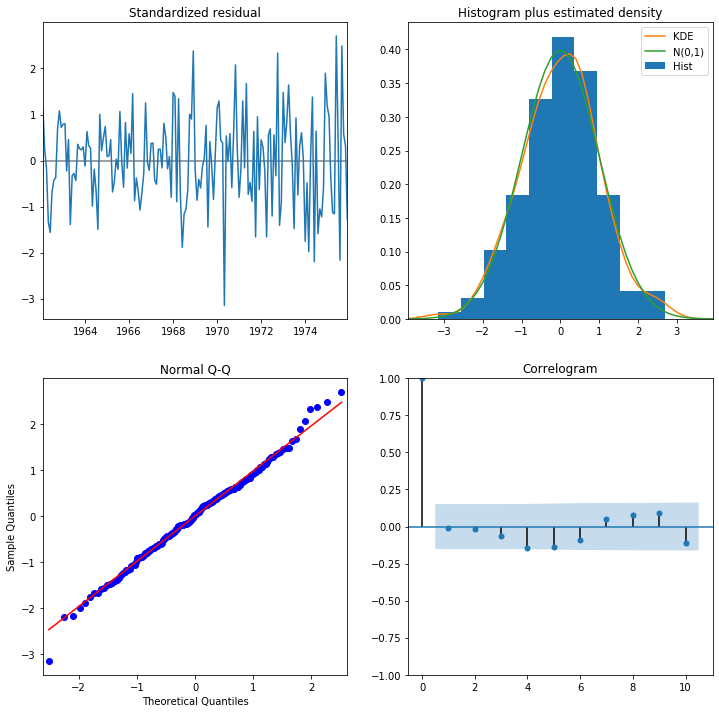

In [49]:
# Summarize residual errors for the chosen ARIMA model
model = SARIMAX(time_series, order=final_ns_order, seasonal_order=final_ss_order)
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(12,12))
plt.show()

In [50]:
if (notifyStatus): email_notify("Model Fitting and Evaluation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 5. Finalize Model

After models have been developed and a final model selected, it must be validated and finalized. Validation is an optional part of the process, but one that provides a ‘last check’ to ensure we have not fooled or lied to ourselves.

In [51]:
if (notifyStatus): email_notify("Model Finalization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Validation via In-sample Data

In [52]:
model = SARIMAX(time_series, order=final_ns_order, seasonal_order=final_ss_order)
results = model.fit()
forecast = results.get_prediction(start = -test_size)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


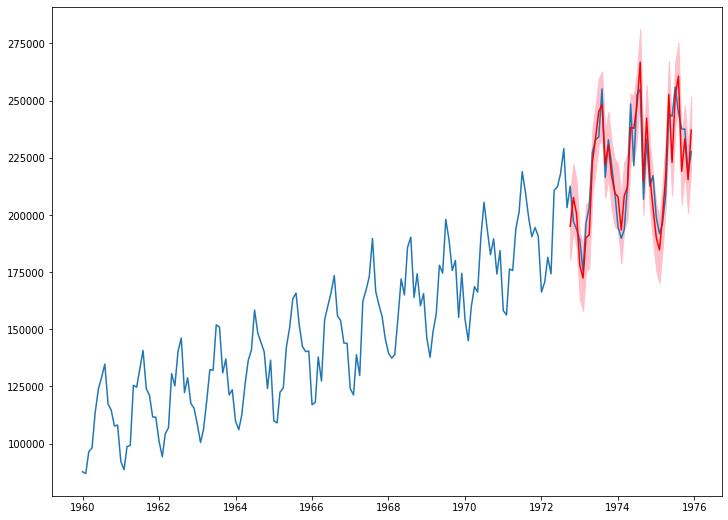

In [53]:
plt.figure(figsize=(12,9))
plt.plot(time_series.index, time_series[target_col], label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
plt.fill_between(confidence_intervals.index, confidence_intervals[lower_bound], confidence_intervals[upper_bound], color='pink')
plt.show()

In [54]:
# Evaluate RMSE for the validation data
y = time_series[-test_size:]
predictions = mean_forecast.values
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE from the validation data is: %.3f' % rmse)

RMSE from the validation data is: 9794.798


### 5.b) Forecasting Out-of-Sample Data

In [55]:
forecast = results.get_forecast(steps = test_size)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

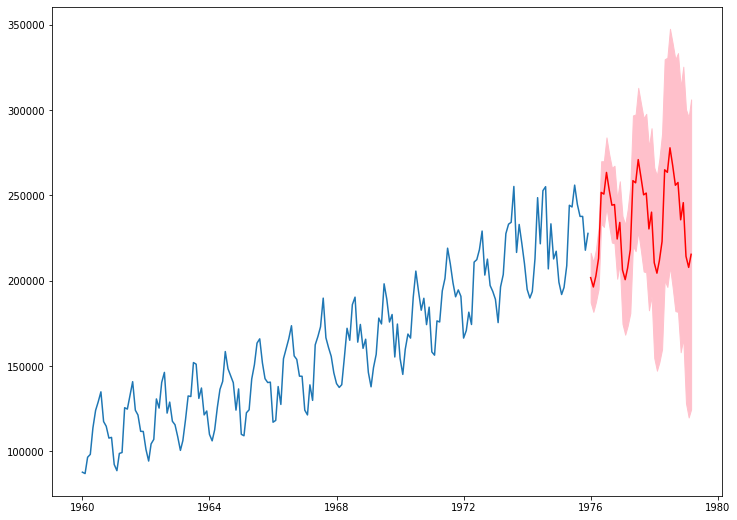

In [56]:
plt.figure(figsize=(12,9))
plt.plot(time_series.index, time_series[target_col], label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
plt.fill_between(confidence_intervals.index, confidence_intervals[lower_bound], confidence_intervals[upper_bound], color='pink')
plt.show()

In [57]:
if (notifyStatus): email_notify("Model Finalization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [58]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 13:00:12.676596
